# <div  style="text-align:center;padding:10.0px; background:#000000"> Thank you for your attention! Please upvote if you like it) </div>

It is notebook with AE based ARC solver (38M). On the re-arc validation data (but train tasks), the model achieves **25% accuracy of fully correct images** and **93% accuracy of correct pixels** (and this is not the limit!). However, the implementation of few-shot generation remains unresolved, as the accuracy on test tasks is 1% for fully correct images and 63% for correct pixels.

The main goal of this notebook is to propose a foundation for the CNN-based model architecture and demonstrate the capabilities of CNN generation from the latent space. I would appreciate any comments and suggestions!

Model structure:
<center>
<img src="https://i.postimg.cc/bNW6Lvcp/arc.png" width=1100>
</center>
// but without connection key to decoder

Below are examples of the model's performance on data it has not seen (but has seen this type of task). The main advantages and disadvantages of a pure CNN approach are visible. Concat Connection with input helps with many tasks.

It is very easy for CNN to process local pattern recognition tasks.
<center>
<img src="https://i.postimg.cc/6qS6tVX1/ex-1.png" width=1100>
</center>

And it's also possible to build nonlocal structures.
<center>
<img src="https://i.postimg.cc/d0vsstbv/ex-2.png" width=1100>
</center>

And understand connected areas.
<center>
<img src="https://i.postimg.cc/WzQVQ2GB/ex-3.png" width=1100>
</center>
More examples in Model Perfomance section.

# Base

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from   matplotlib import colors
plt.rcParams["font.family"] = "serif"

import json
import time
from tqdm import tqdm
from IPython.display import clear_output

ModuleNotFoundError: No module named 'sklearn'

In [2]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Utils

In [3]:
def pad_to_30x30(grid, pad_value=10):
    """Pads the grid to a size of 30x30 with the specified pad_value."""
    padded_grid = torch.full((30, 30), pad_value, dtype=torch.int8)
    height, width = len(grid), len(grid[0])
    padded_grid[:height, :width] = torch.tensor(grid, dtype=torch.int8)
    return padded_grid

def preprocess_images(dataset):
        one_hot_images = F.one_hot(dataset, num_classes=11)
        one_hot_images = one_hot_images.permute(0, 3, 1, 2)
        return one_hot_images.float()
    
def count_parameters(model):
    """Count the trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Visualization

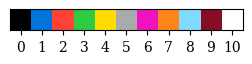

In [4]:
_cmap = colors.ListedColormap(
    ['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25', "#FFFFFF"])
_norm = colors.Normalize(vmin=0, vmax=10)

def plot_img(input_matrix, ax, title=""):
    ax.imshow(input_matrix, cmap=_cmap, norm=_norm)
    ax.grid(True, which = 'both',color = 'lightgrey', linewidth = 0.5)
    ax.set_yticks([x-0.5 for x in range(1 + len(input_matrix))])
    ax.set_xticks([x-0.5 for x in range(1 + len(input_matrix[0]))]) 
    if len(title) > 0: ax.set_title(title)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
plt.figure(figsize=(3, 1), dpi=100)
plt.imshow([list(range(10+1))], cmap=_cmap, norm=_norm)
plt.xticks(list(range(10+1)))
plt.yticks([])
plt.show()

# Load Data 

In [5]:
with open("/kaggle/input/arc-prize-2024/arc-agi_training_challenges.json", 'r') as f:
    train_challenges = json.load(f)
with open('/kaggle/input/arc-prize-2024/arc-agi_training_solutions.json', 'r') as f:
    train_solutions = json.load(f)
train_ids = list(train_challenges.keys())

In [6]:
# that re-arc tasks (but not train set by itself) were in train
train_ids_train = [train_ids[j] for j in [342, 318, 306, 314,  94, 145, 236, 177, 358, 251, 248, 322, 294,  76, 111, 367, 243, 182, 363, 278, 109, 293, 239,  37, 235, 113, 291, 105, 155, 262,  92, 133, 283,  11, 237, 214,  75, 240, 346, 267, 186,  19, 385, 265, 203, 268,  16, 274, 365, 132, 170, 175, 362, 227,  70, 344,  14, 370,  72, 296, 246,  61, 302, 189, 118, 181, 127, 230, 135, 374, 357,  52, 192, 110,  58, 209, 151,   1, 210, 372,  35, 353, 300, 141,  80, 150, 247, 185, 315, 379,  53, 147, 121, 208, 389, 215, 169, 104, 153, 154,  50, 202, 361, 288, 329, 301,  96, 305, 241, 124,  95, 303, 343,  45, 348, 399, 368, 325,  27, 161, 279, 233, 125, 347,  59, 304, 371, 339,  28, 295, 137, 188, 200, 266, 252, 228, 312, 146, 244, 320, 259, 375,  66,  90, 359, 297, 224,  41, 392,  30,  33,  18, 160, 213, 280,  15, 101, 377,  77, 383,  60, 282, 281,  93, 345,  13,  88, 284, 270, 174,  48, 388,  85,  97, 341, 144, 330, 255, 226,  68, 171, 231,   4, 271, 116, 221, 211, 190, 366, 134, 352, 328,  49, 275,  79,  25,  34, 378, 334, 258, 326, 156, 212, 242, 166, 232, 395, 164,  64,  24,   3, 162, 130, 136, 234, 310, 307,  91, 311, 250, 398, 229, 257, 397, 273, 163, 272, 103, 114, 165, 100, 245,  36, 129, 321, 117, 225, 356, 219, 290, 102, 292, 269, 106, 168,  73, 380,  69, 384,  89,  87,   9, 159, 396,  78,  56,  65,  43, 126,  26, 360, 317,  74,  31,   2,  20, 238, 308, 119, 386, 327,  99, 128,  57, 201, 107, 148, 349,  12, 313, 123, 390,  21, 183, 309,   0, 217, 393, 143, 394,  47, 115, 376, 158, 373, 335,  46,  39, 195, 369]]
# that re-arc tasks were not in train
train_ids_test = [train_ids[j] for j in [196,  51,  82, 149, 299,  29, 331, 180, 206, 287, 178, 152, 199, 108, 276, 176,  22, 254, 172,  32,  83, 350, 387, 131,  17, 323,  38, 338,   6, 204, 193, 316, 391,  62, 249, 263, 364, 340, 286, 336,  86, 198, 289, 355, 354, 382,  40, 319, 332, 222, 140, 142, 187, 173, 157, 351,  54, 138,  71, 167, 298,  10, 285,  44, 220, 207, 223, 120, 264, 197, 139, 218,  42, 337,  98,  23,   5, 256,  63, 194, 260, 277, 324, 261, 216,   8,  81, 381, 253, 112, 122,  55,  84, 191,  67,   7, 179, 205, 184, 333]]

# Load Model

In [7]:
class ResBlock(nn.Module):
    def __init__(self, C: int, dropout_prob: float):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.bnorm1 = nn.BatchNorm2d(C)
        self.bnorm2 = nn.BatchNorm2d(C)
        self.conv1 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = x
        r = self.conv1(self.relu(self.bnorm1(x)))
        r = self.dropout(r)
        r = self.conv2(self.relu(self.bnorm2(r)))
        return r + x

    
class ConvBlock(nn.Module):
    def __init__(self, mode: str, C_in: int, C_out: int, dropout_prob: float):
        super().__init__()
        self.relu = nn.ReLU()
        self.bnorm = nn.BatchNorm2d(C_out)
        if mode=="down":
            self.conv = nn.Conv2d(C_in, C_out, kernel_size=4, stride=2, padding=0)
        elif mode=="up":
            self.conv = nn.ConvTranspose2d(C_in, C_out, kernel_size=4, stride=2, padding=0)
        elif mode=="same":
            self.conv = nn.Conv2d(C_in, C_out, kernel_size=3, padding=1)
        else:
            raise ValueError("Wrong ConvBlock mode.")
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, z):
        x = self.conv(z)
        x = self.bnorm(x)
        x = self.relu(x)
        x = self.dropout(x)
        return x

In [8]:
class Encoder(nn.Module):
    def __init__(self, channels=[256, 512, 512], latent_dim=512, dropout=0.1):
        super(Encoder, self).__init__()
        self.conv1 = ConvBlock("down", 11,  channels[0], dropout)
        self.res12 = ResBlock(channels[0], dropout)
        self.conv2 = ConvBlock("down", channels[0], channels[1], dropout)
        self.res23 = ResBlock(channels[1], dropout)
        self.conv3 = ConvBlock("down", channels[1], channels[2], dropout)
        self.fc = nn.Linear(channels[2] * 2 * 2, latent_dim)

    def forward(self, z):
        residuals = [0] * 3
        x = preprocess_images(z)
        x = self.conv1(x)
        x = self.res12(x)
        residuals[0] = x
        x = self.conv2(x)
        x = self.res23(x)
        residuals[1] = x
        x = self.conv3(x)
        residuals[2] = x
        x = x.reshape(x.size(0), -1)
        encoded = self.fc(x)
        return encoded, residuals
    
class Decoder(nn.Module):
    def __init__(self, channels=[256, 512, 512], latent_dim=512, dropout=0.1):
        super(Decoder, self).__init__()
        self.channels = channels
        self.fc = nn.Linear(latent_dim, channels[-1] * 2 * 2)
        self.conv3 = ConvBlock("up", channels[-1]*2, channels[-2], dropout)
        self.res32 = ResBlock(channels[-2], dropout)
        self.conv2 = ConvBlock("up", channels[-2]*2, channels[-3], dropout)
        self.res21 = ResBlock(channels[-3], dropout)
        self.conv1 = ConvBlock("up", channels[-3]*2, channels[-3], dropout)
        self.conv0 = nn.Conv2d(channels[-3], 11, kernel_size=3, padding=1)

    def forward(self, z, residuals):
        x = self.fc(z)
        x = x.reshape(x.size(0), self.channels[-1], 2, 2)  # Unflatten using reshape instead of view
        x = torch.cat((x, residuals[2]), dim=1)
        x = self.conv3(x)
        x = self.res32(x)
        x = torch.cat((x, residuals[1]), dim=1)
        x = self.conv2(x)
        x = self.res21(x)
        x = torch.cat((x, residuals[0]), dim=1)
        x = self.conv1(x)
        x = self.conv0(x)
        return x
    
    
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.1):
        super(MLP, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1  = nn.Linear(input_size, hidden_size)
        self.bn1  = nn.BatchNorm1d(hidden_size)
        self.fc2  = nn.Linear(hidden_size, hidden_size)
        self.bn2  = nn.BatchNorm1d(hidden_size)
        self.fc3  = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, z):
        x = self.relu(self.bn1(self.fc1(z)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        output = self.fc3(x)
        return output

In [9]:
class Magician(nn.Module):
    def __init__(self, channels, latent_dim, hidden_size, dropout=0.1):
        super(Magician, self).__init__()
        self.channels    = channels
        self.latent_dim  = latent_dim
        self.hidden_size = hidden_size
        self.encoder = Encoder(channels, latent_dim, dropout)
        self.decoder = Decoder(channels, latent_dim, dropout)
        self.mlp_key = MLP(latent_dim * 6, hidden_size, latent_dim)
        self.mlp_map = MLP(latent_dim * 2, hidden_size, latent_dim)

    def forward(self, input, edu_pairs):
        # calculate key
        edu_pairs_encoded    = edu_pairs.flatten(end_dim=-3)
        edu_pairs_encoded, _ = self.encoder(edu_pairs_encoded)
        edu_pairs_encoded    = edu_pairs_encoded.reshape(2, -1, 3, self.latent_dim).permute(1, 0, 2, 3).flatten(start_dim=1)
        key = self.mlp_key(edu_pairs_encoded)
        # encode input
        input_encoded, residuals = self.encoder(input)
        # calculate encoded_output
        output_encoded = self.mlp_map(torch.concat((input_encoded, key), dim=1))
        # decode output
        output_decoded = self.decoder(output_encoded, residuals)
        return output_decoded

In [10]:
def model_pred(id_val):
    edu_examples = train_challenges[id_val]["train"]
    edu_examples = edu_examples[:3]
    while len(edu_examples) < 3:
        edu_examples += [edu_examples[-1]]

    input = pad_to_30x30(train_challenges[id_val]["test"][0]["input"]).unsqueeze(0)
    edu_pairs = torch.zeros((2, 1, 3, 30, 30), dtype=torch.int64)
    for j in range(3):
        edu_pairs[0, 0, j] = pad_to_30x30(edu_examples[j]["input"])
        edu_pairs[1, 0, j] = pad_to_30x30(edu_examples[j]["output"])
    input = input.long()
    edu_pairs = edu_pairs.long()

    output_pred_padded = torch.argmax(model(input, edu_pairs)[0], dim=0)
    lim_hor = (output_pred_padded[0] < 10).sum()
    lim_ver = (output_pred_padded[:, 0] < 10).sum()
    output_pred = output_pred_padded[:lim_ver, :lim_hor]
    return output_pred

In [11]:
channels    = [256, 512, 512]
latent_dim  = 512
hidden_size = 512

model = Magician(channels, latent_dim, hidden_size)
model_size = count_parameters(model)
print(f"model {int(model_size/1e6)}M")
print("encoder size:", count_parameters(model.encoder))
print("decoder size:", count_parameters(model.decoder))
print("mlp_key size:", count_parameters(model.mlp_key))
print("mlp_map size:", count_parameters(model.mlp_map))

model 38M
encoder size: 13292288
decoder size: 21661963
mlp_key size: 2100736
mlp_map size: 1052160


In [12]:
print(model.load_state_dict(torch.load("/kaggle/input/arc-cnn-solver/F_38M_1.pth", map_location=device, weights_only=False)))
model.eval()
model.to(device);

<All keys matched successfully>


The data was used from re-arc, with a total of 10M generated examples shown during training in 12 hours.
<center>
<img src="https://i.postimg.cc/QdRvJ48M/train.png" width=1100>
</center>

# Model Perfomance

In [13]:
def show_task_prediction(id_val):
    output_true = np.array(train_solutions[id_val][0])
    output_pred = model_pred(id_val).cpu().numpy()
    if output_pred.shape == output_true.shape:
        mes = f"#err = {(output_pred != output_true).sum()}"
    else:
        mes = f"wrong shape"

    imgs = train_challenges[id_val]["train"]
    edu_examples_num = min(len(imgs), 3)
    fig, axs = plt.subplots(2, edu_examples_num+2, dpi=150, figsize=((edu_examples_num+2)*3, 6))
    for j in range(edu_examples_num):
        plot_img(imgs[j]["input"],  axs[0, j], "edu input")
        plot_img(imgs[j]["output"], axs[1, j], "edu output")
    plot_img(train_challenges[id_val]["test"][0]["input"],  axs[0, edu_examples_num], "input")
    plot_img(output_true,  axs[1, edu_examples_num+1], "output true")
    plot_img(output_pred,  axs[1, edu_examples_num], "output pred")
    fig.delaxes(axs[0,edu_examples_num+1])
    plt.suptitle(f"{id_val}: {mes}")
    plt.show()

It works realy nice with local tasks!

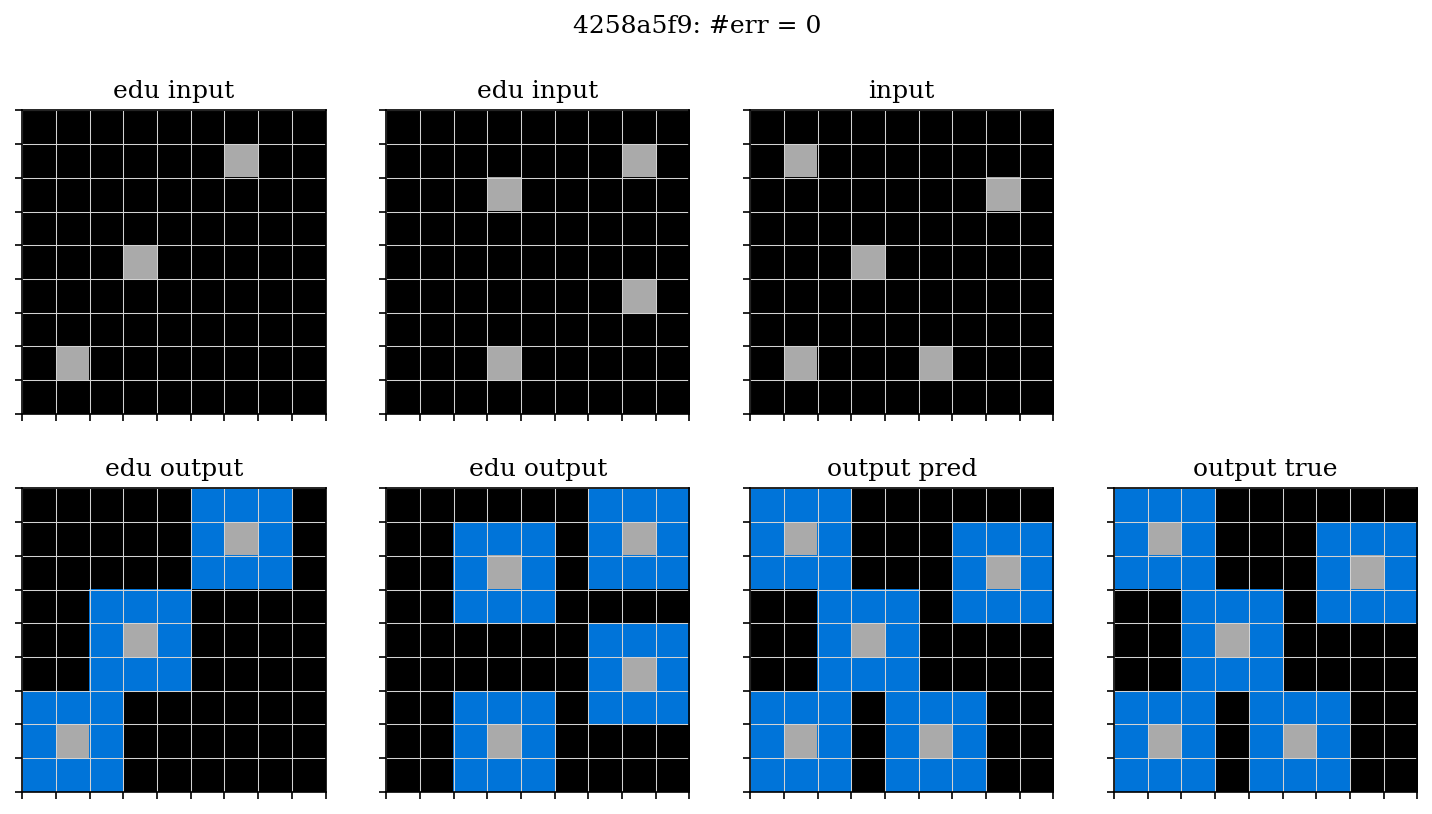

In [14]:
show_task_prediction(train_ids_train[4])

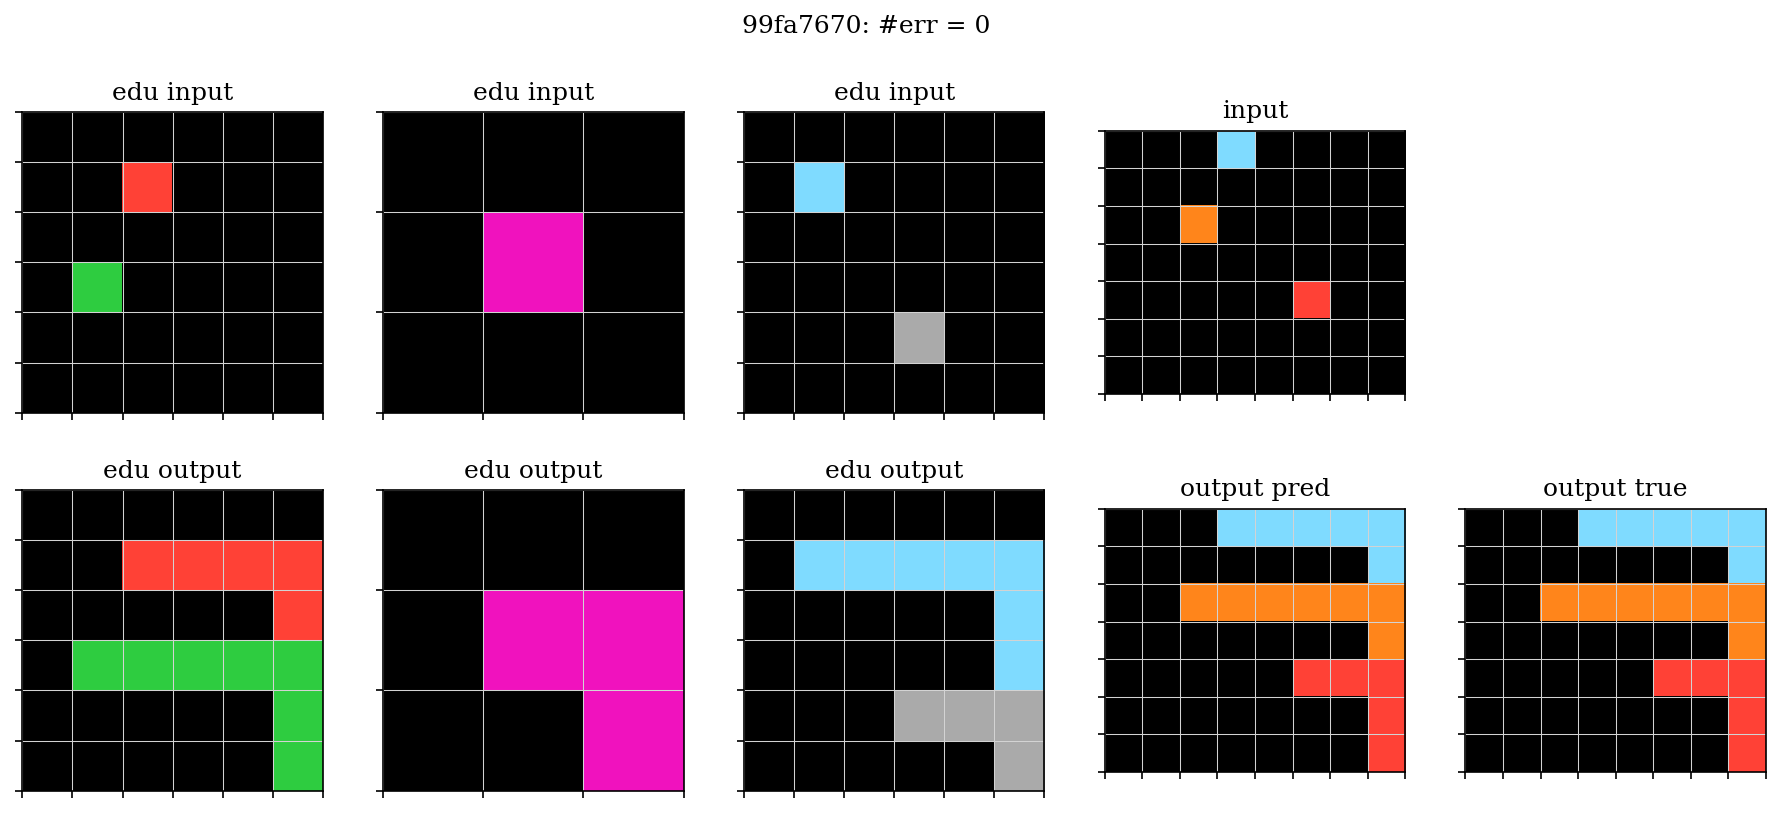

In [15]:
show_task_prediction(train_ids_train[6])

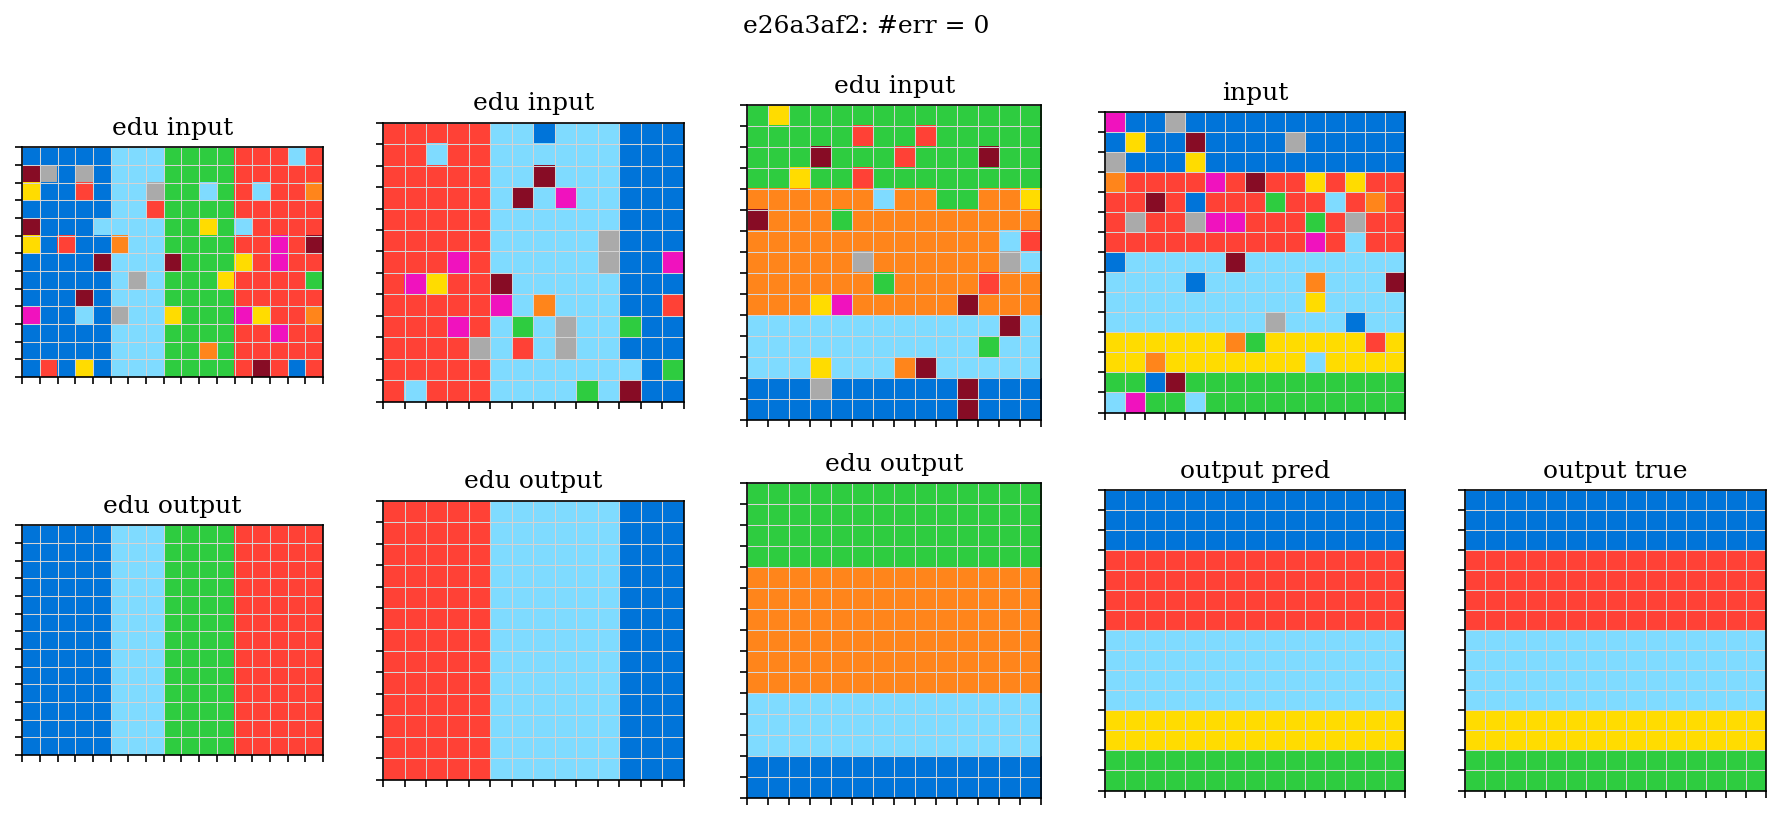

In [16]:
# and, of course, with denoising
show_task_prediction(train_ids_train[8])

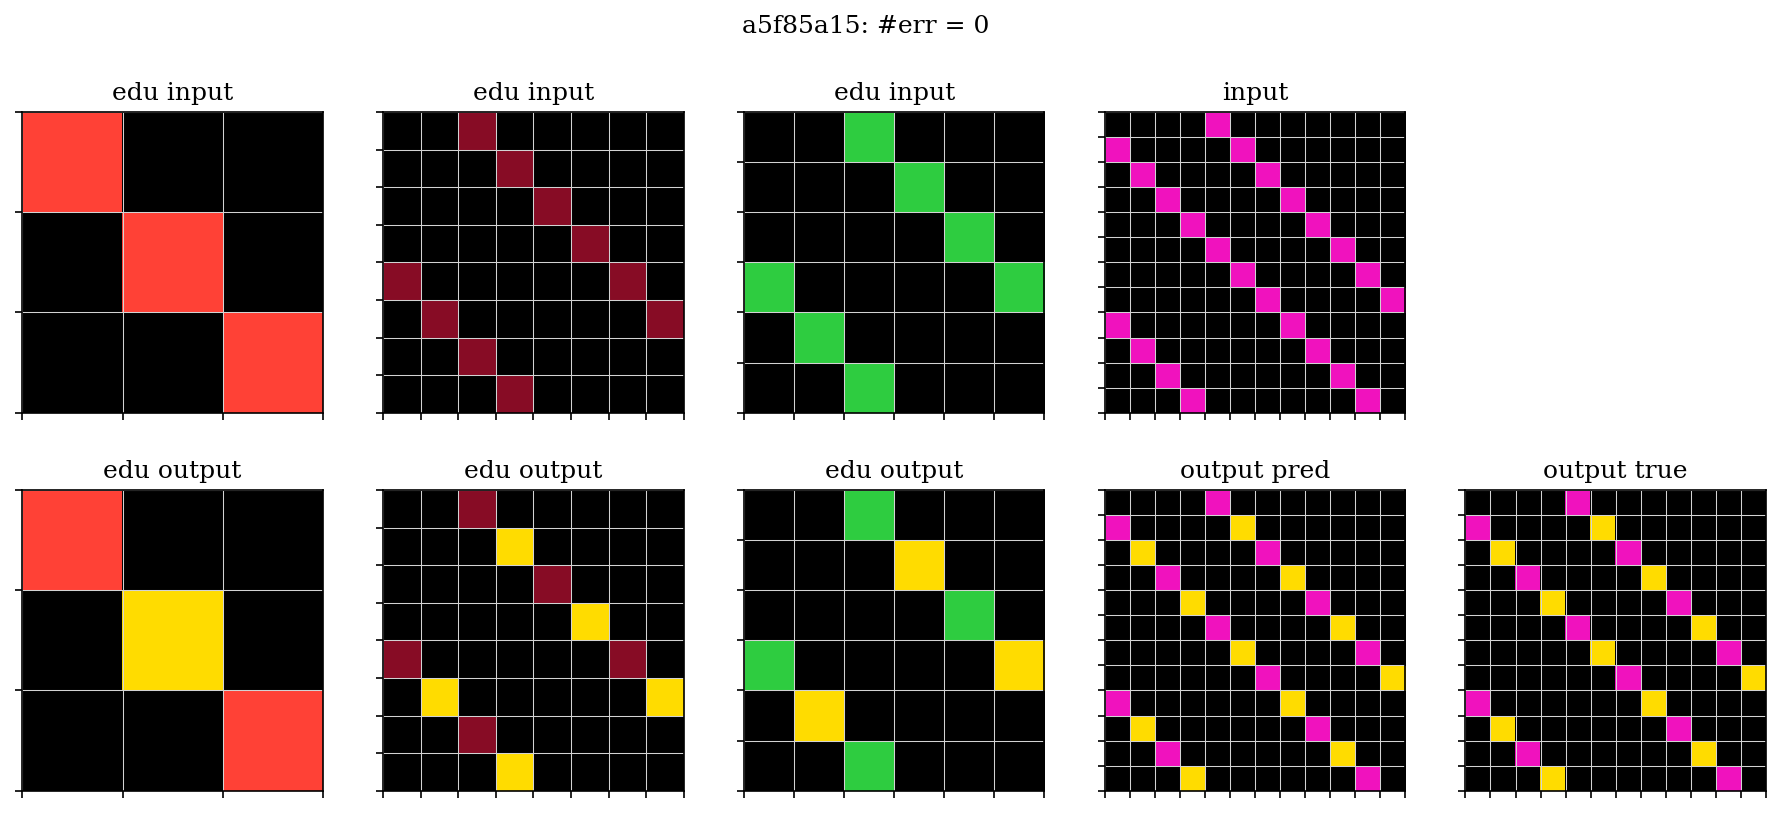

In [17]:
show_task_prediction(train_ids_train[9])

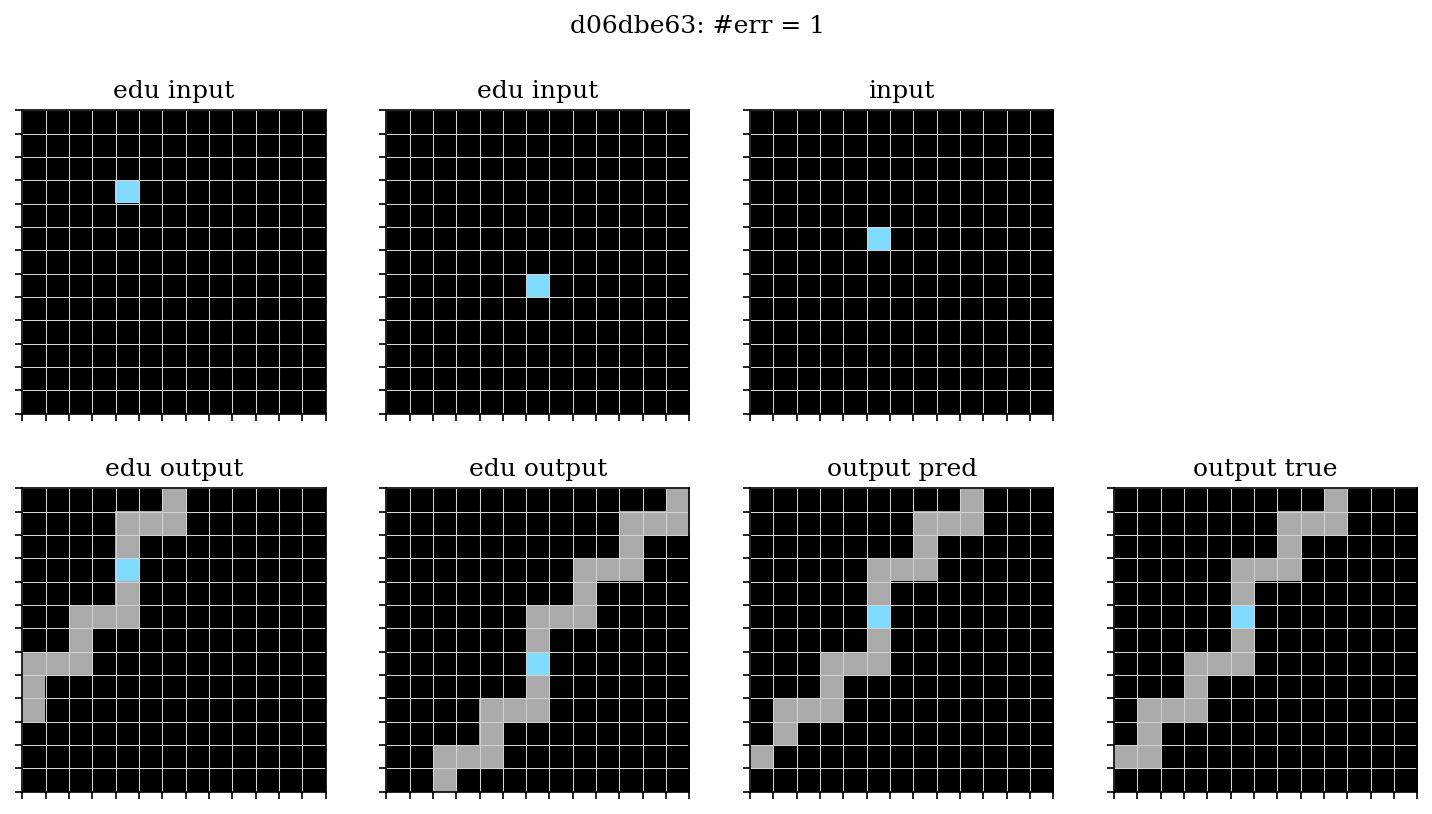

In [18]:
# and even with shape construction
show_task_prediction(train_ids_train[11])

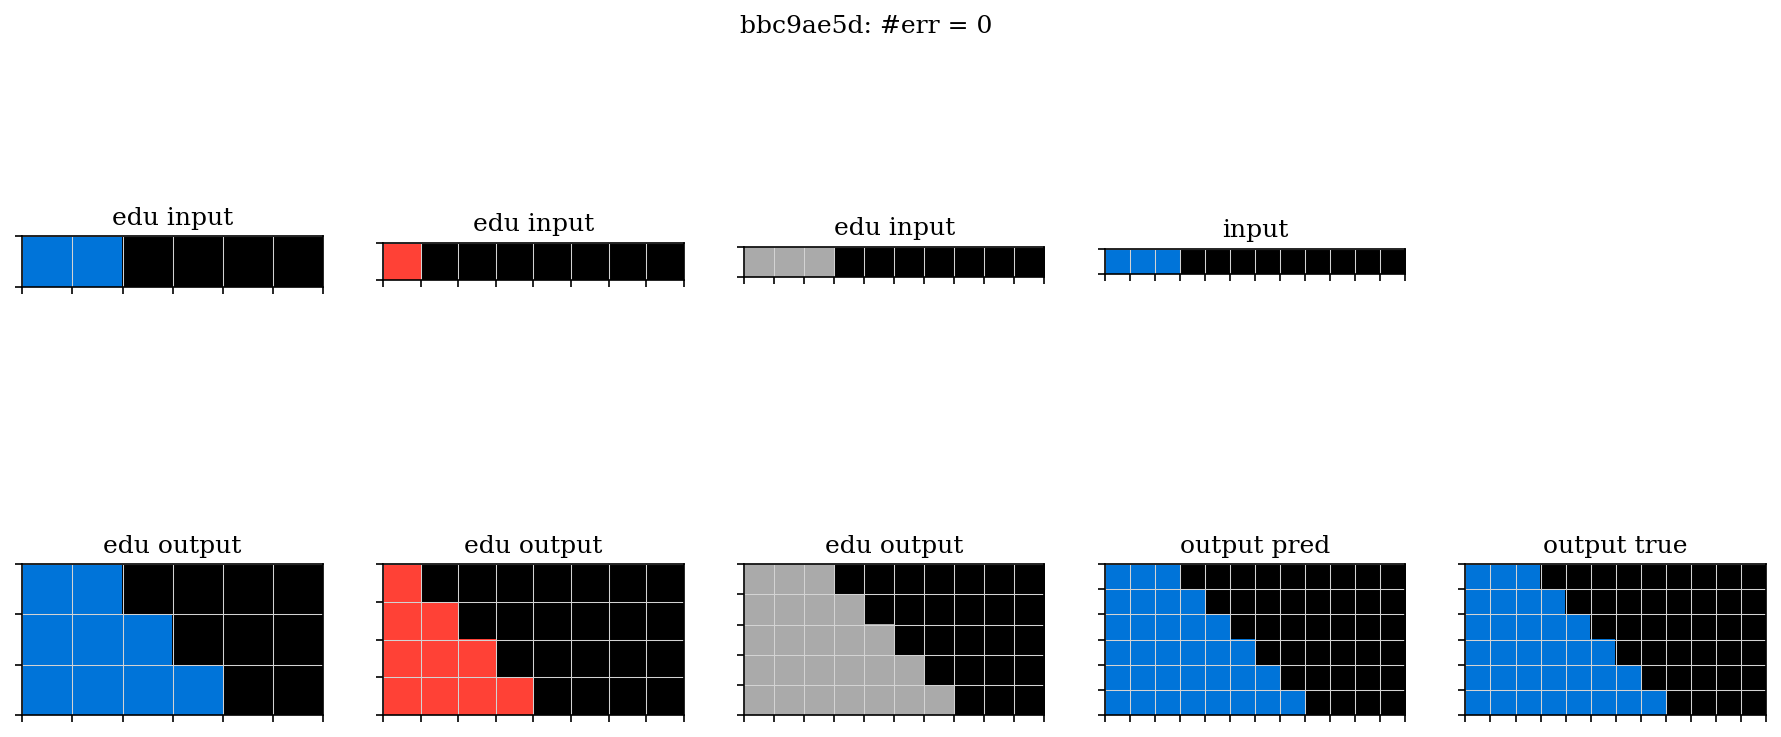

In [19]:
show_task_prediction(train_ids_train[12])

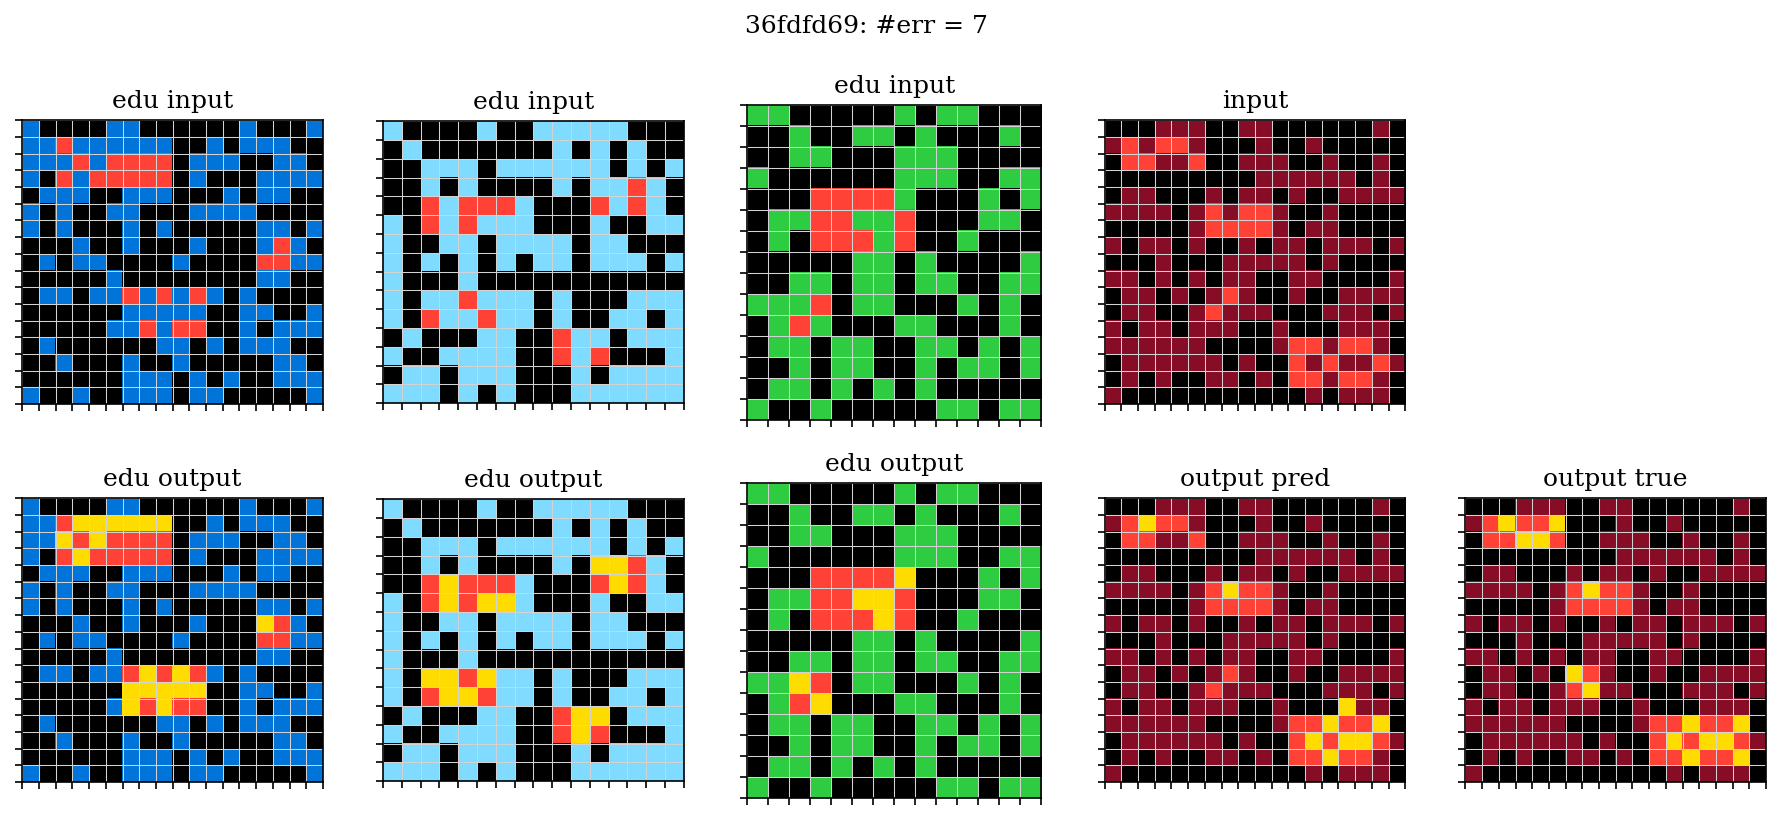

In [20]:
show_task_prediction(train_ids_train[13])

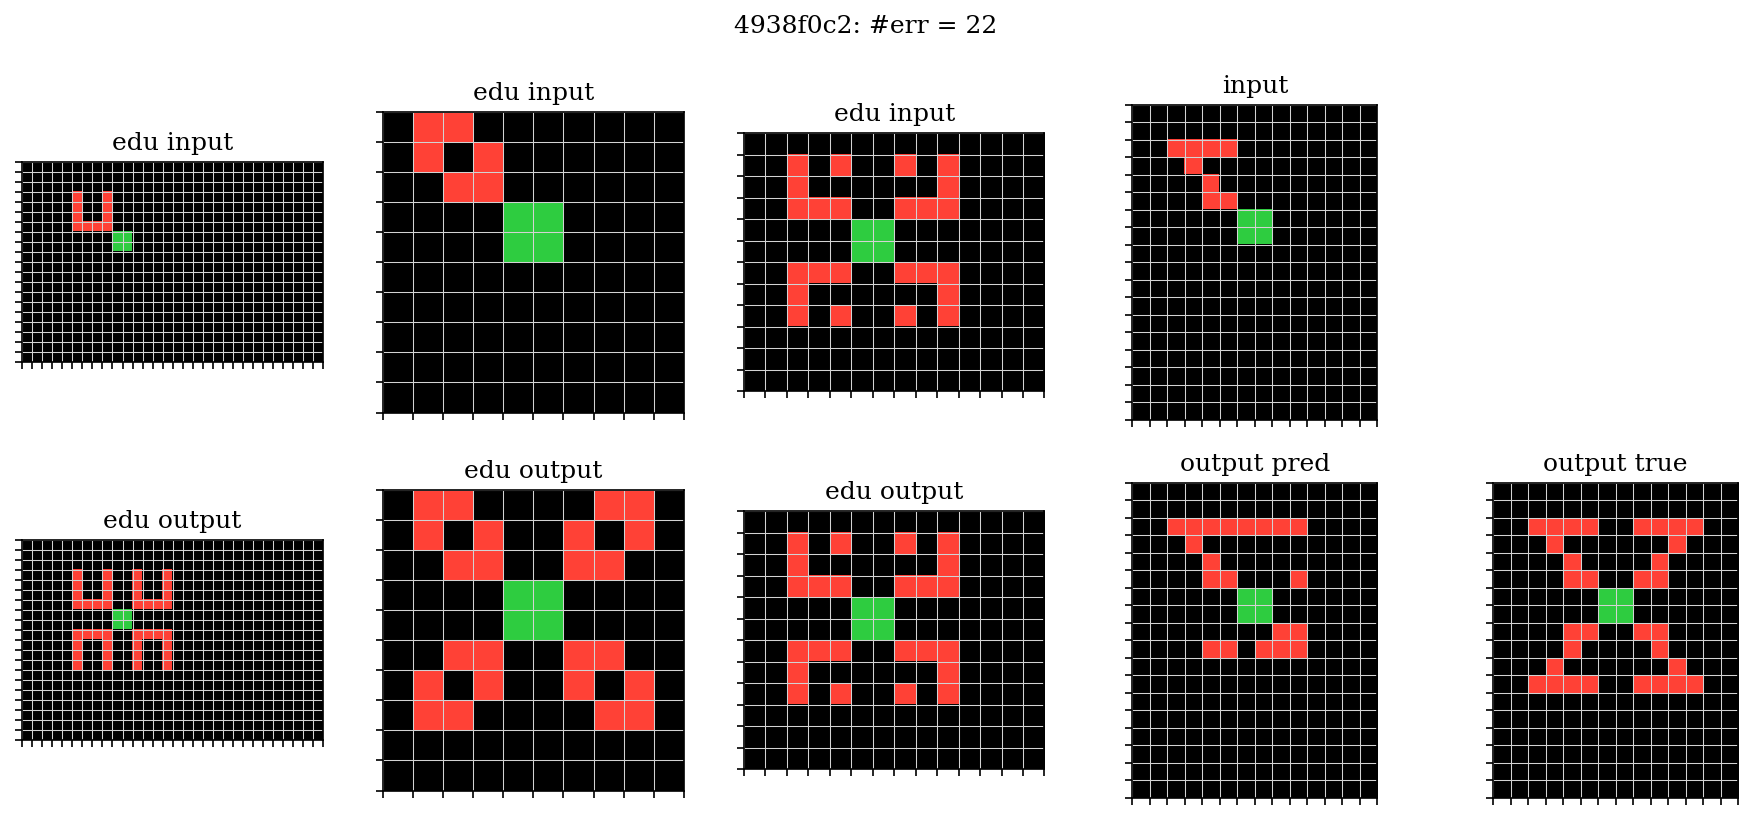

In [21]:
# But it's not so good with symetry understanding. If you have any ideas on where to go to fix this, be sure to write!
show_task_prediction(train_ids_train[14])

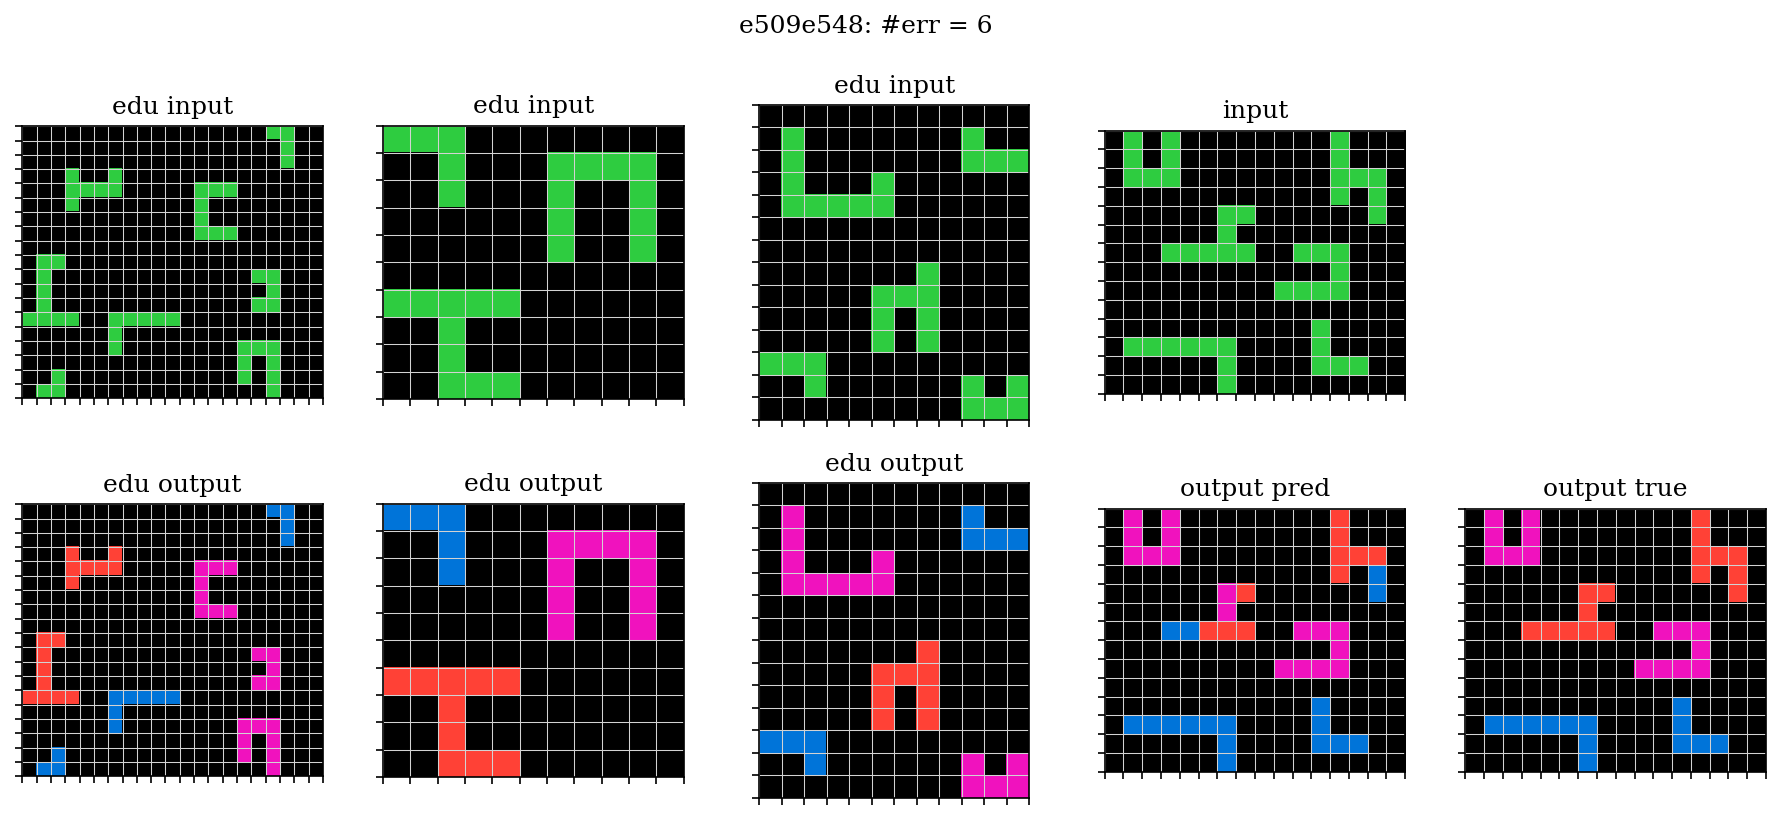

In [22]:
show_task_prediction(train_ids_train[18])

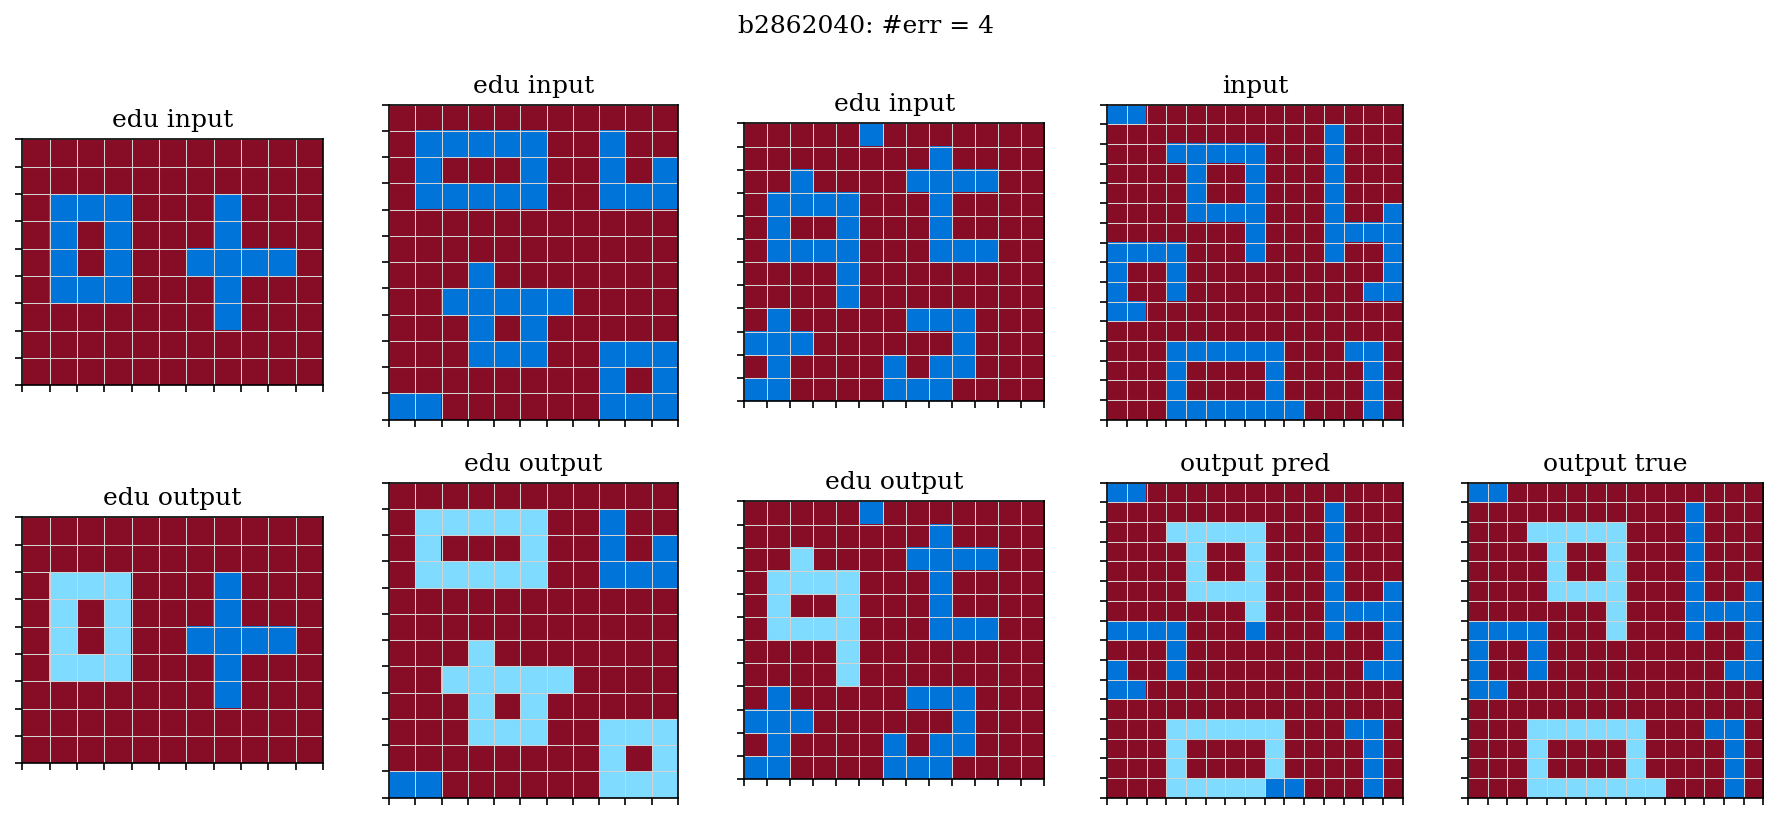

In [23]:
show_task_prediction(train_ids_train[19])

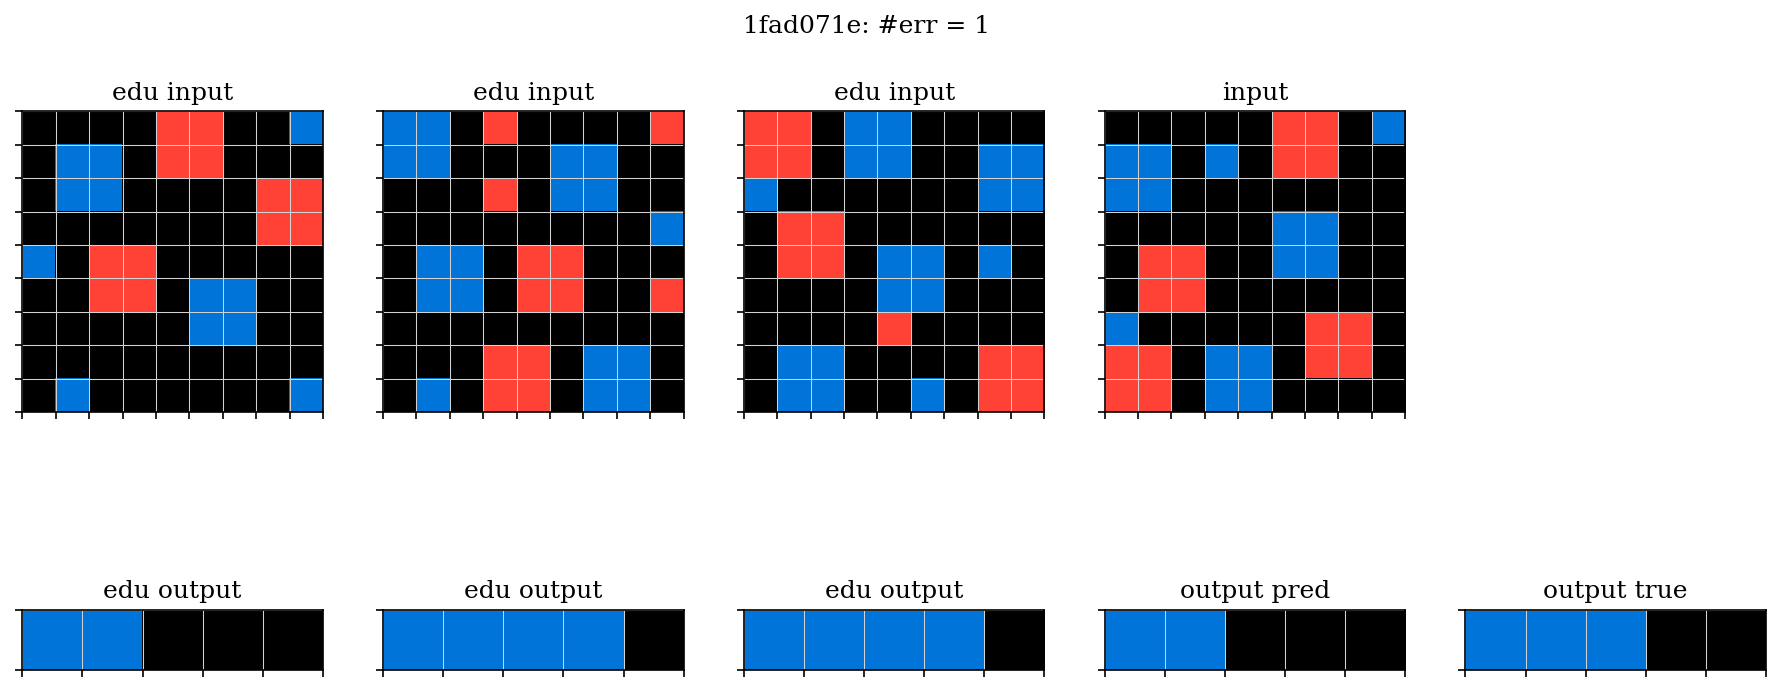

In [24]:
# right shape, not so good logic
show_task_prediction(train_ids_train[23])

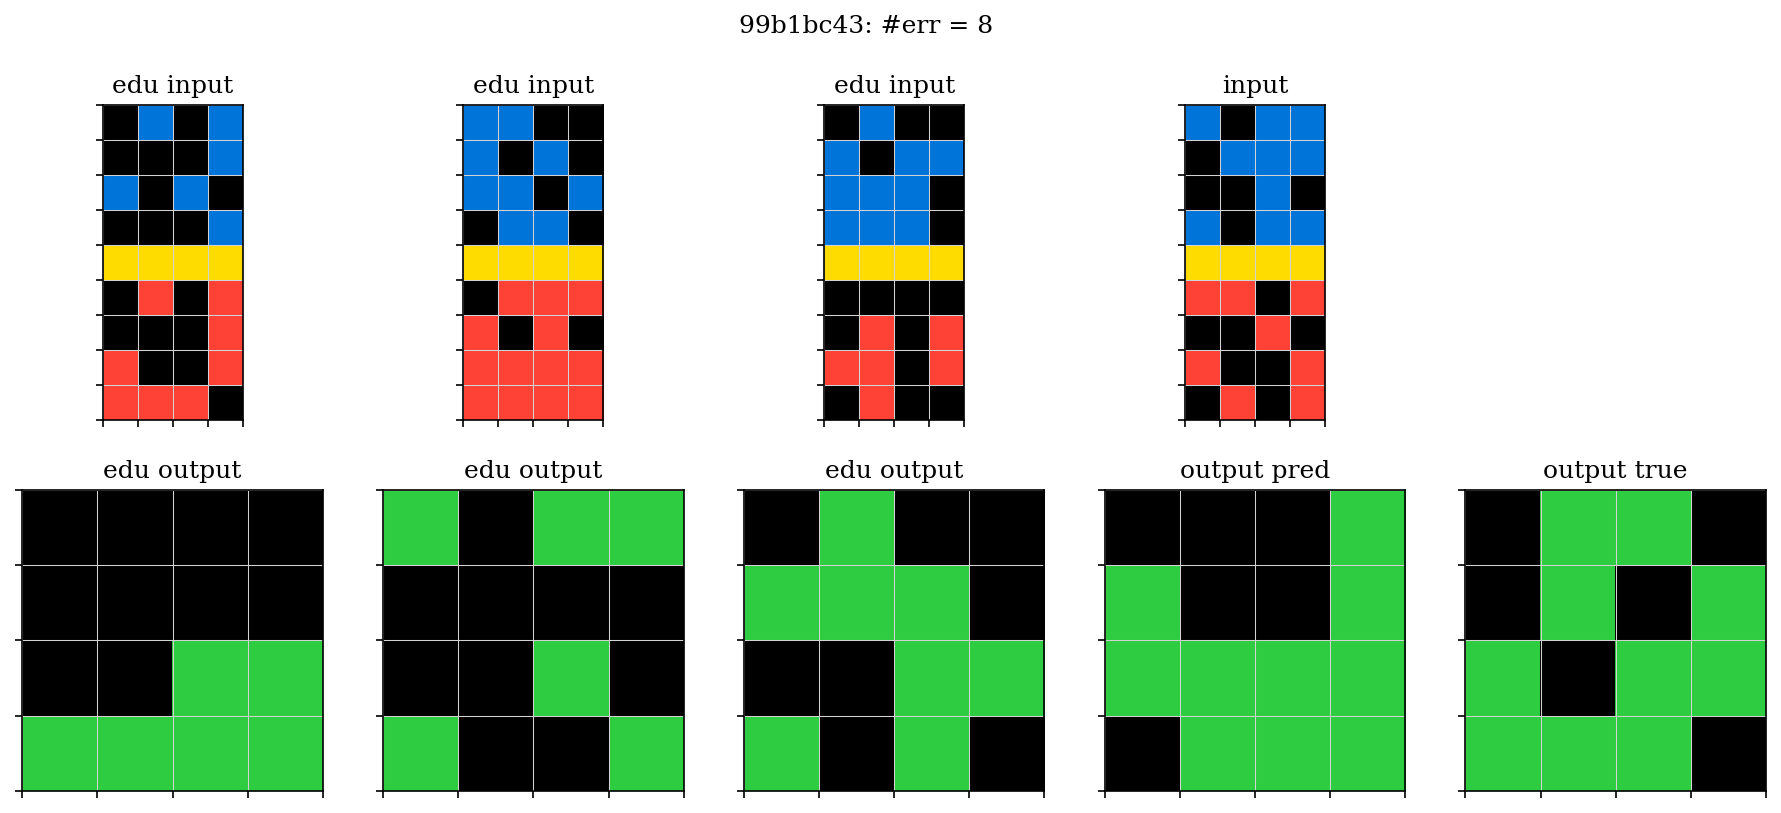

In [25]:
show_task_prediction(train_ids_train[24])

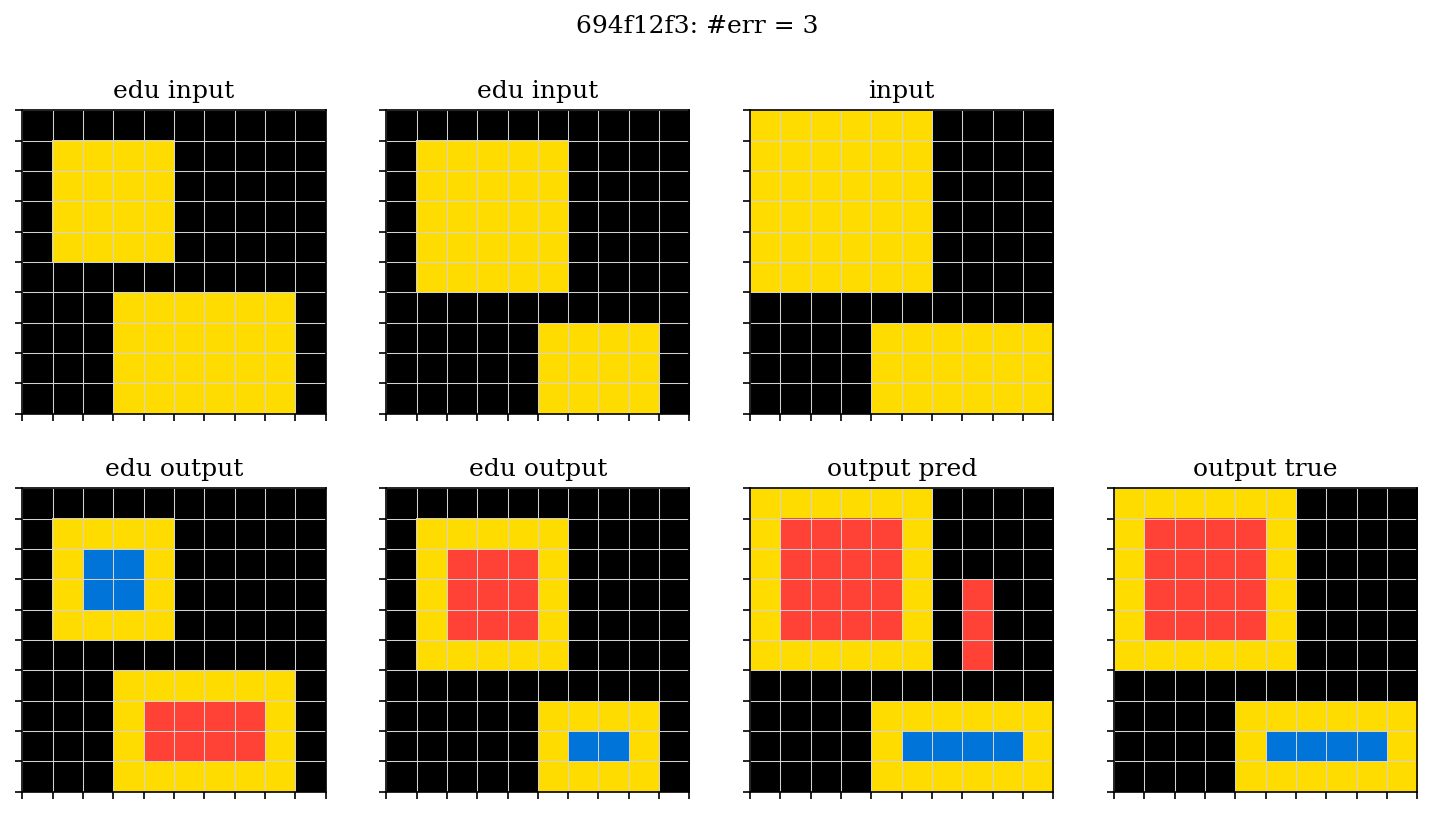

In [26]:
show_task_prediction(train_ids_train[28])

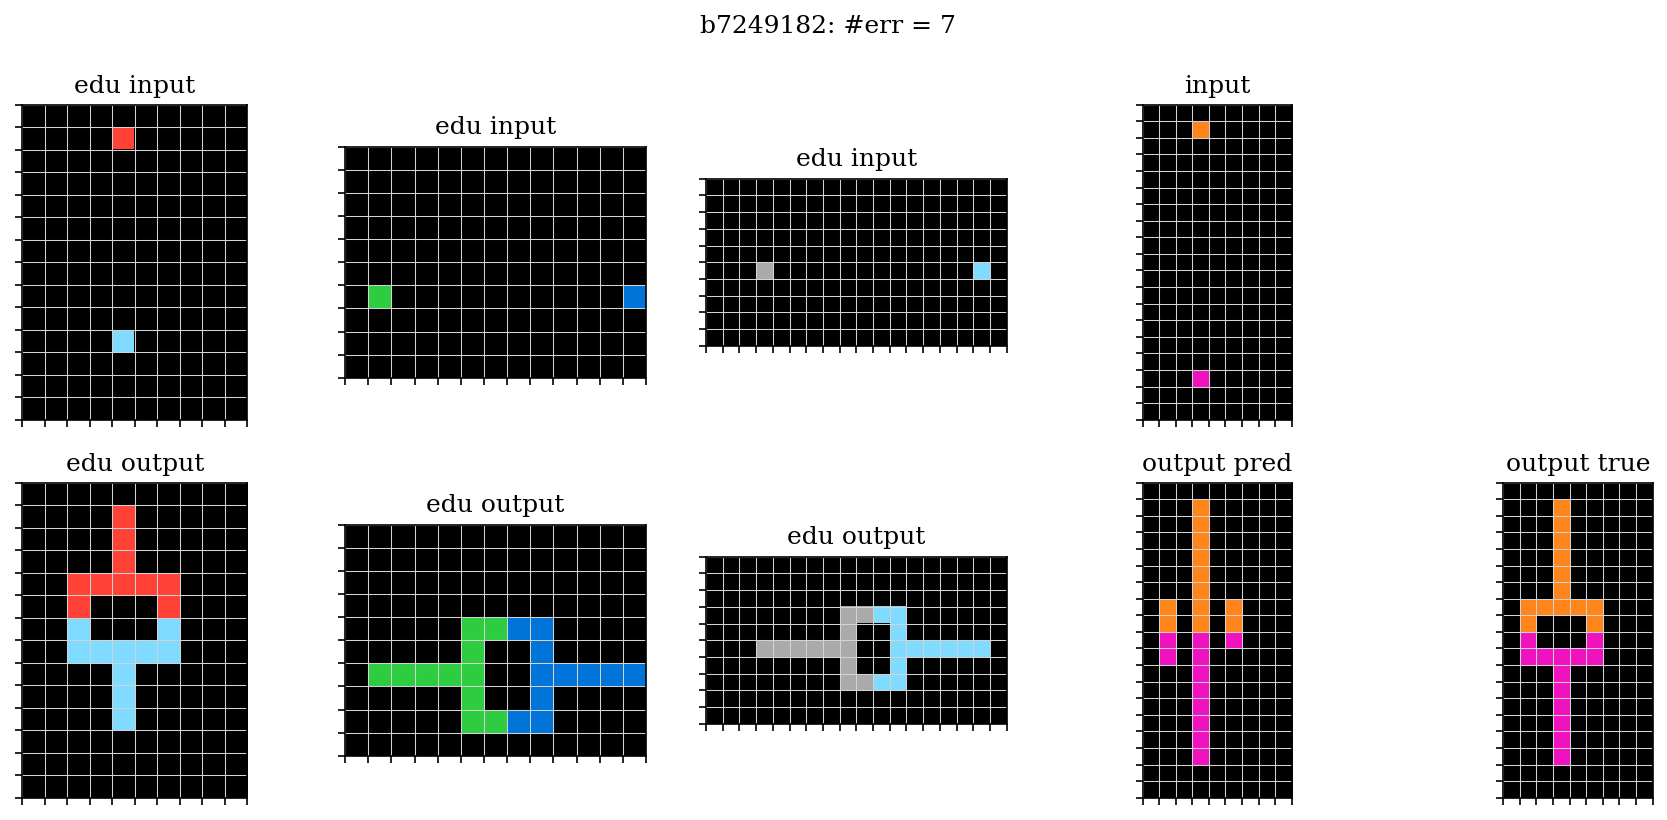

In [27]:
show_task_prediction(train_ids_train[32])

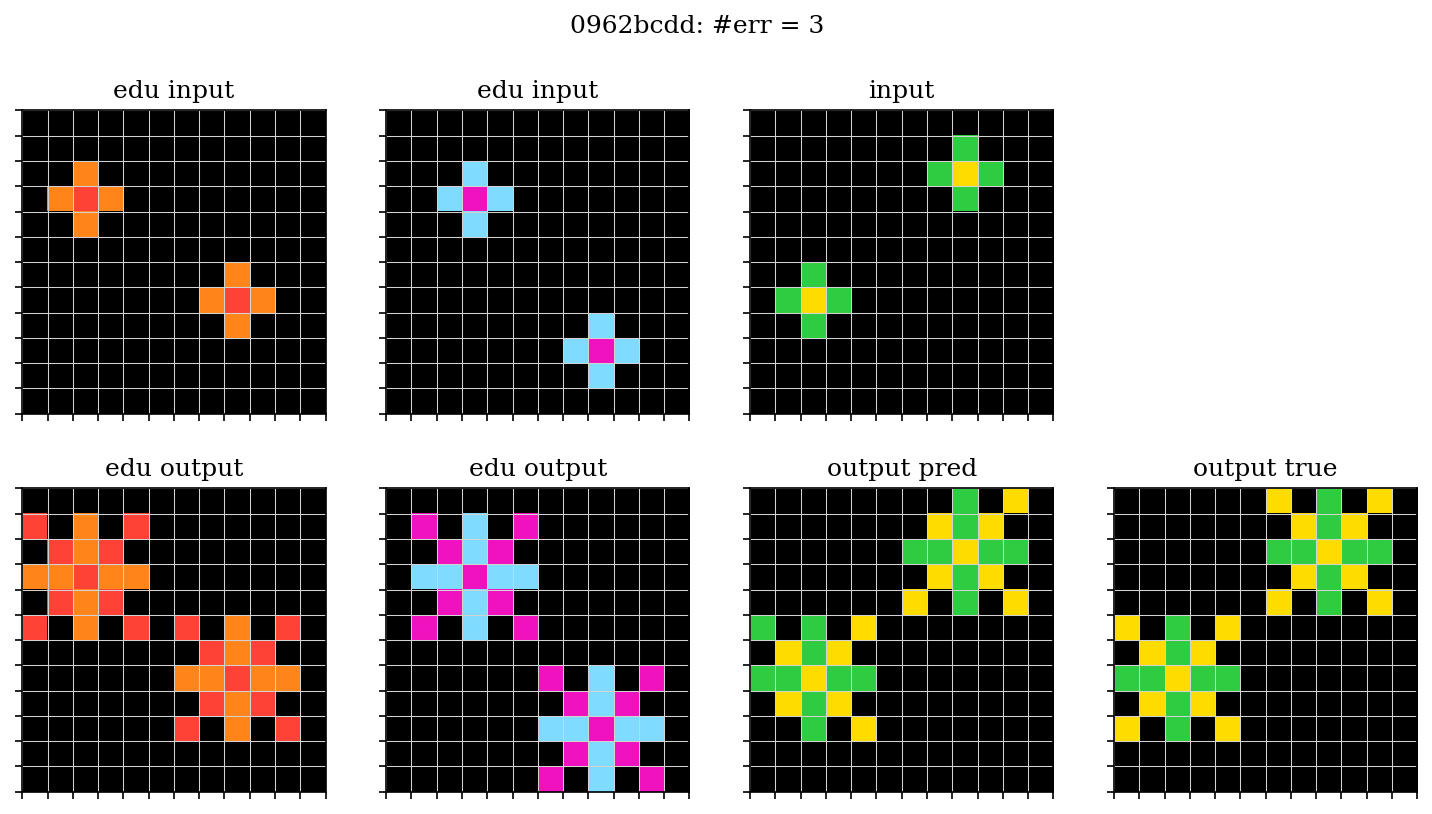

In [28]:
show_task_prediction(train_ids_train[33])

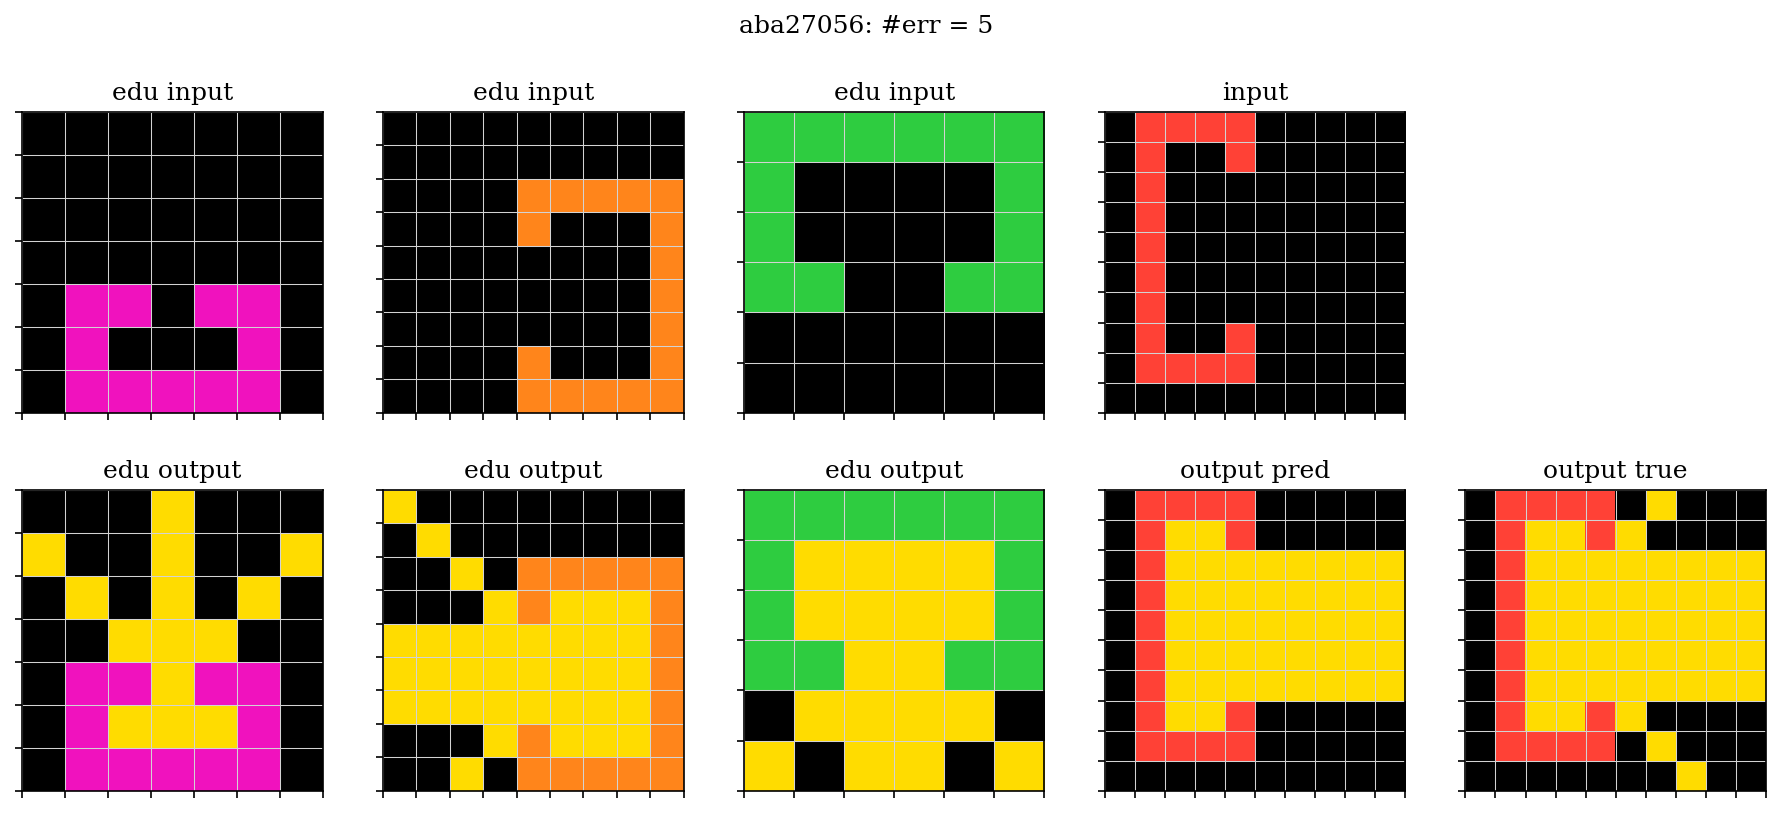

In [29]:
show_task_prediction(train_ids_train[39])

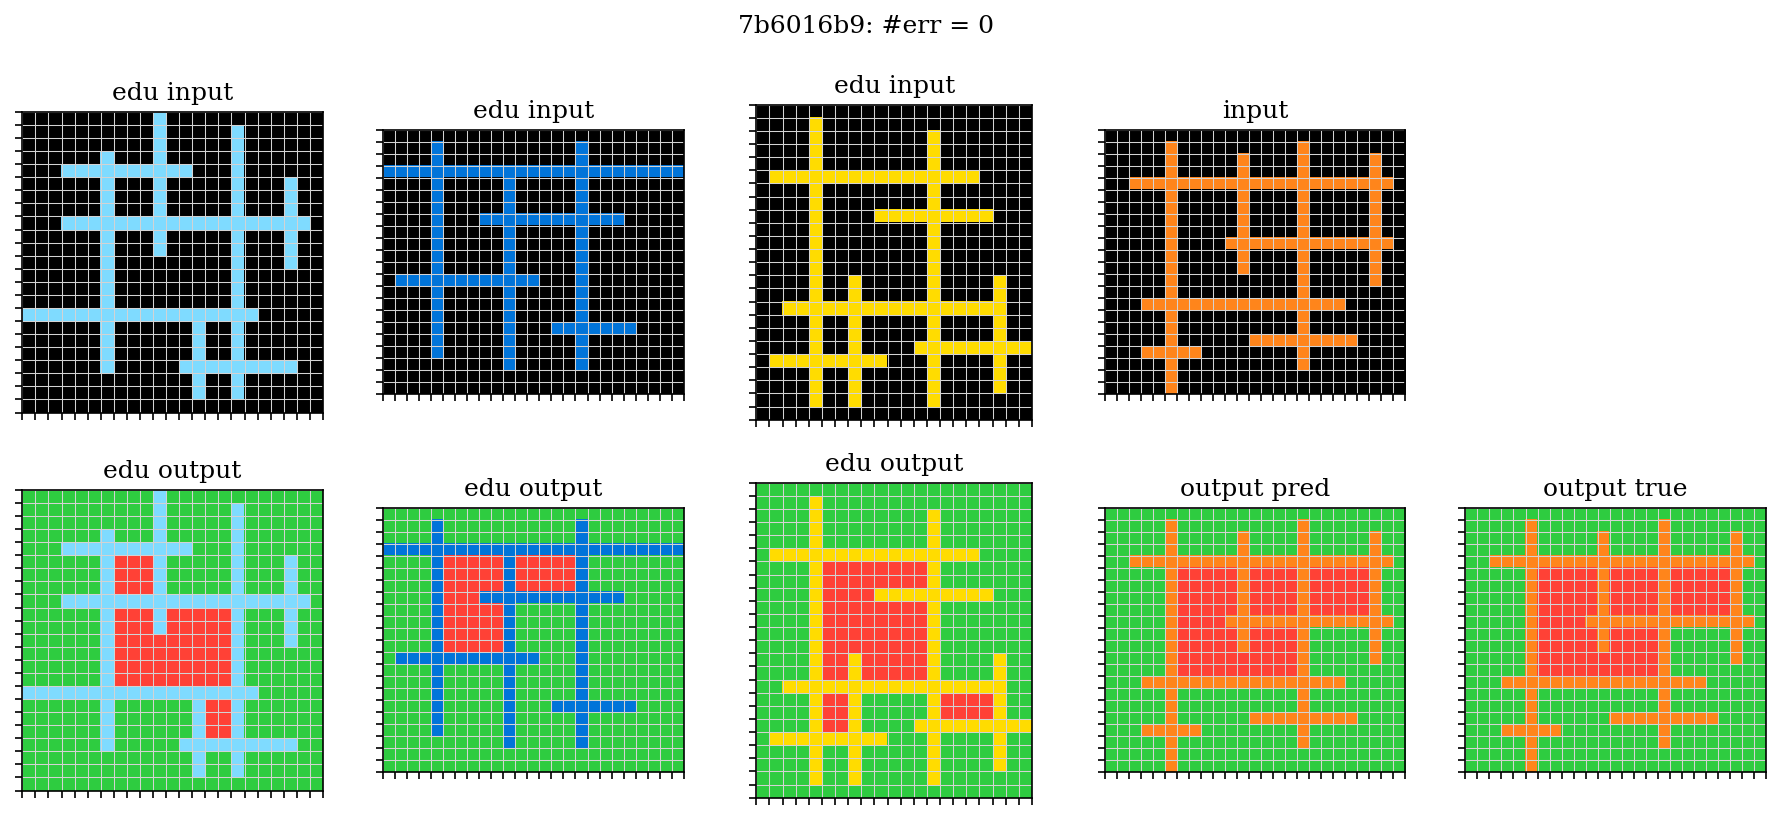

In [30]:
show_task_prediction(train_ids_train[40])

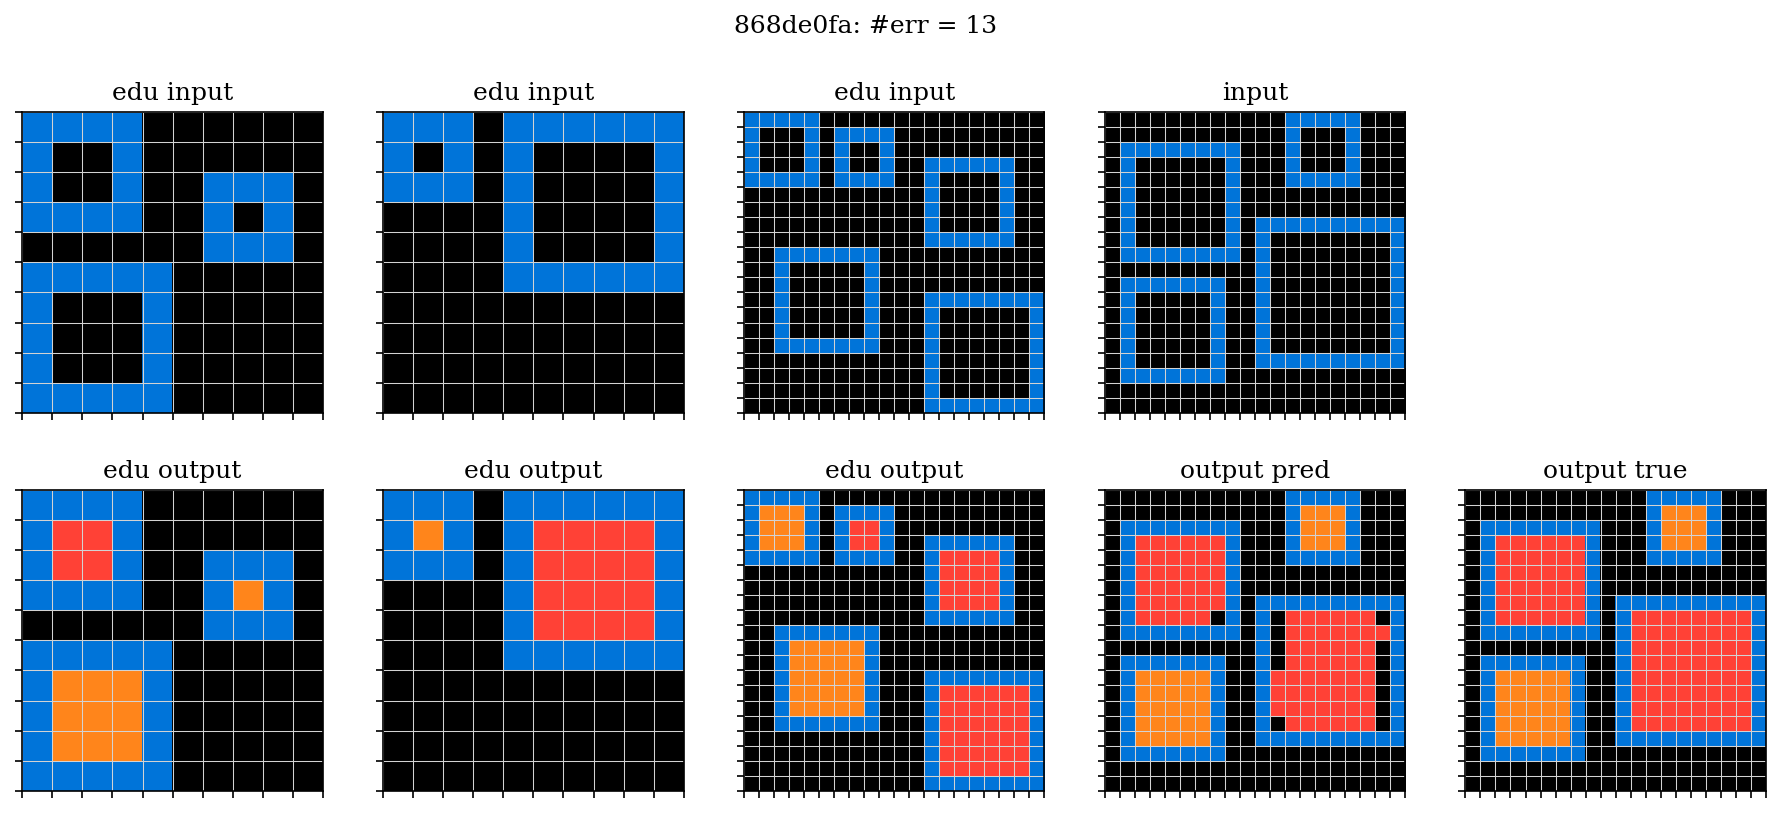

In [31]:
show_task_prediction(train_ids_train[44])

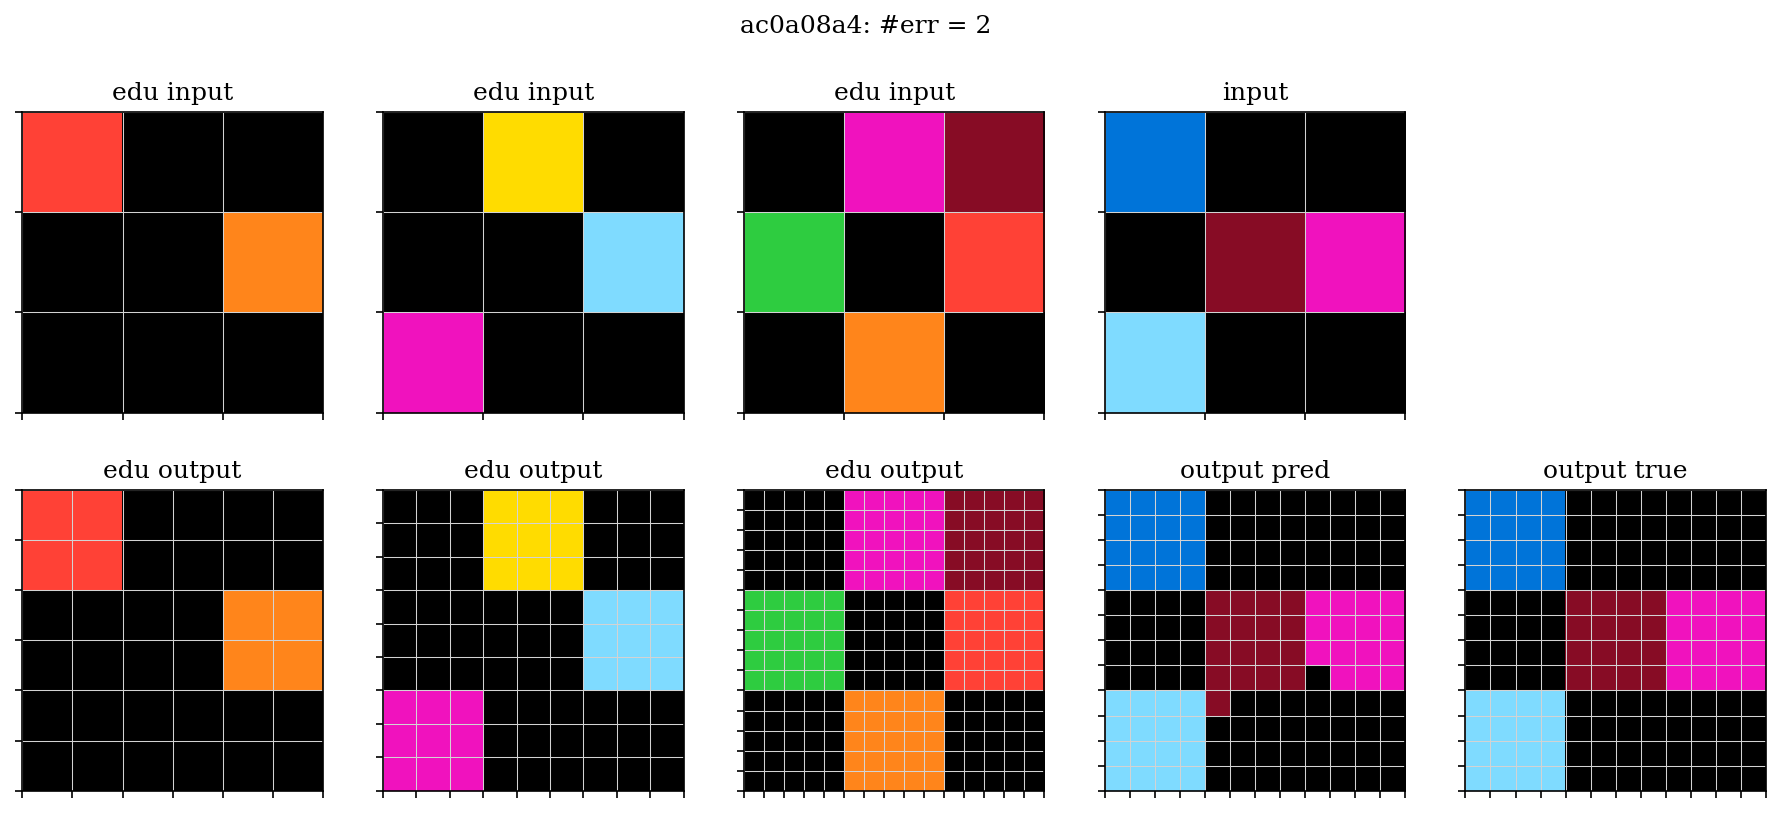

In [32]:
show_task_prediction(train_ids_train[45])

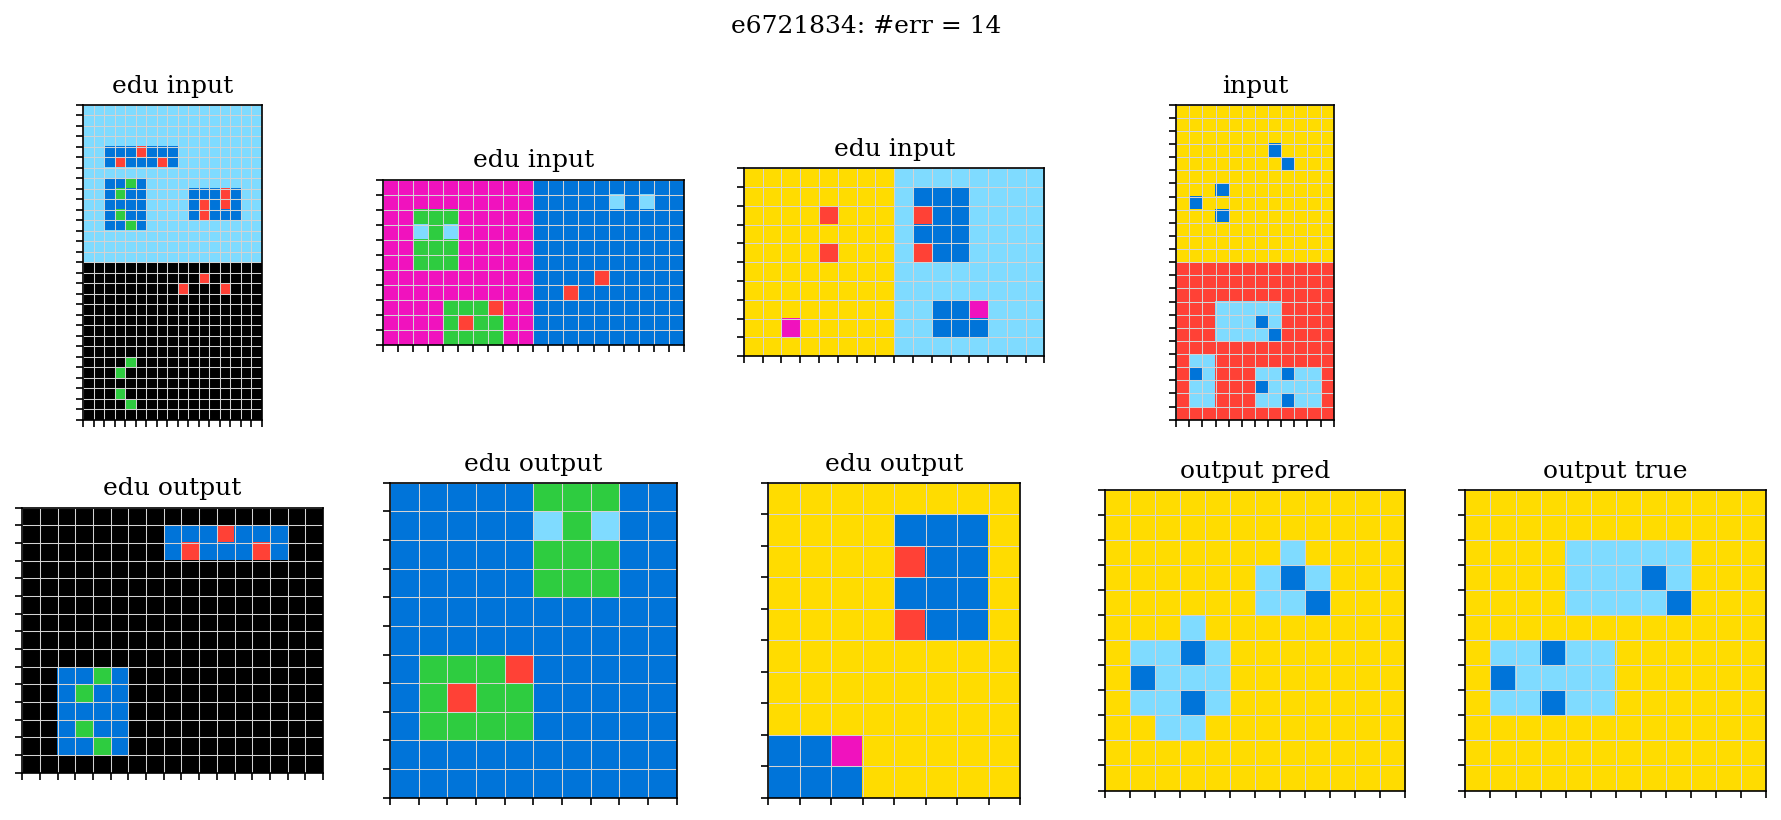

In [33]:
show_task_prediction(train_ids_train[48])

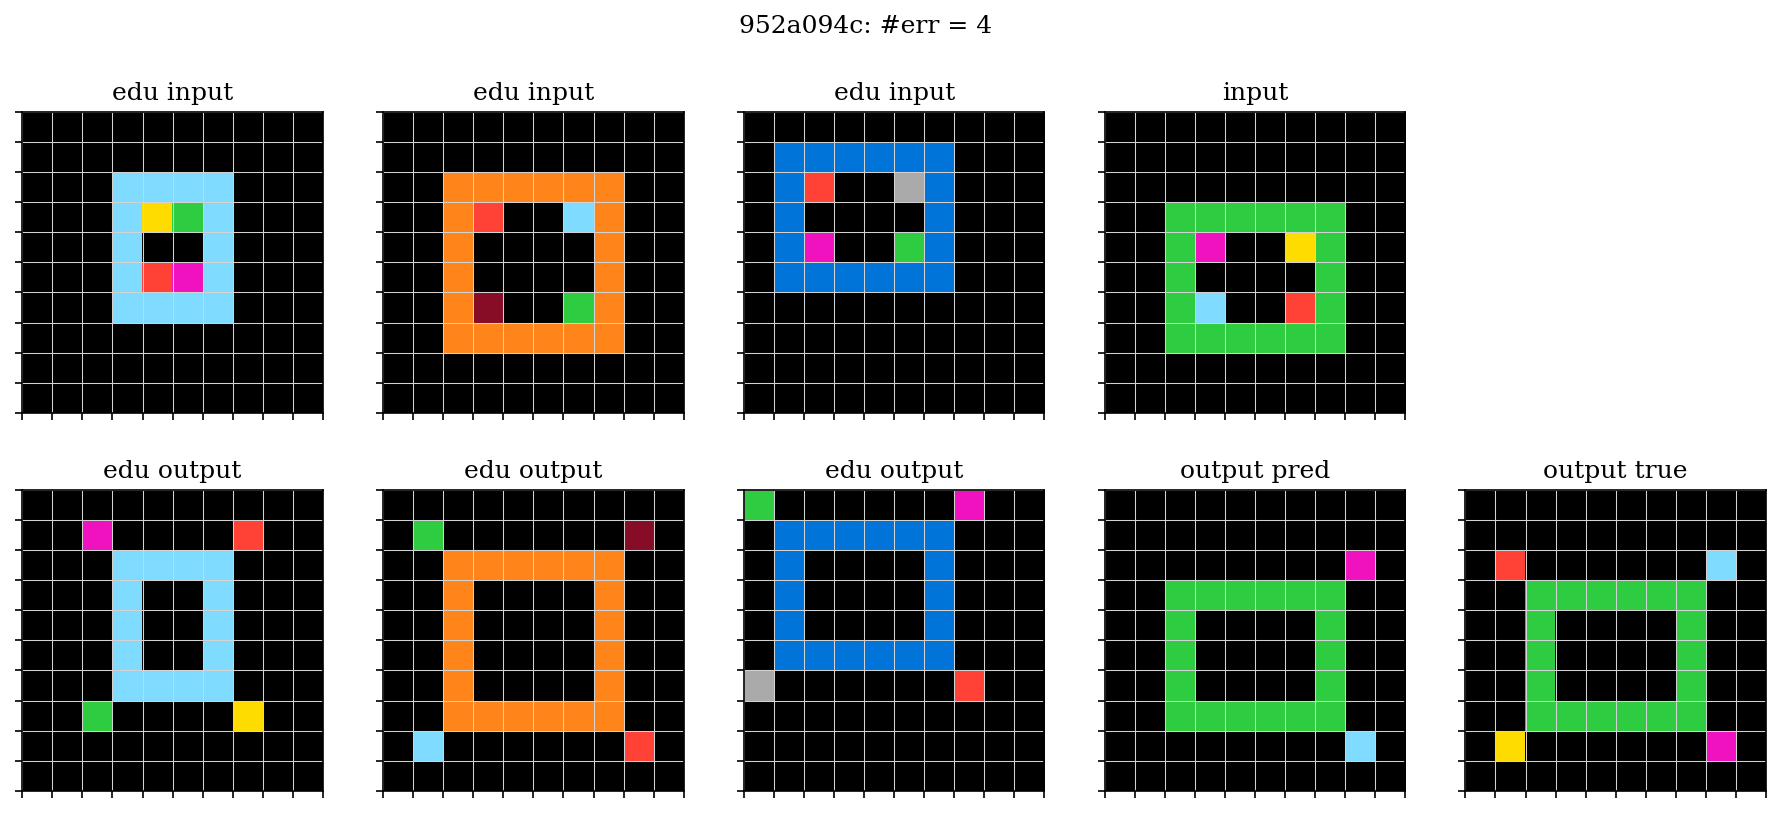

In [34]:
show_task_prediction(train_ids_train[53])

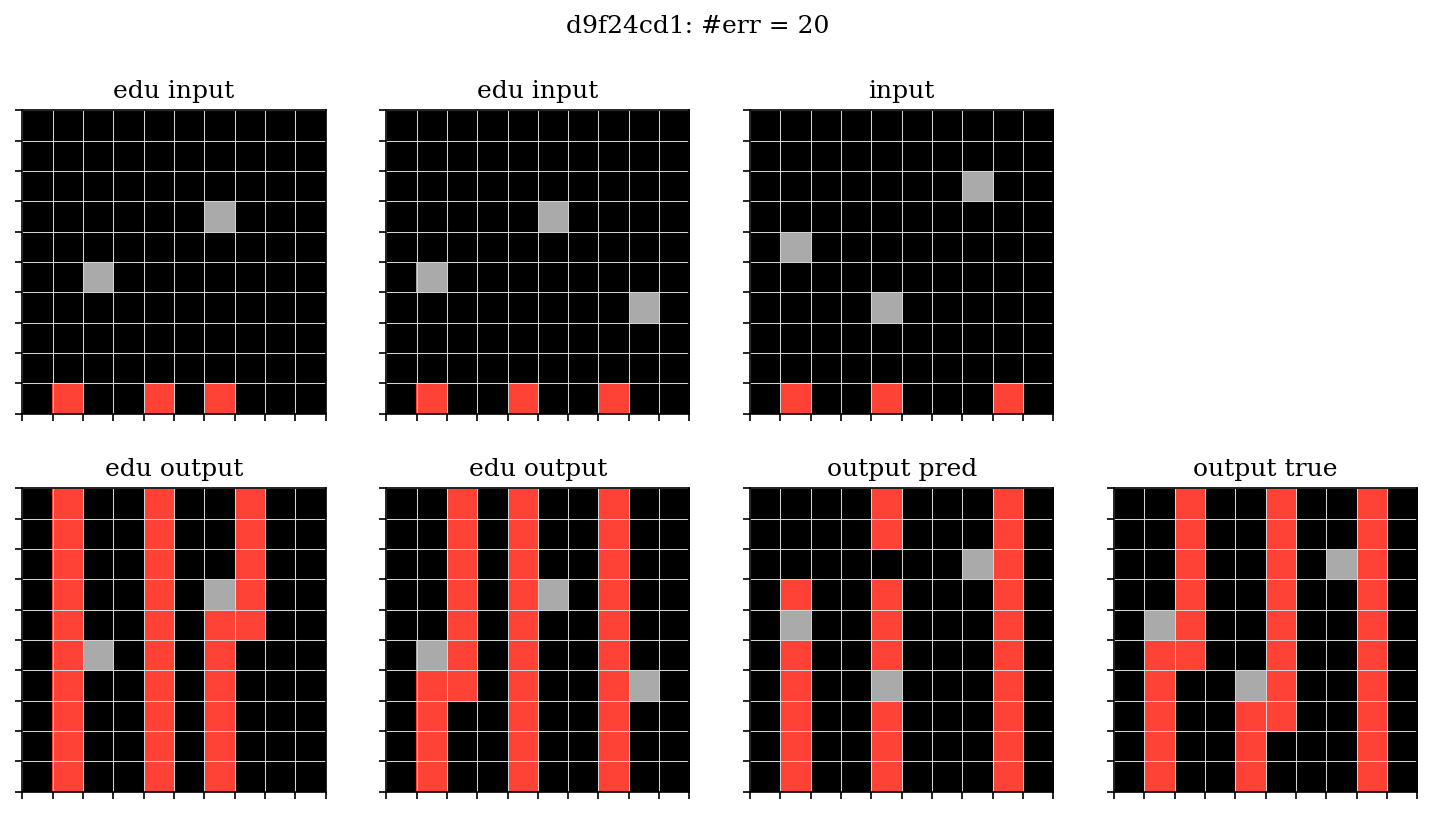

In [35]:
show_task_prediction(train_ids_train[55])

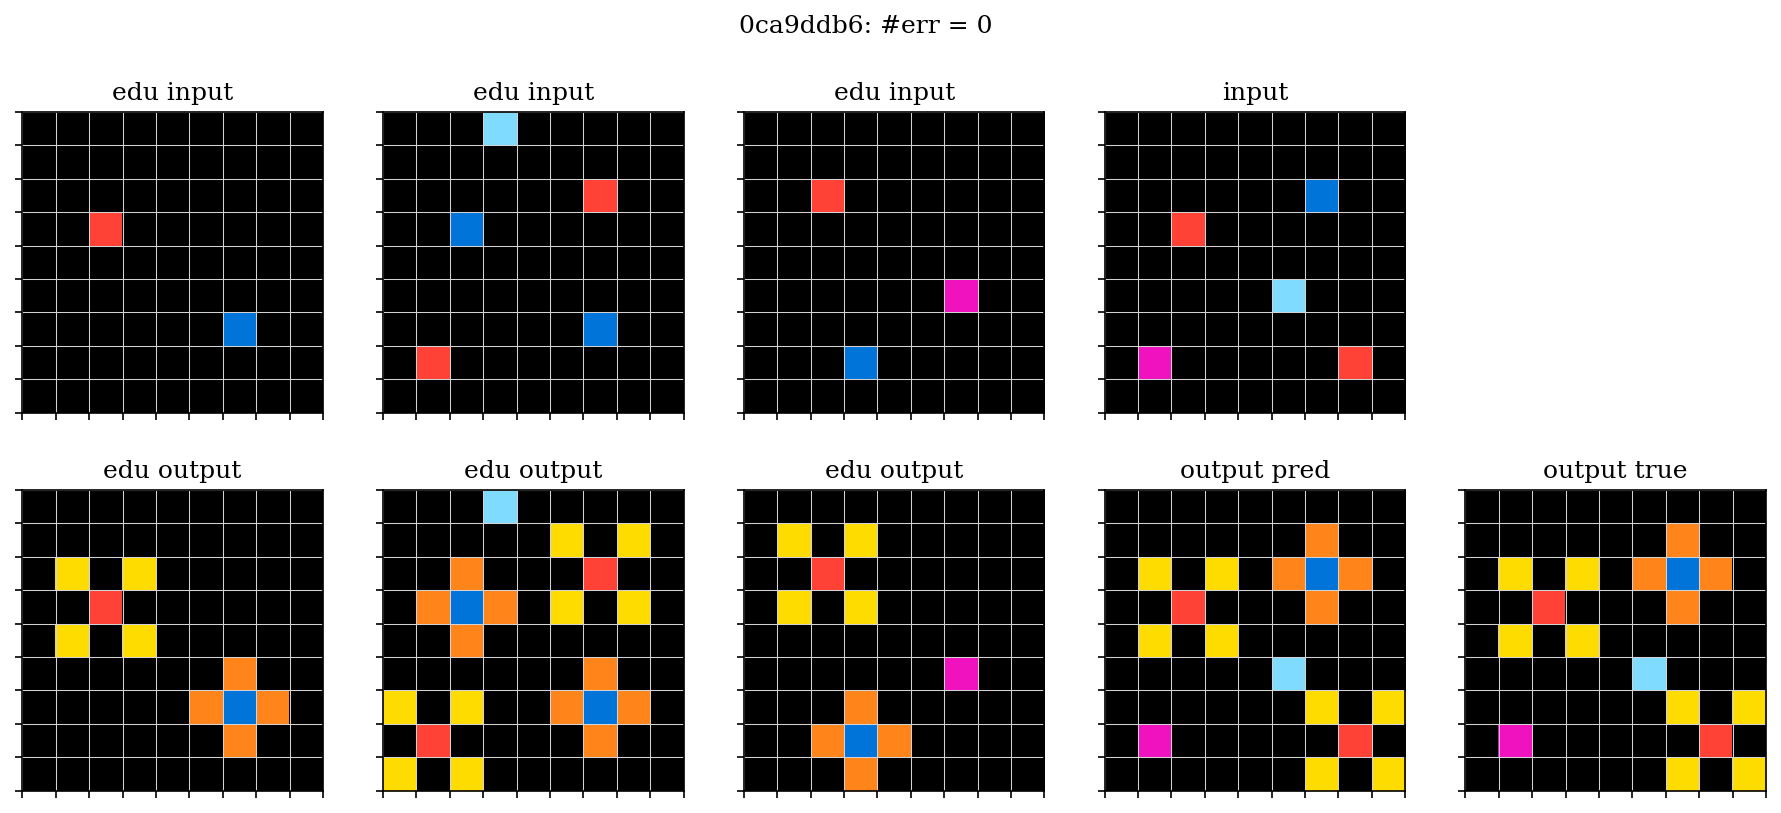

In [36]:
show_task_prediction(train_ids_train[56])

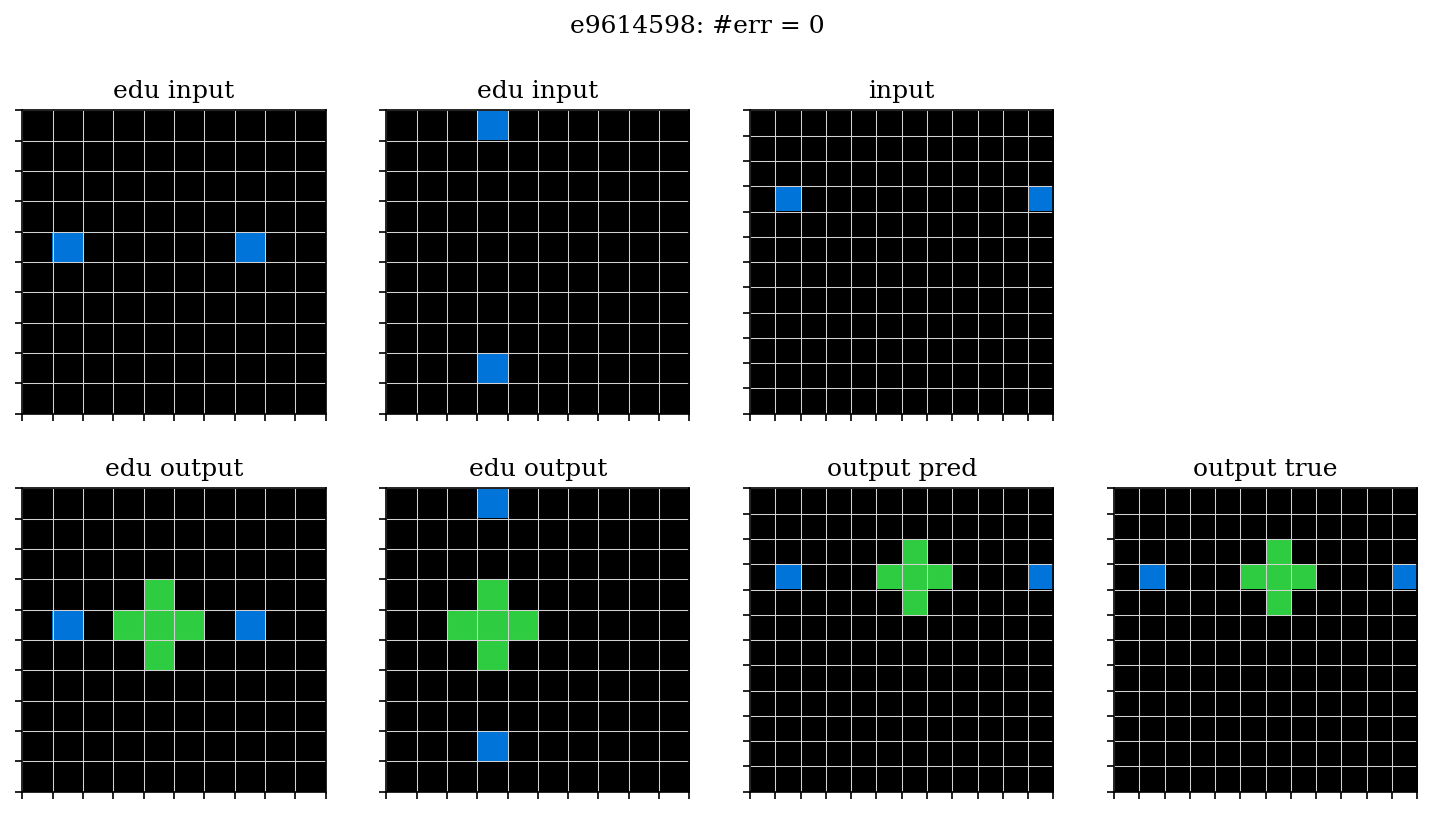

In [37]:
show_task_prediction(train_ids_train[57])

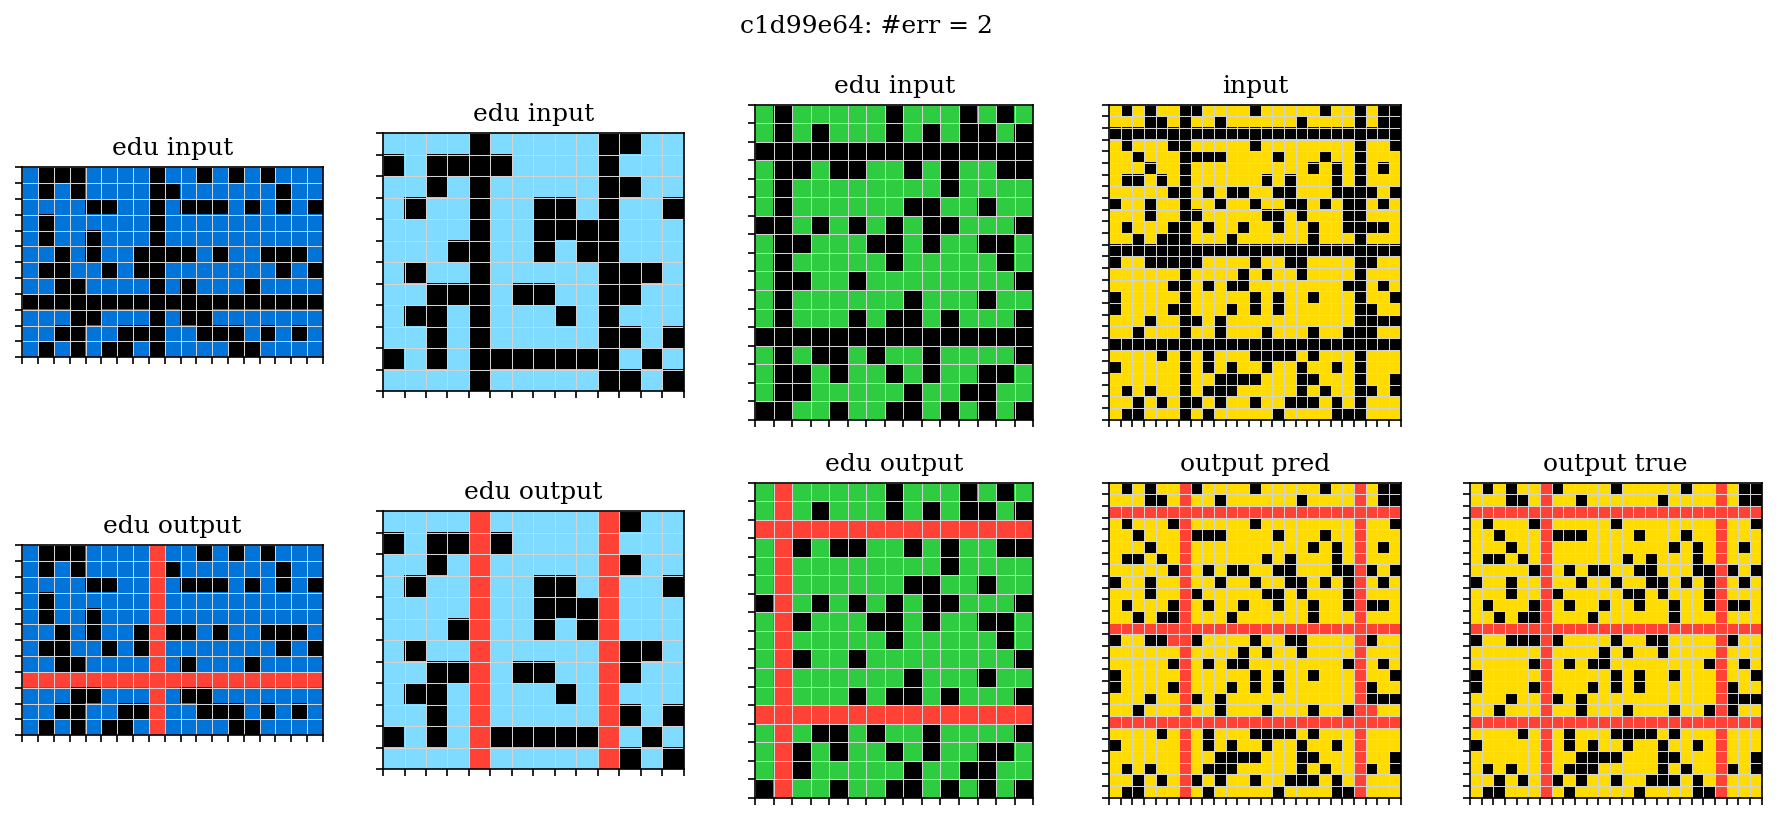

In [38]:
show_task_prediction(train_ids_train[62])

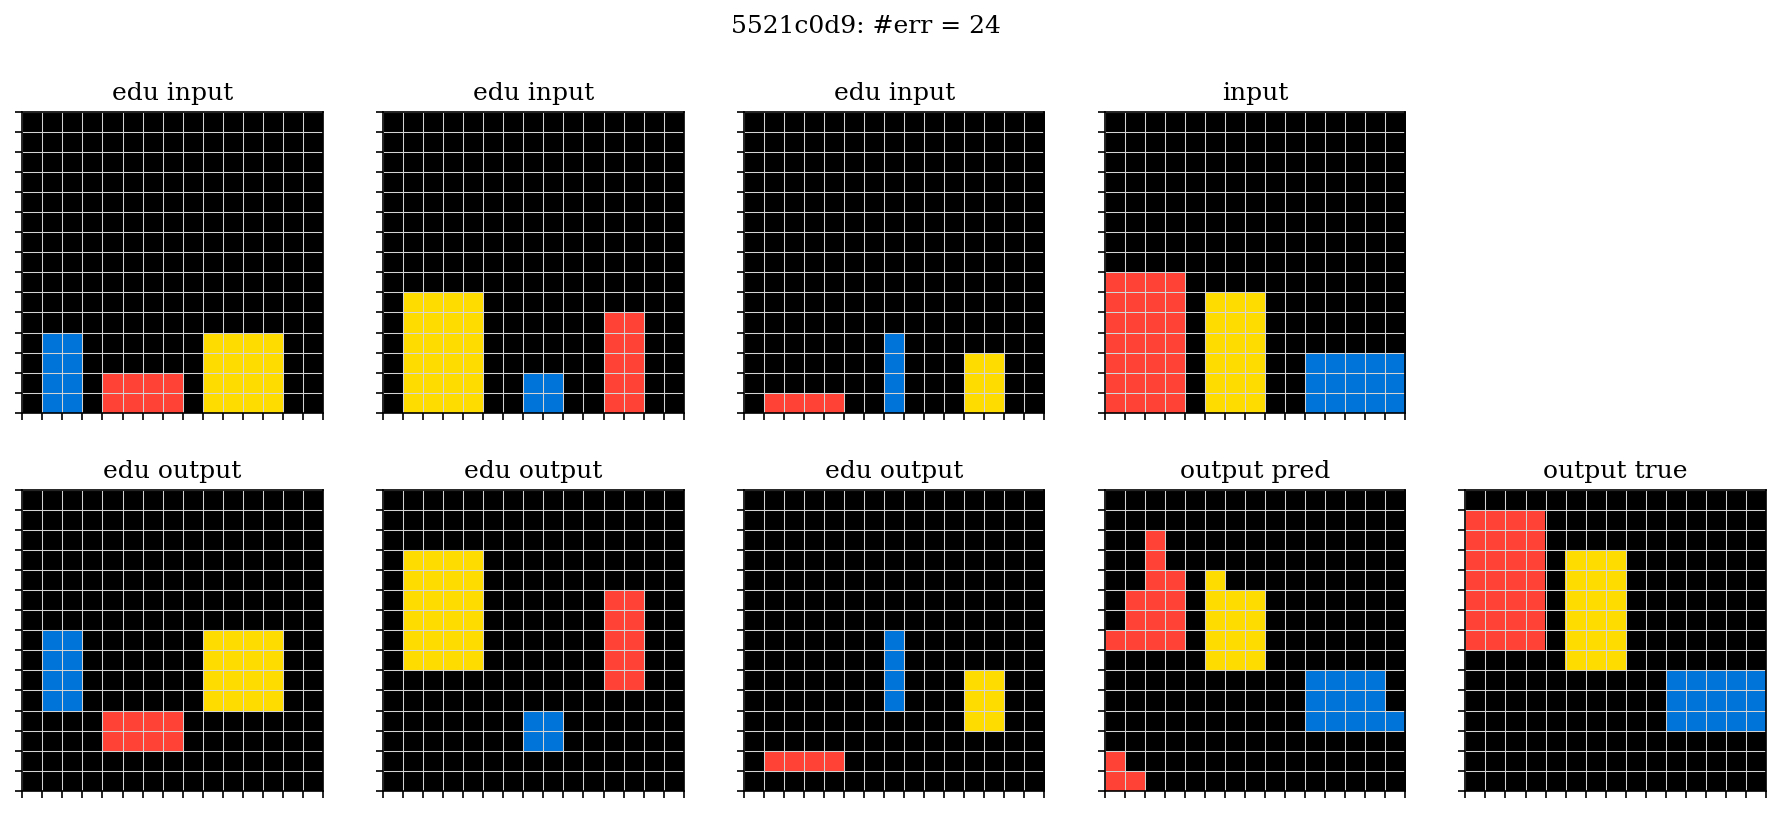

In [39]:
# right logic, not enoogh training for decoder
show_task_prediction(train_ids_train[66])

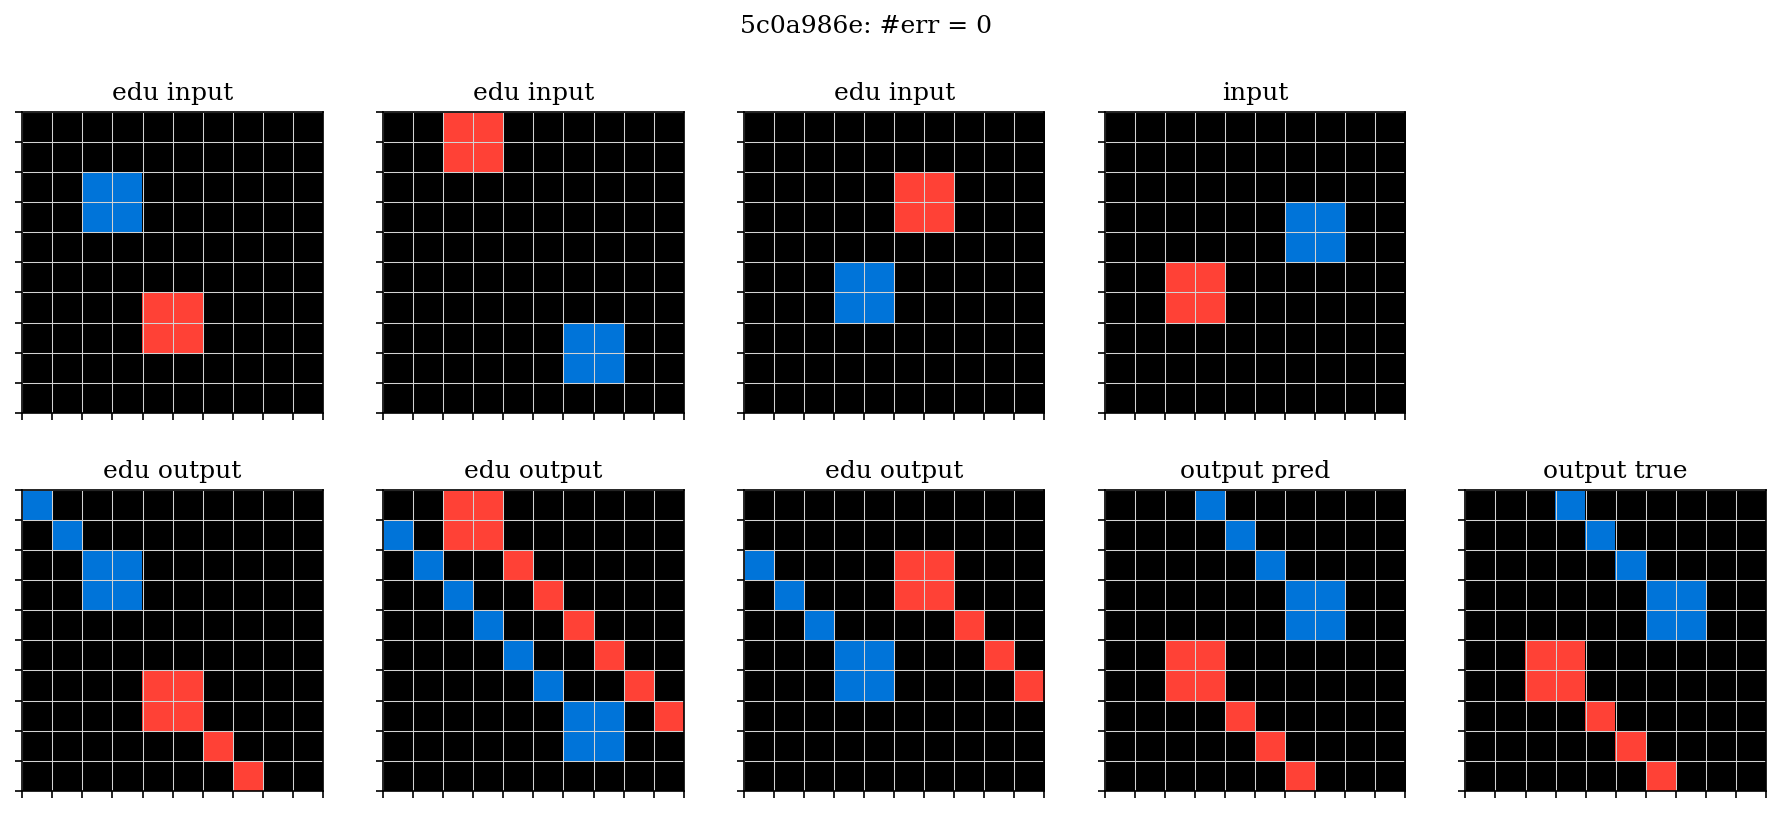

In [40]:
show_task_prediction(train_ids_train[68])

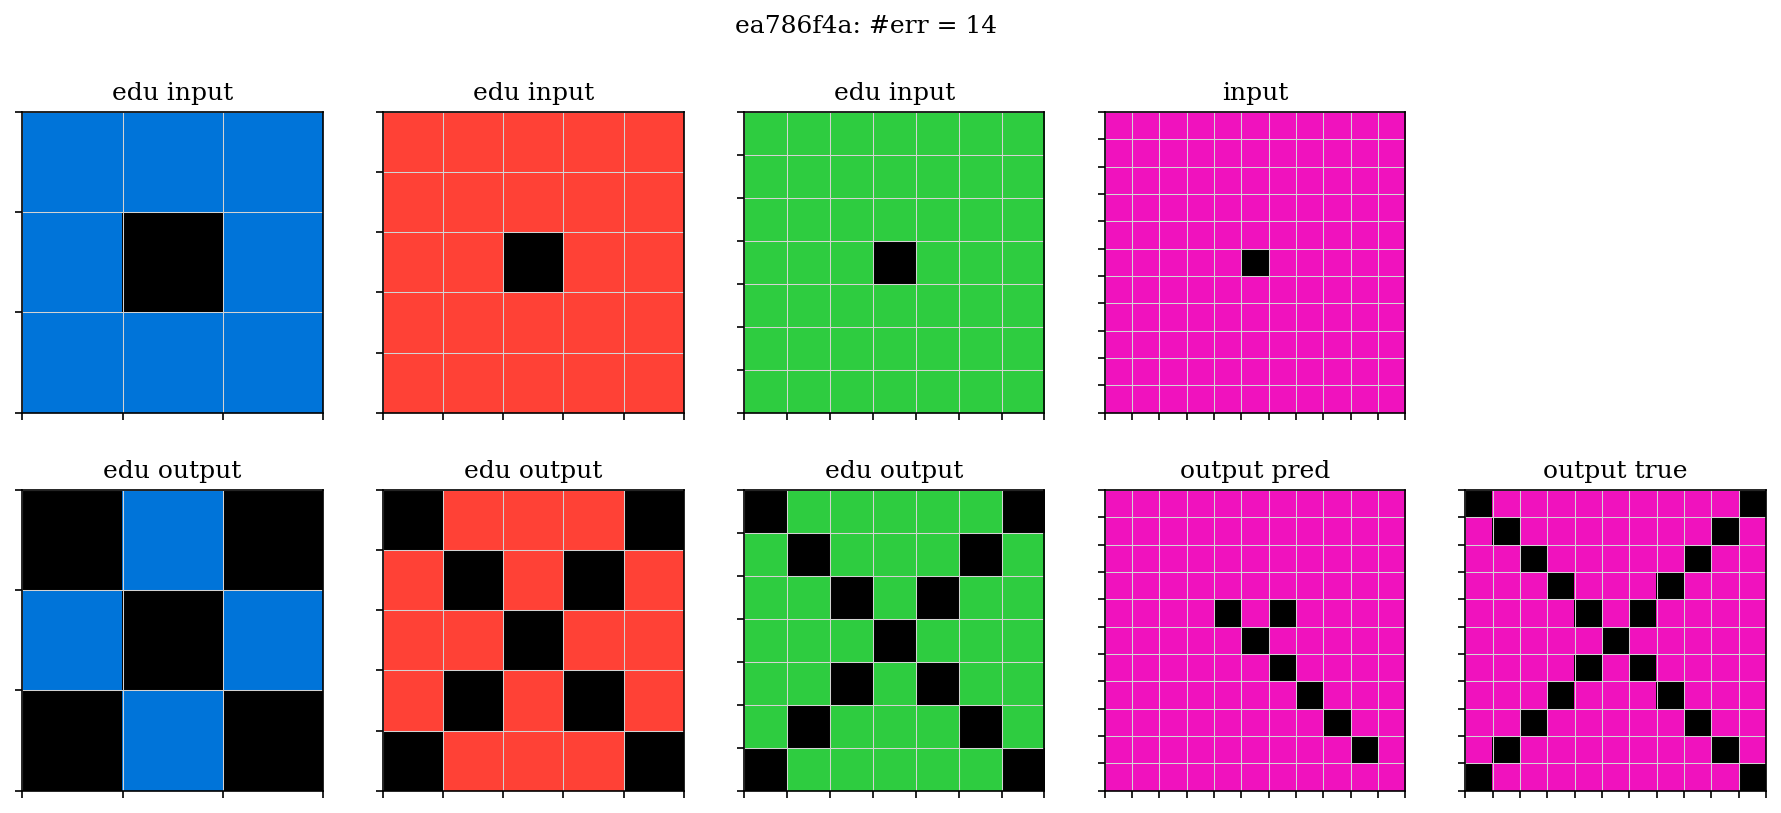

In [41]:
show_task_prediction(train_ids_train[69])

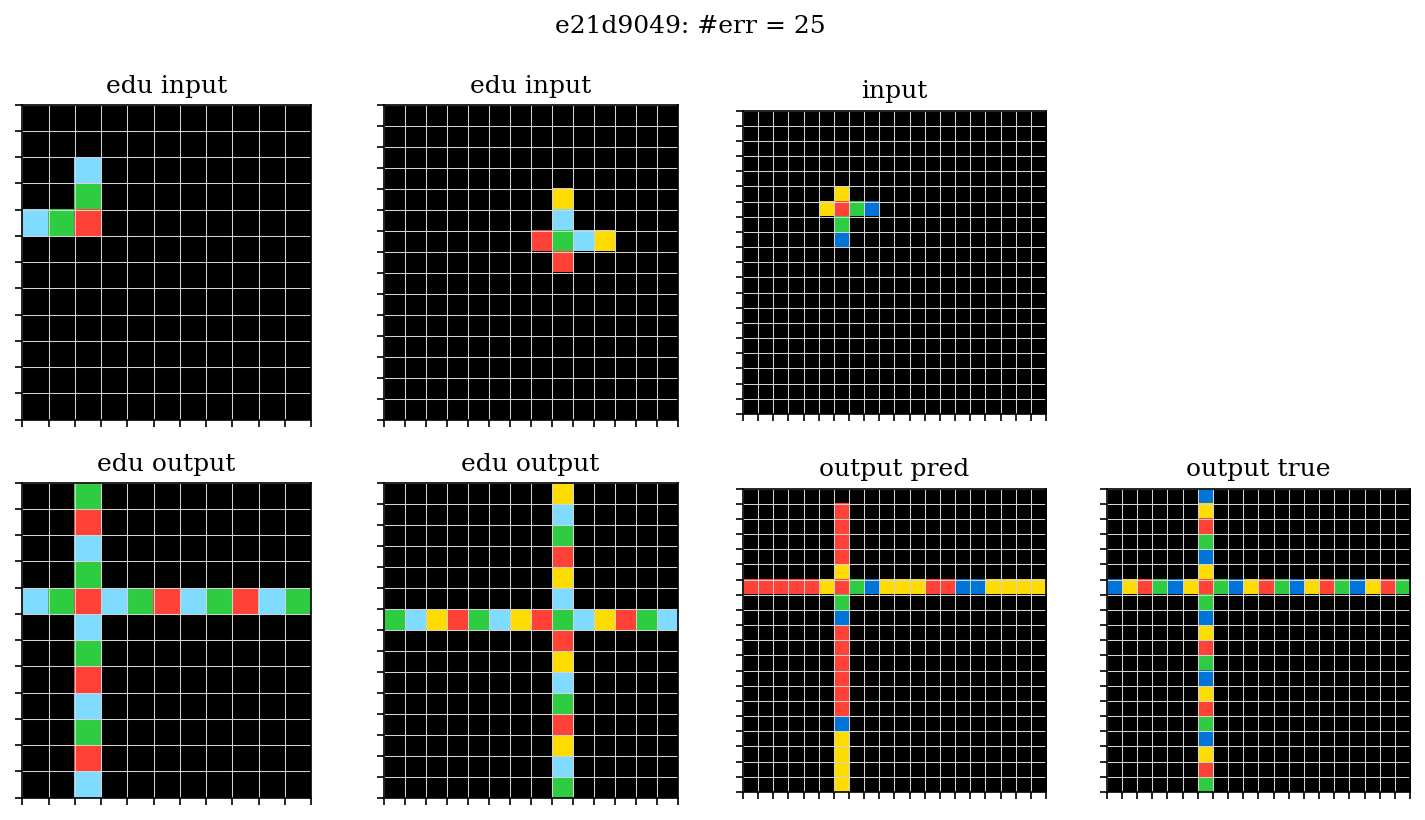

In [42]:
show_task_prediction(train_ids_train[70])

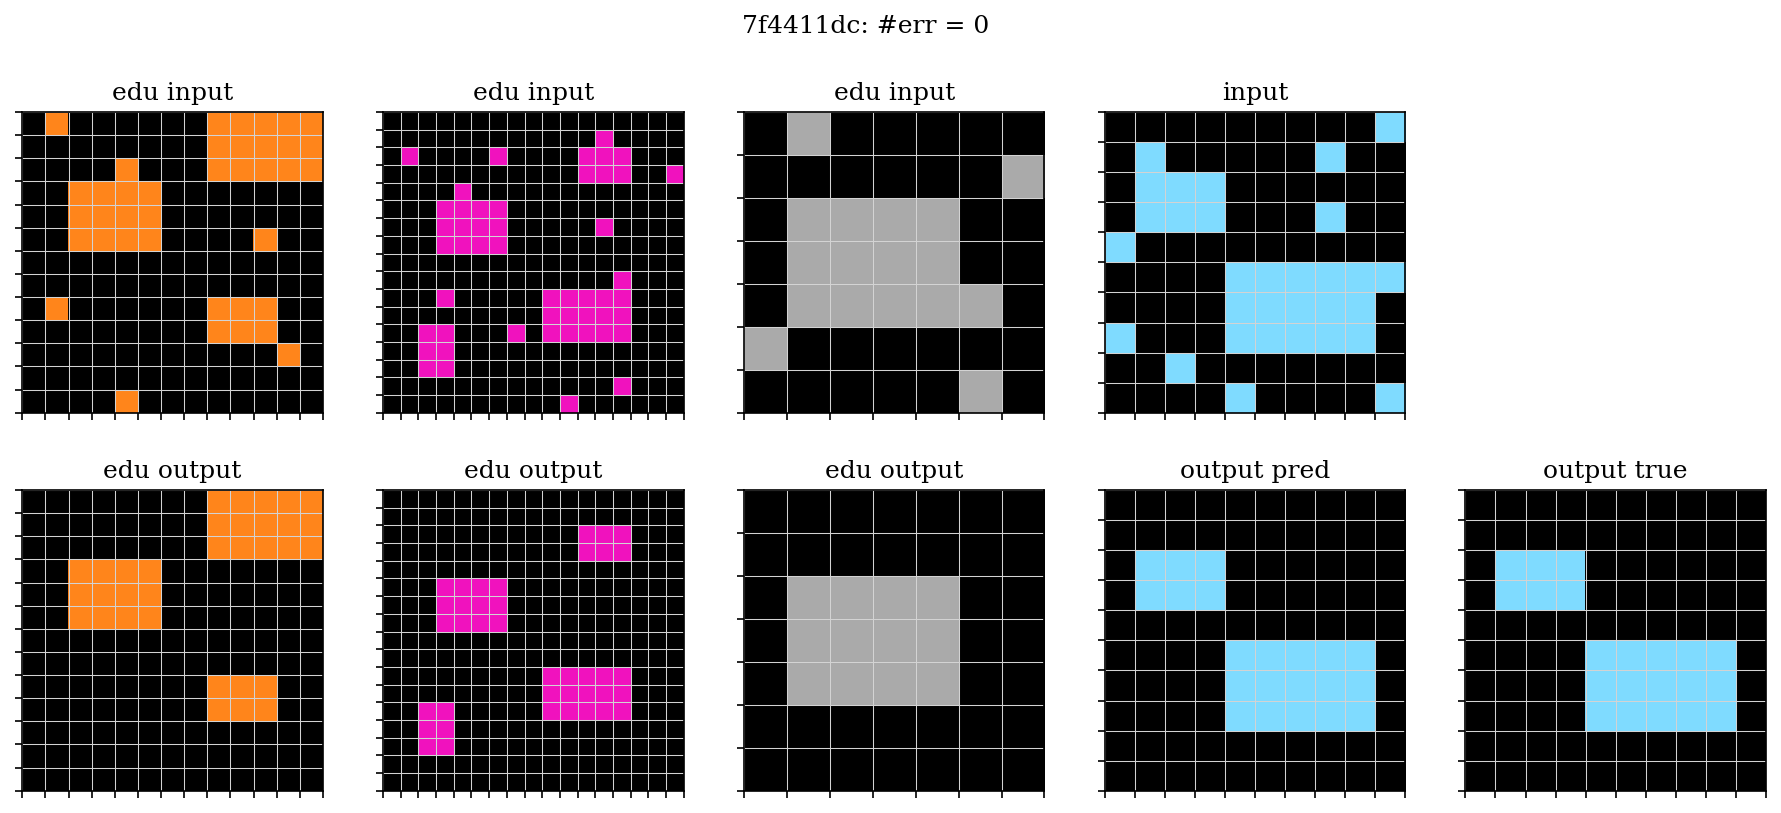

In [43]:
show_task_prediction(train_ids_train[72])

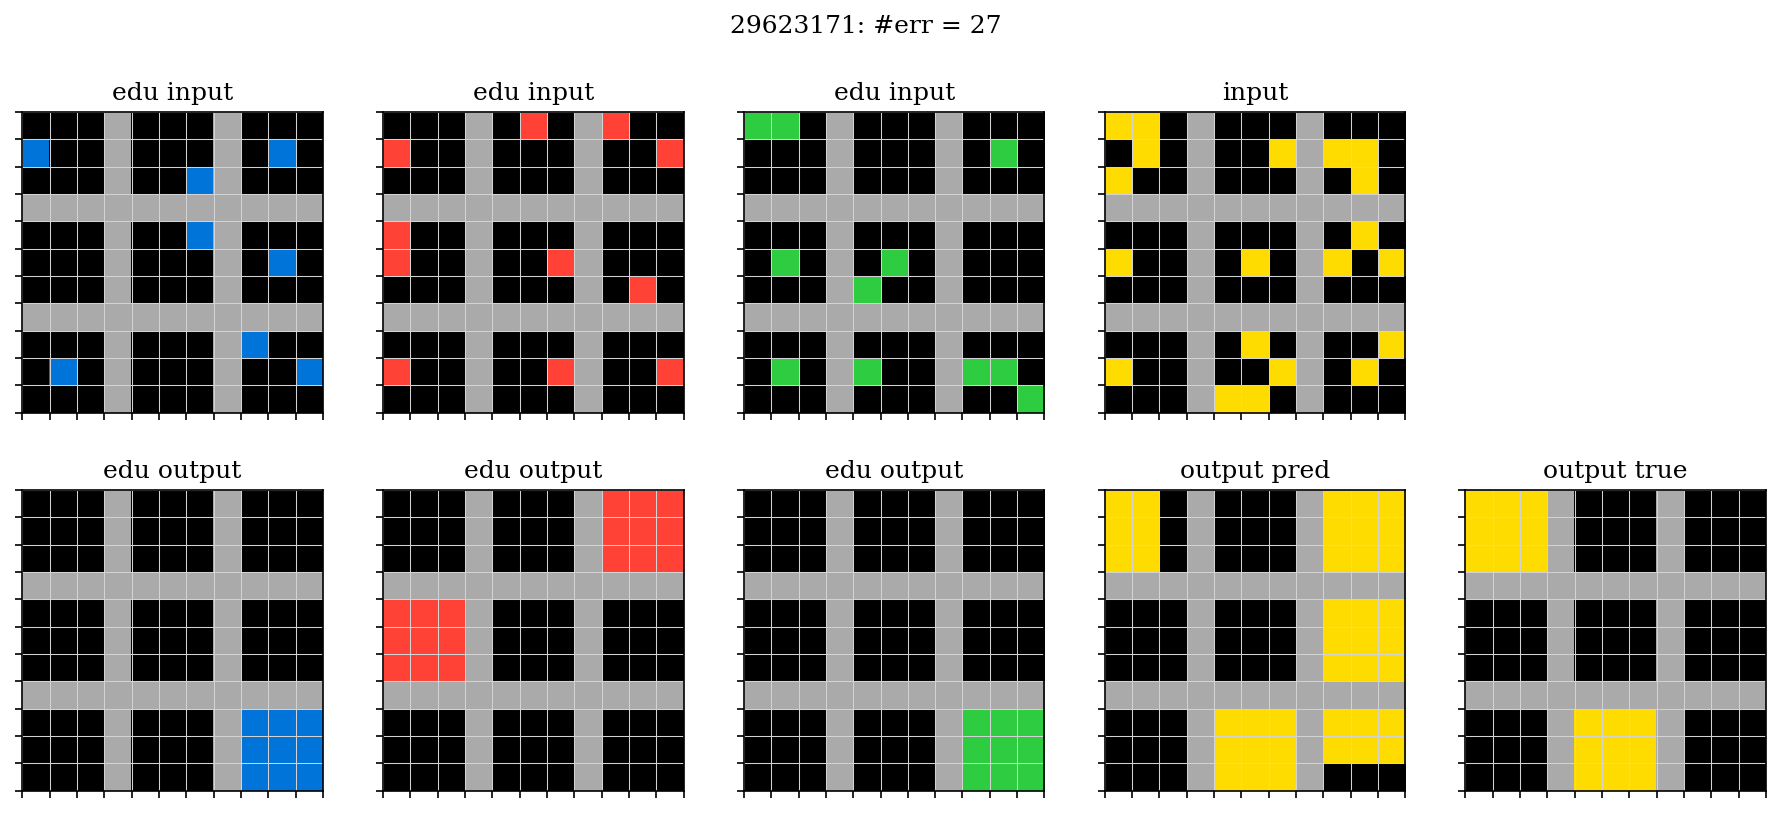

In [44]:
show_task_prediction(train_ids_train[74])

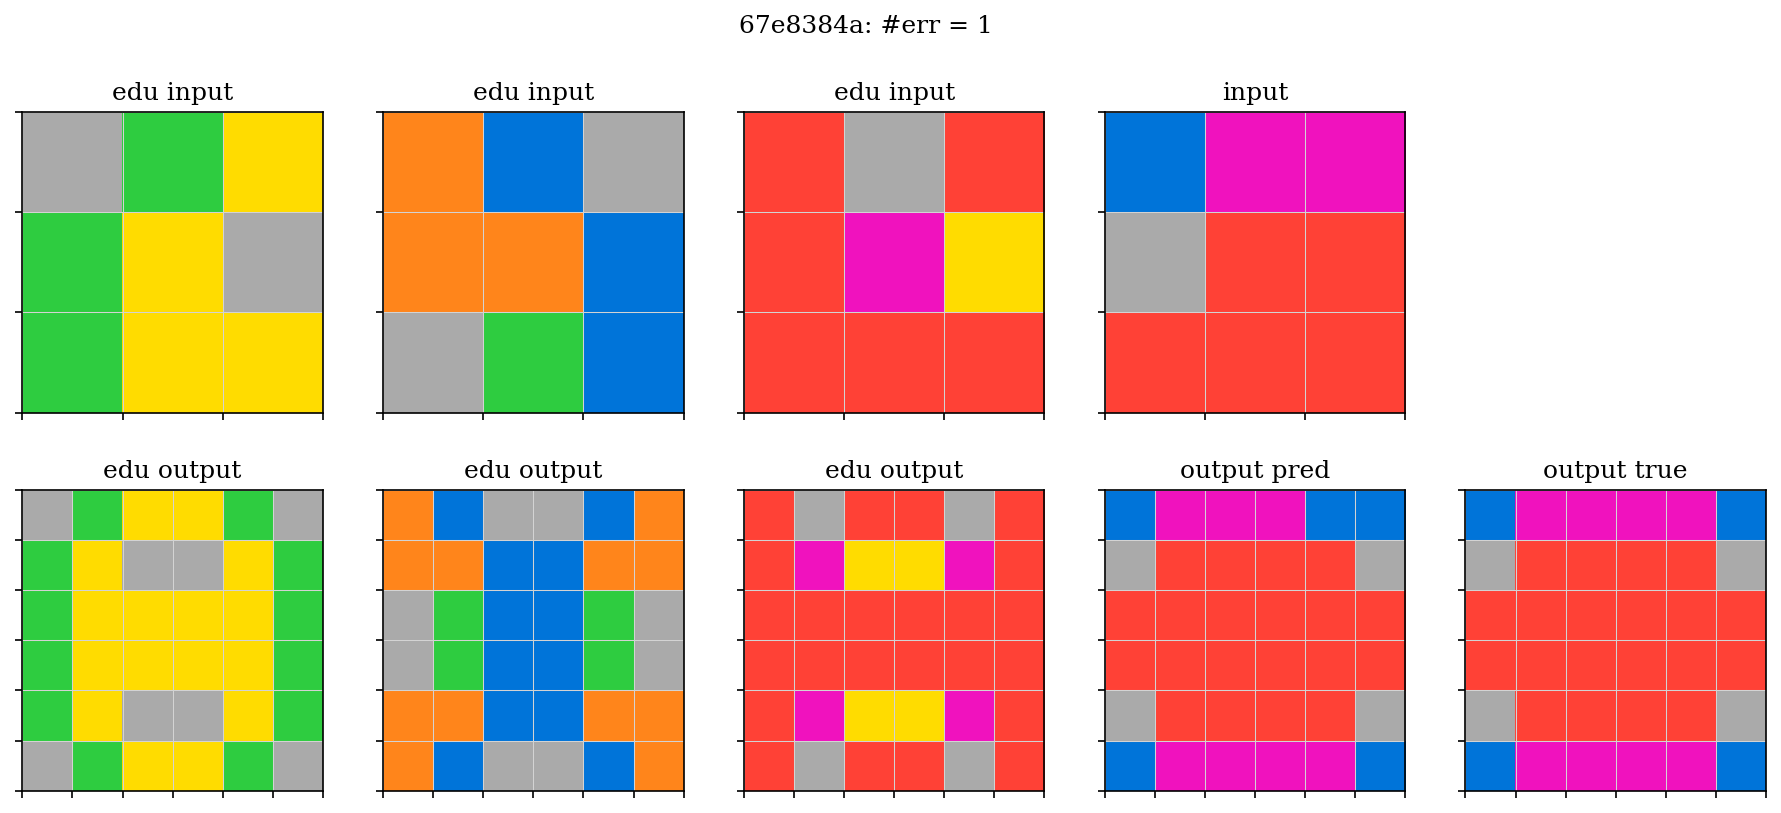

In [45]:
show_task_prediction(train_ids_train[76])

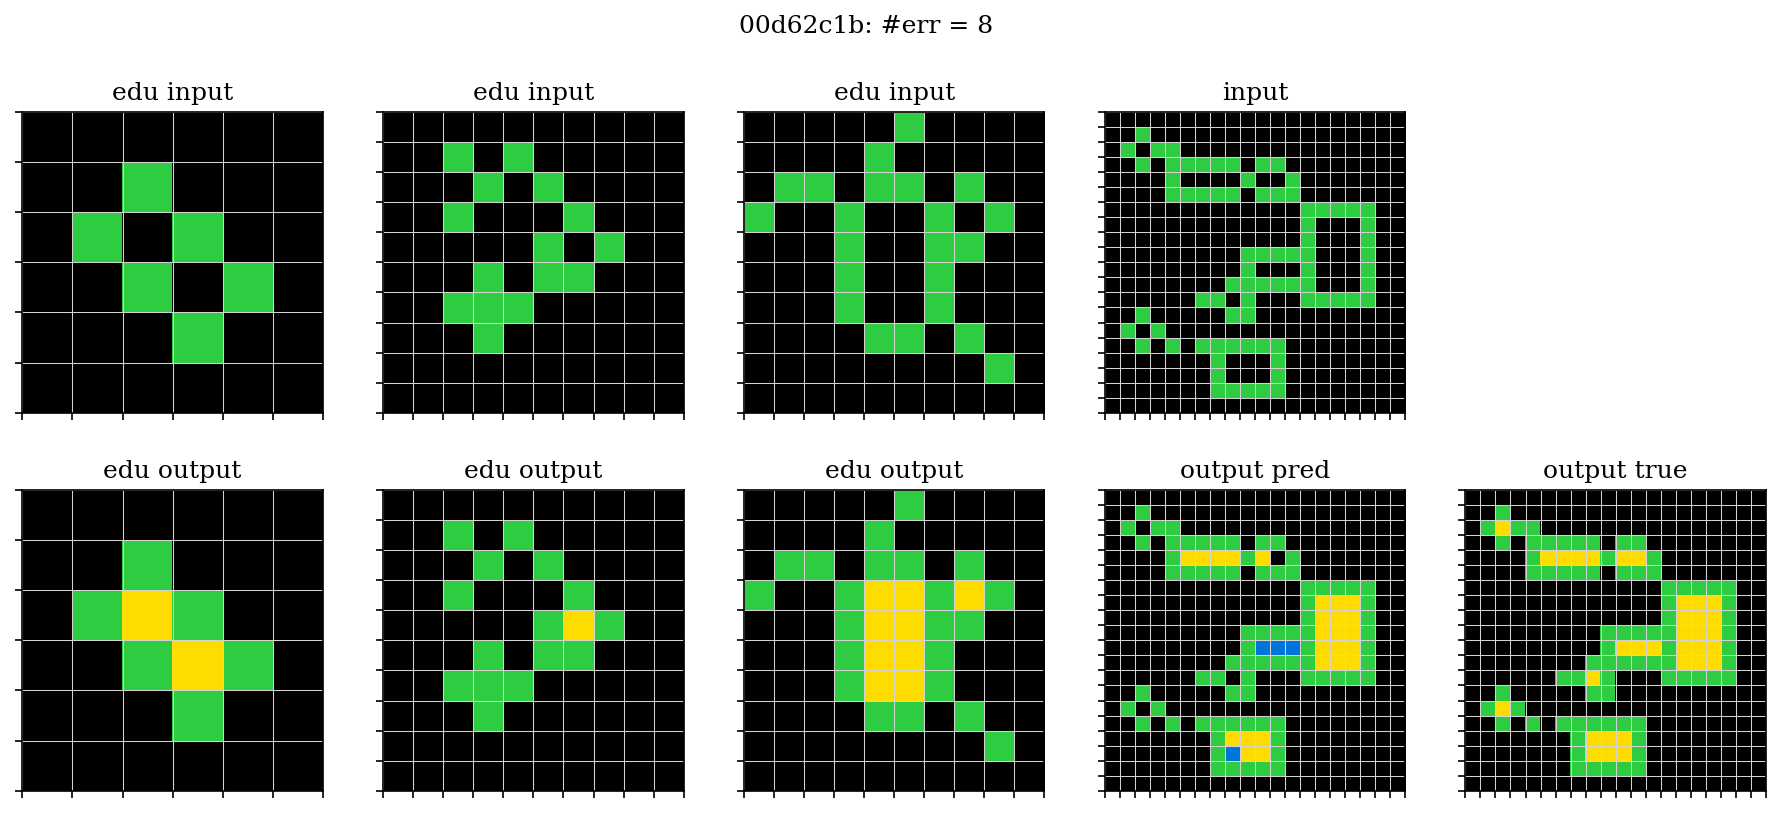

In [46]:
show_task_prediction(train_ids_train[77])

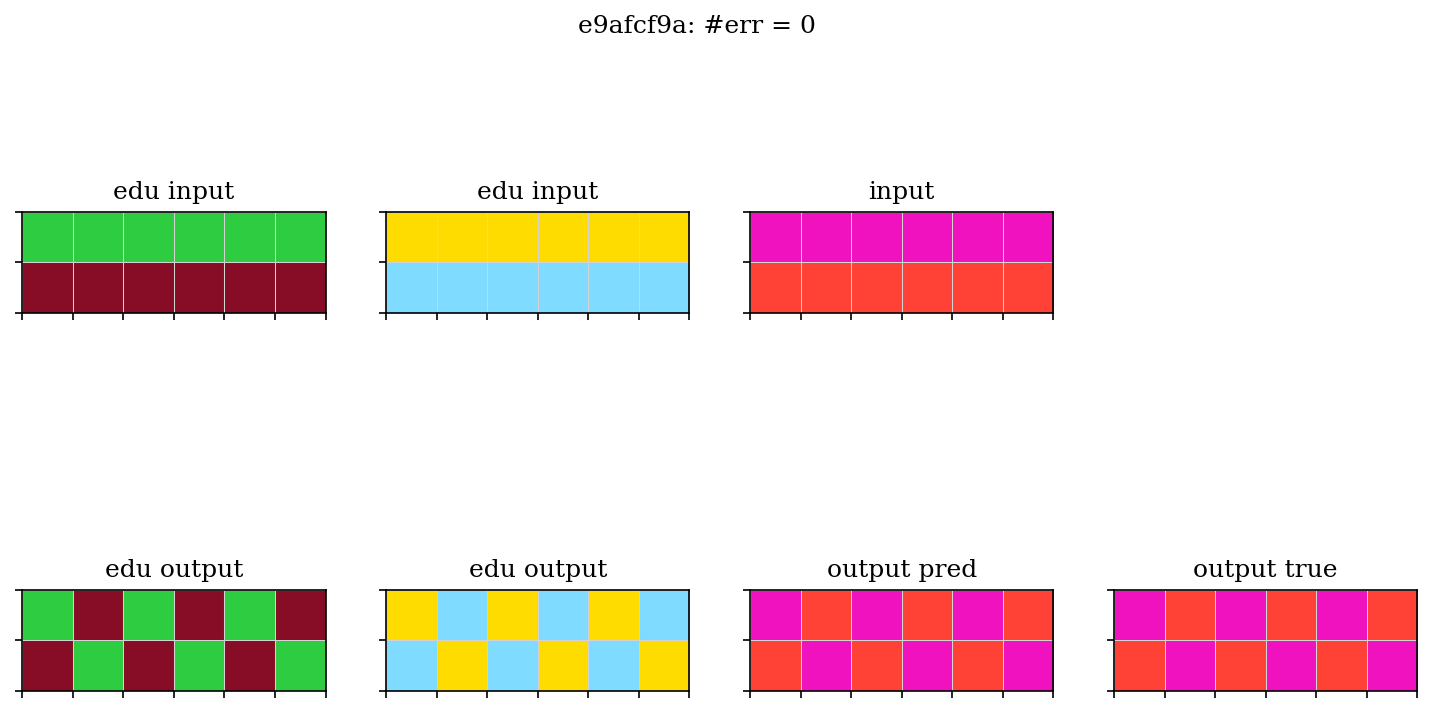

In [47]:
show_task_prediction(train_ids_train[79])

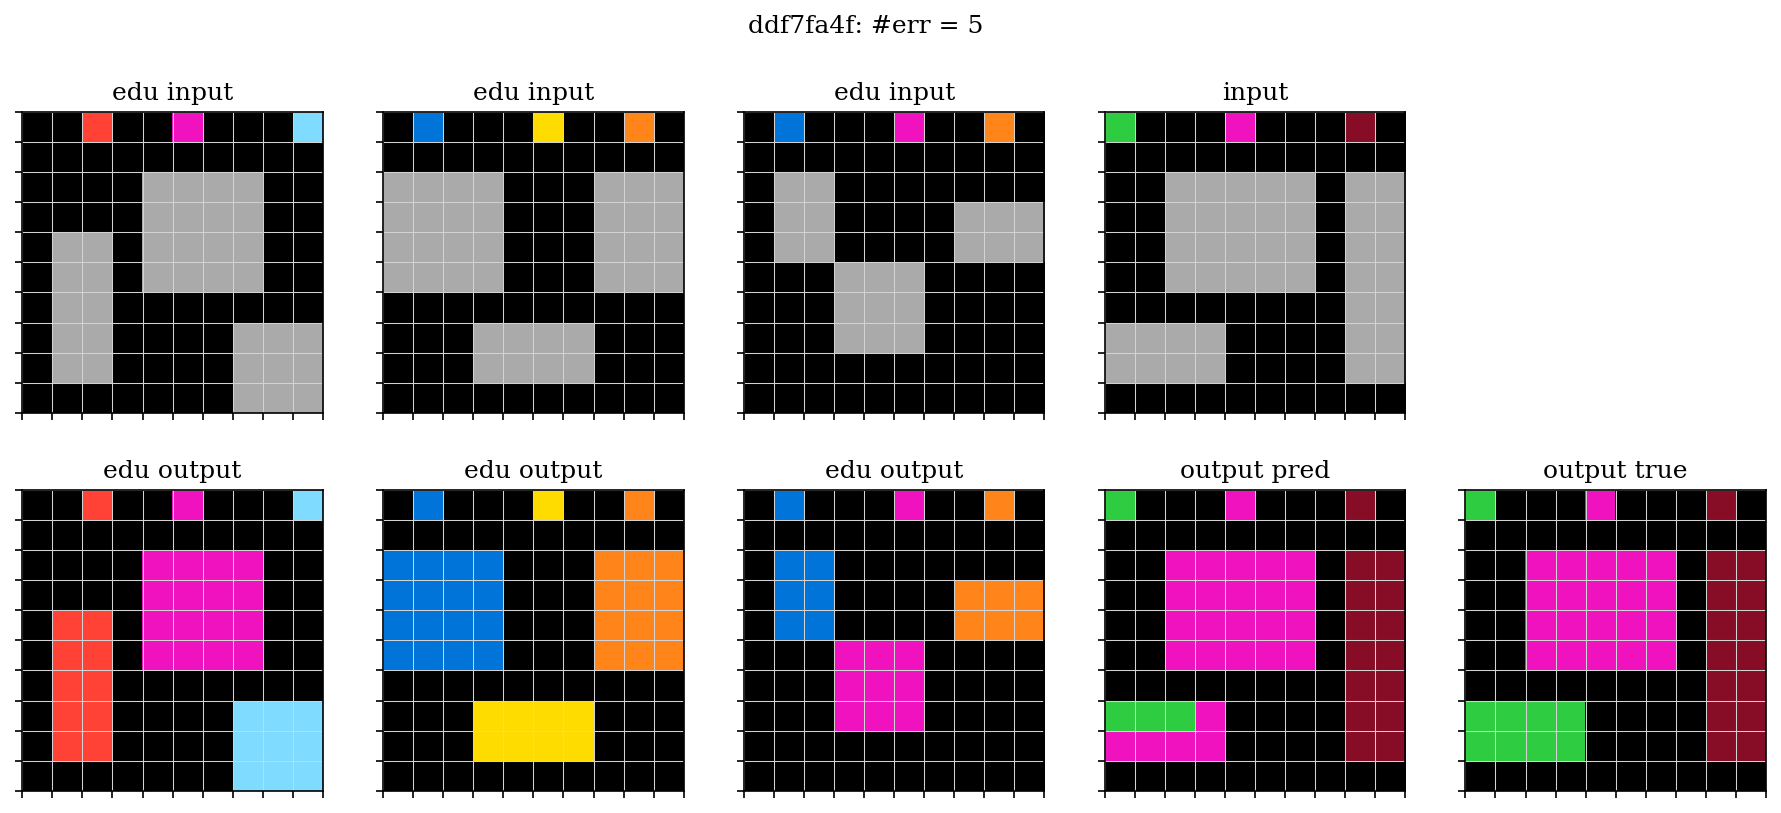

In [48]:
# funny mistakes
show_task_prediction(train_ids_train[81])

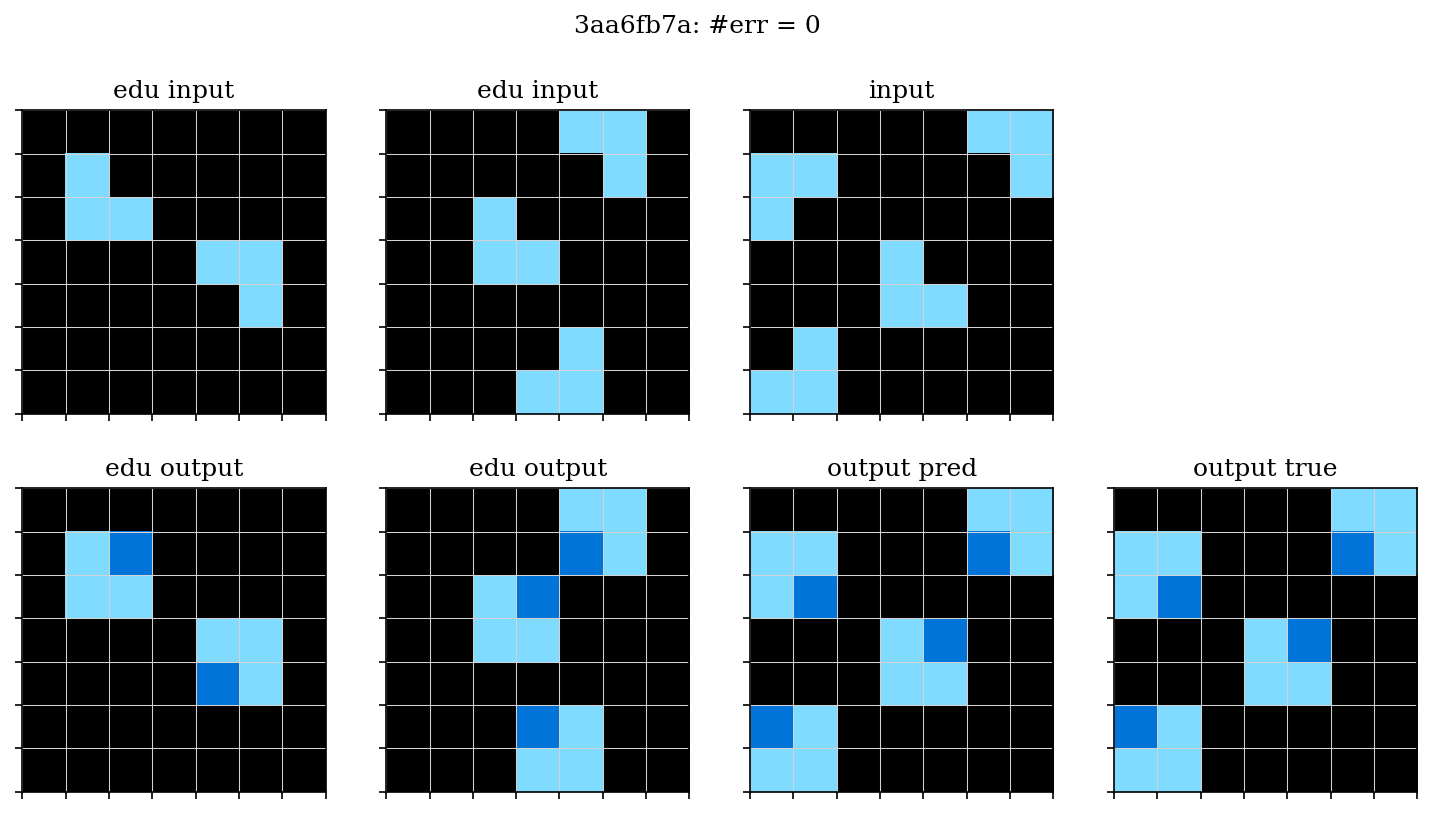

In [49]:
show_task_prediction(train_ids_train[84])

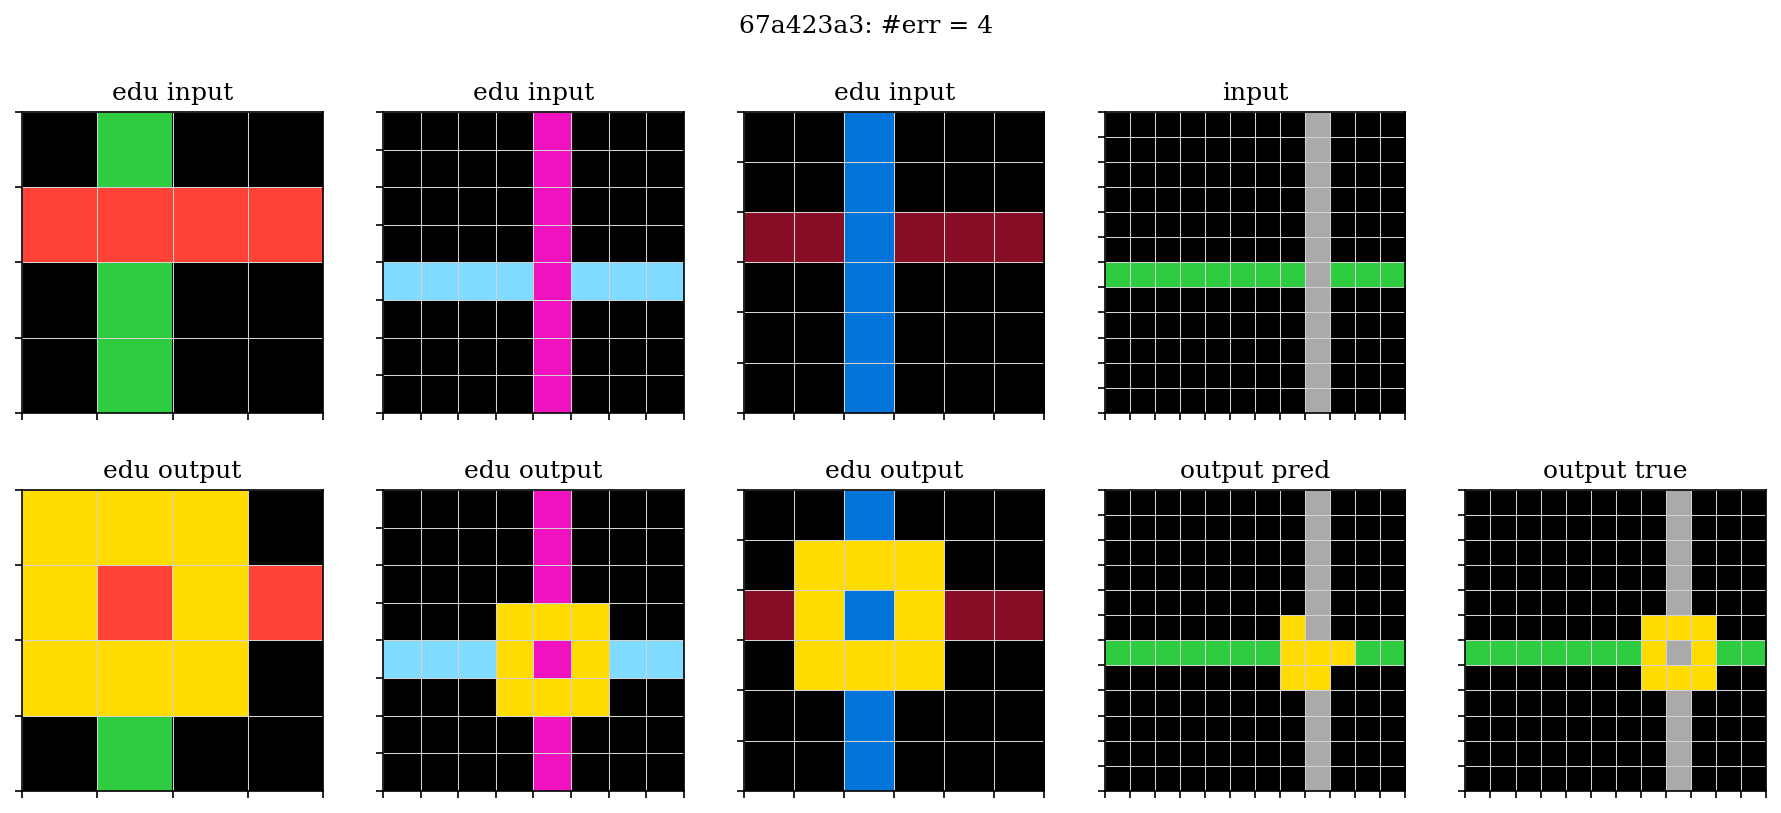

In [50]:
show_task_prediction(train_ids_train[85])

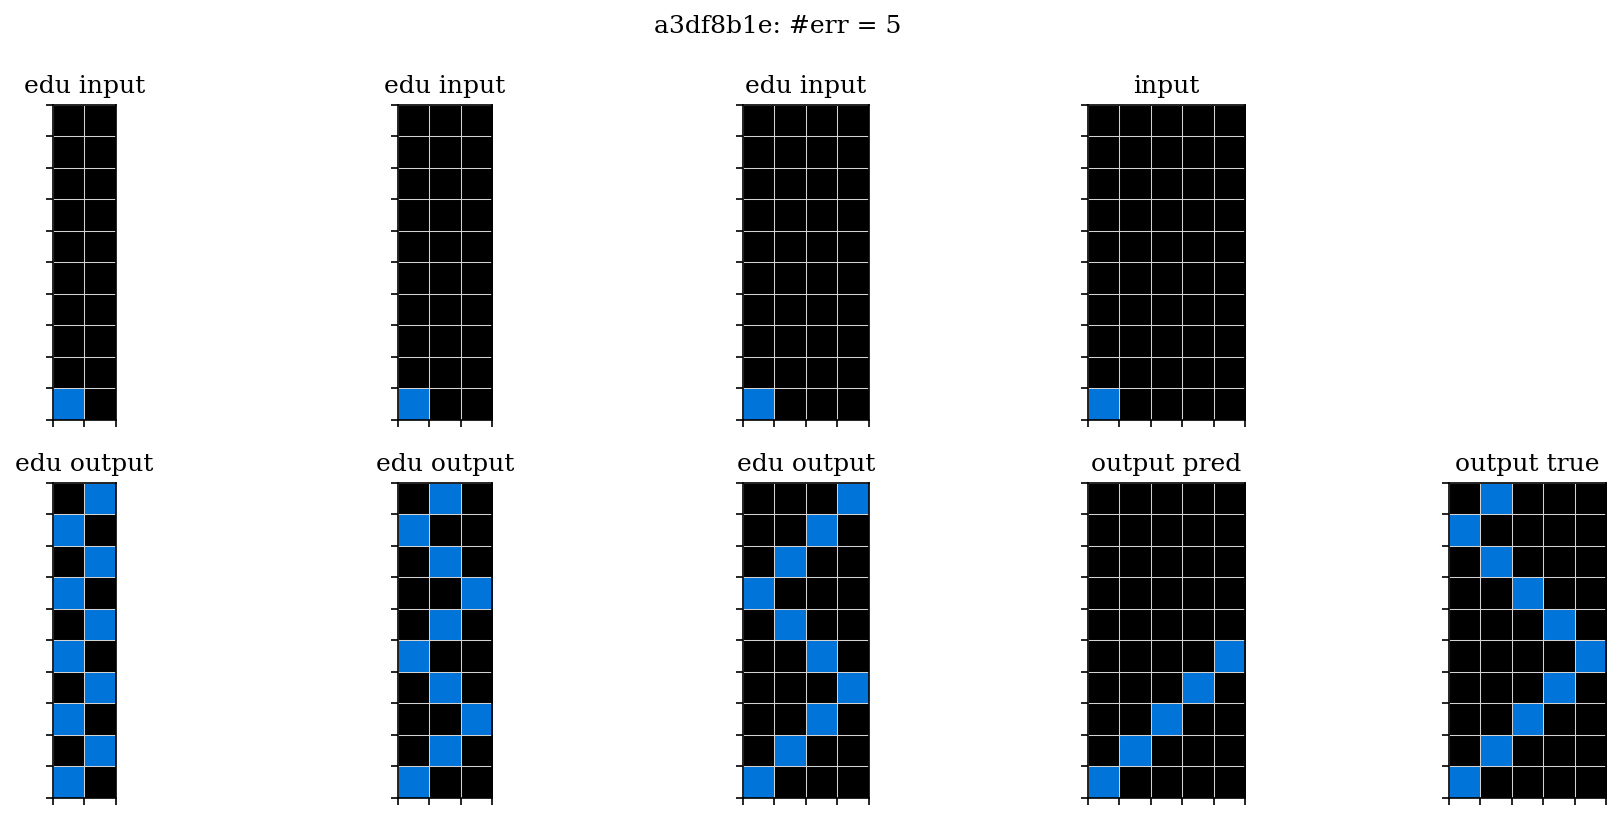

In [51]:
show_task_prediction(train_ids_train[86])

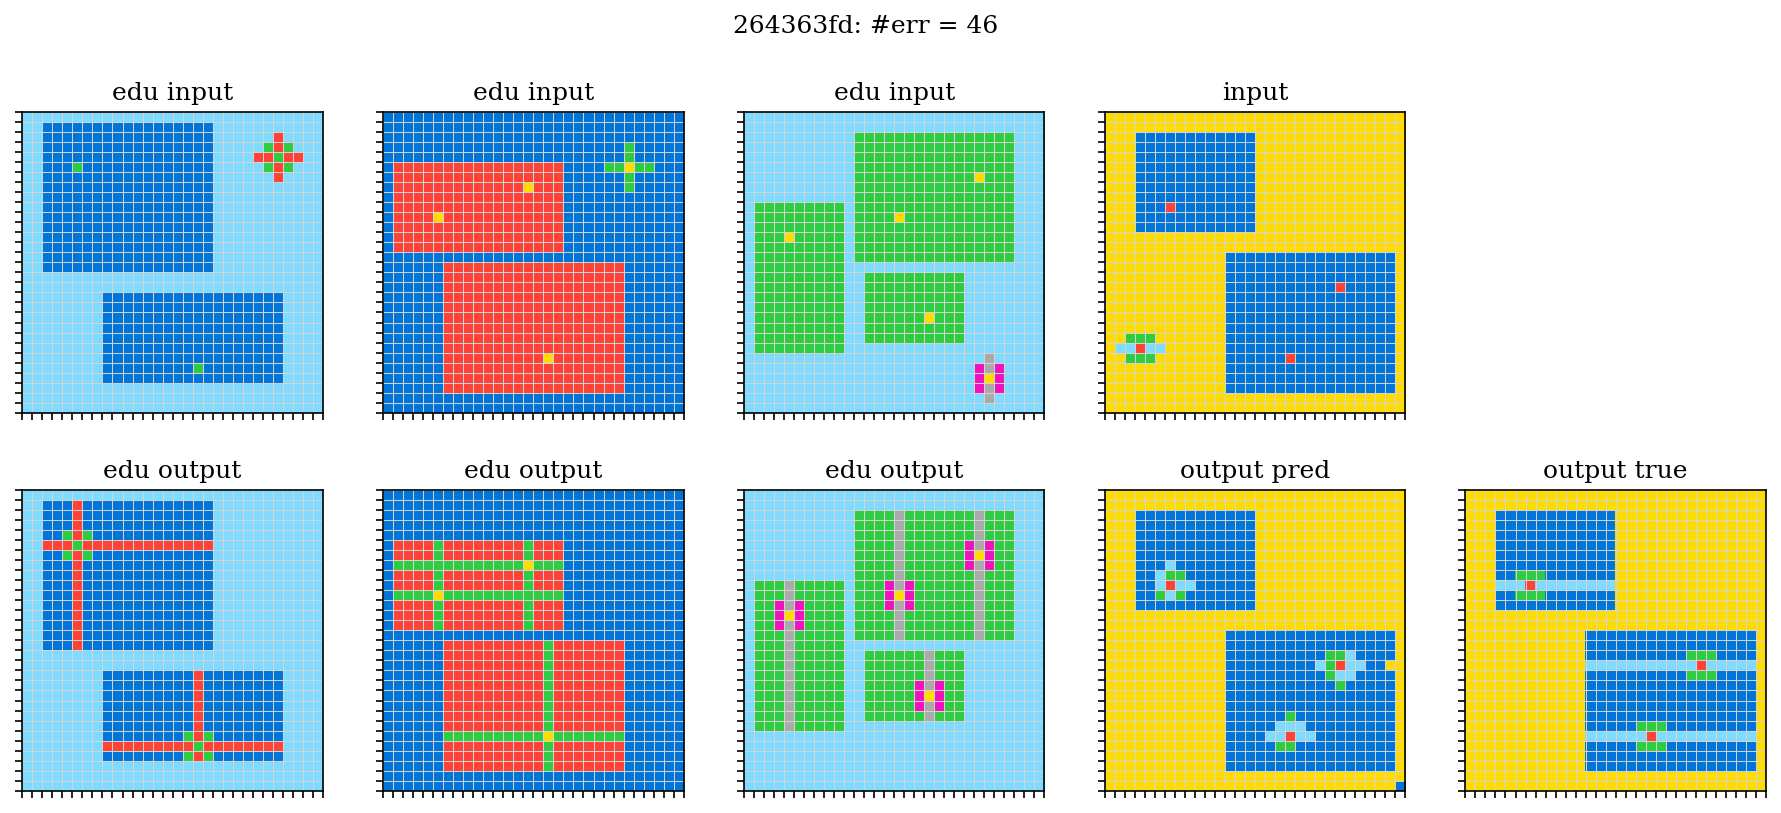

In [52]:
show_task_prediction(train_ids_train[90])

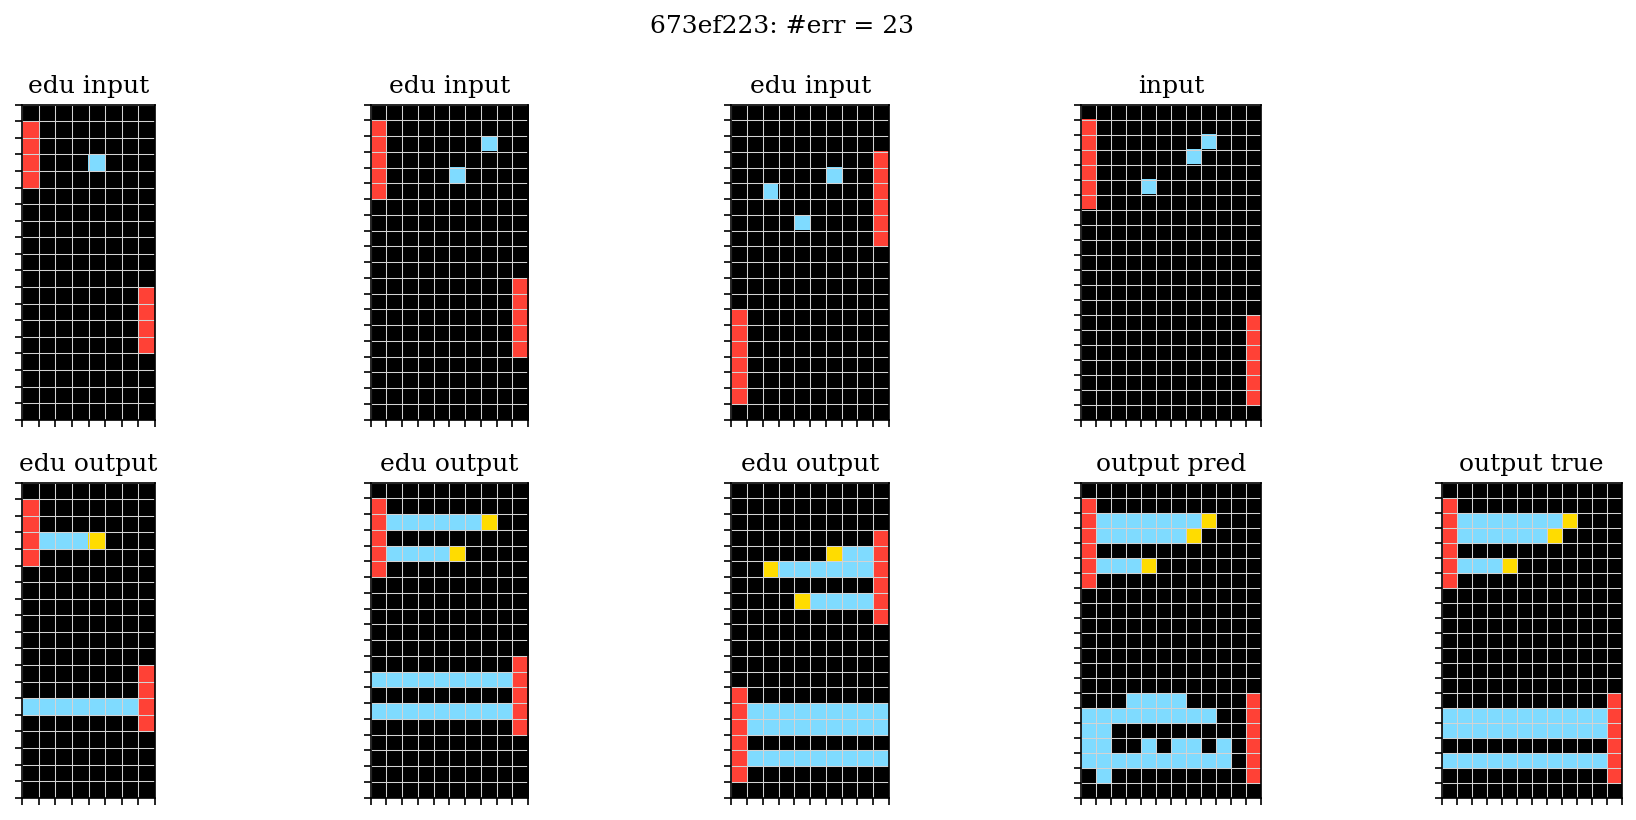

In [53]:
show_task_prediction(train_ids_train[91])

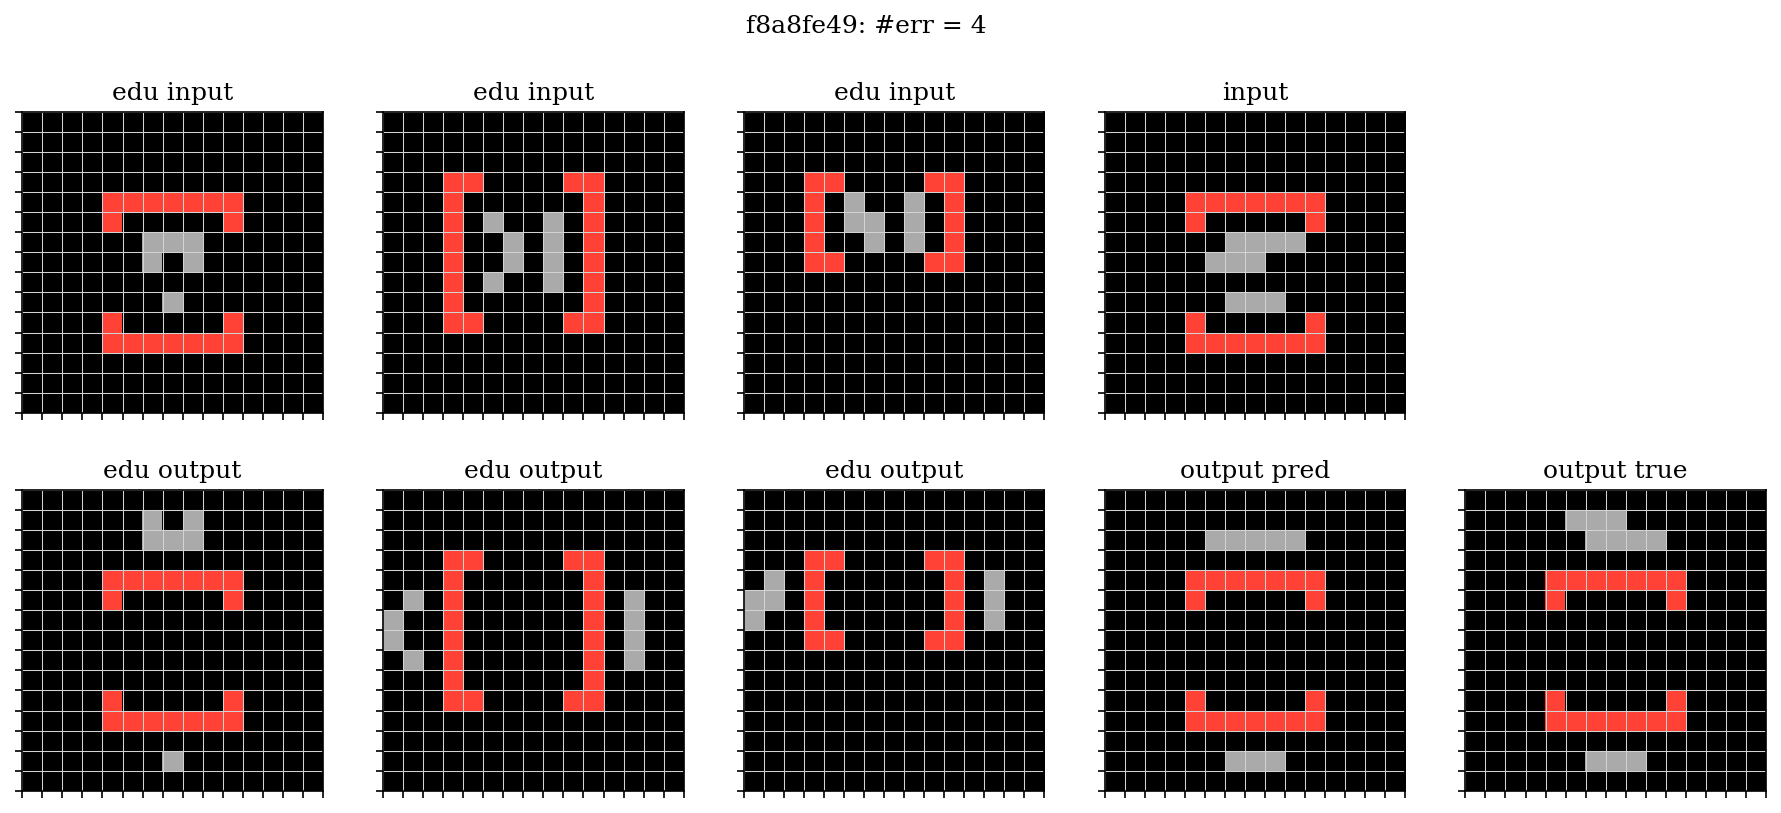

In [54]:
show_task_prediction(train_ids_train[94])

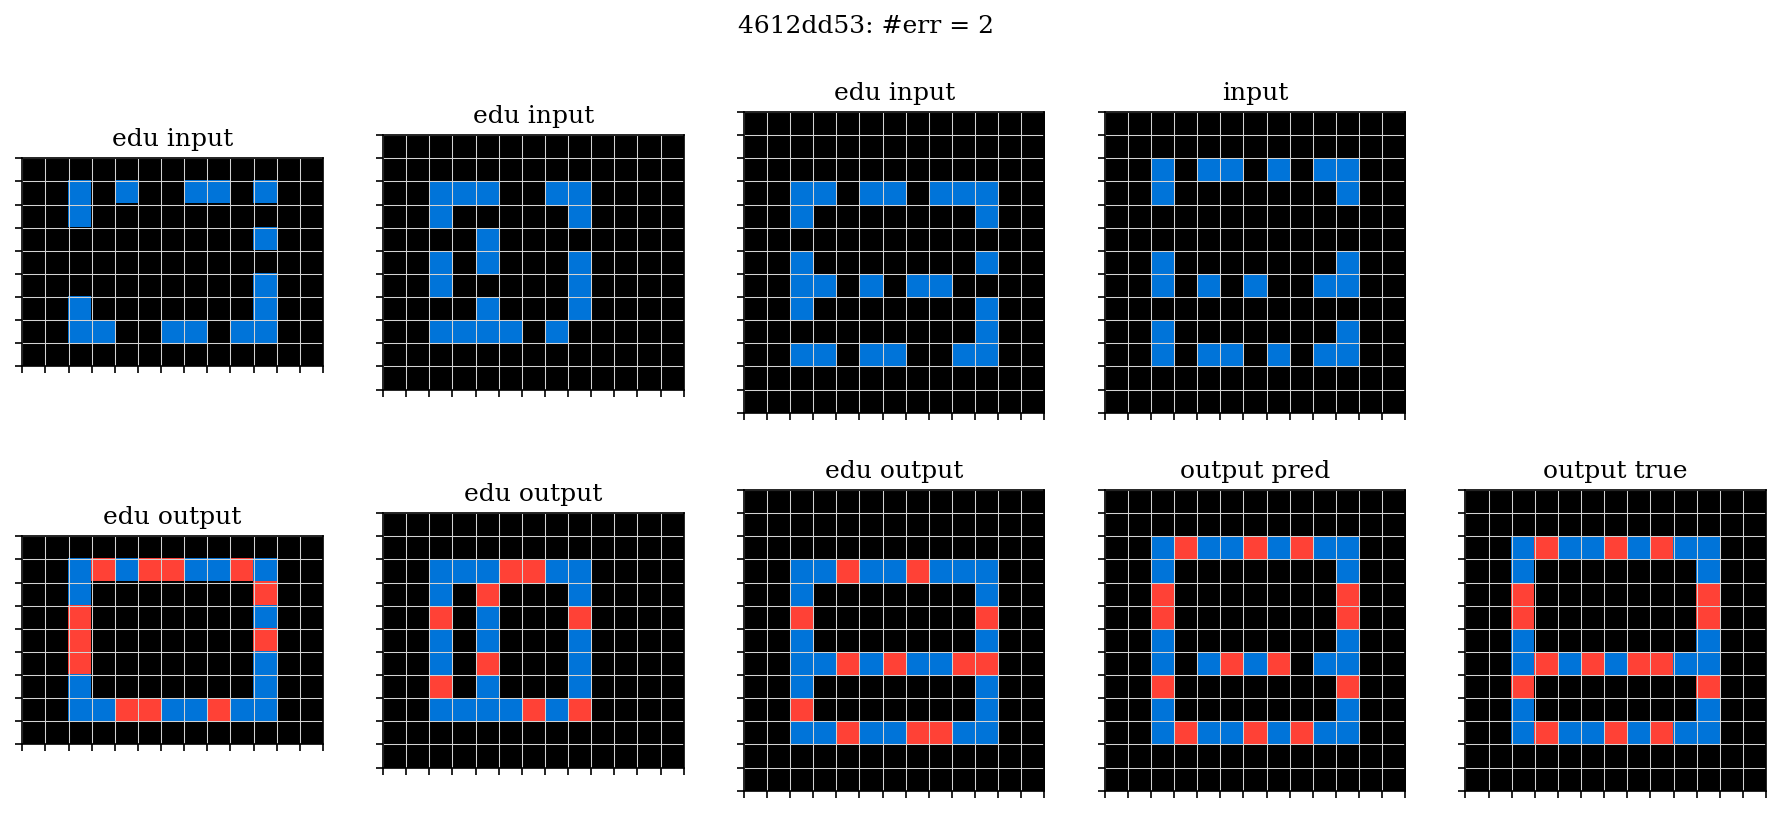

In [55]:
show_task_prediction(train_ids_train[97])

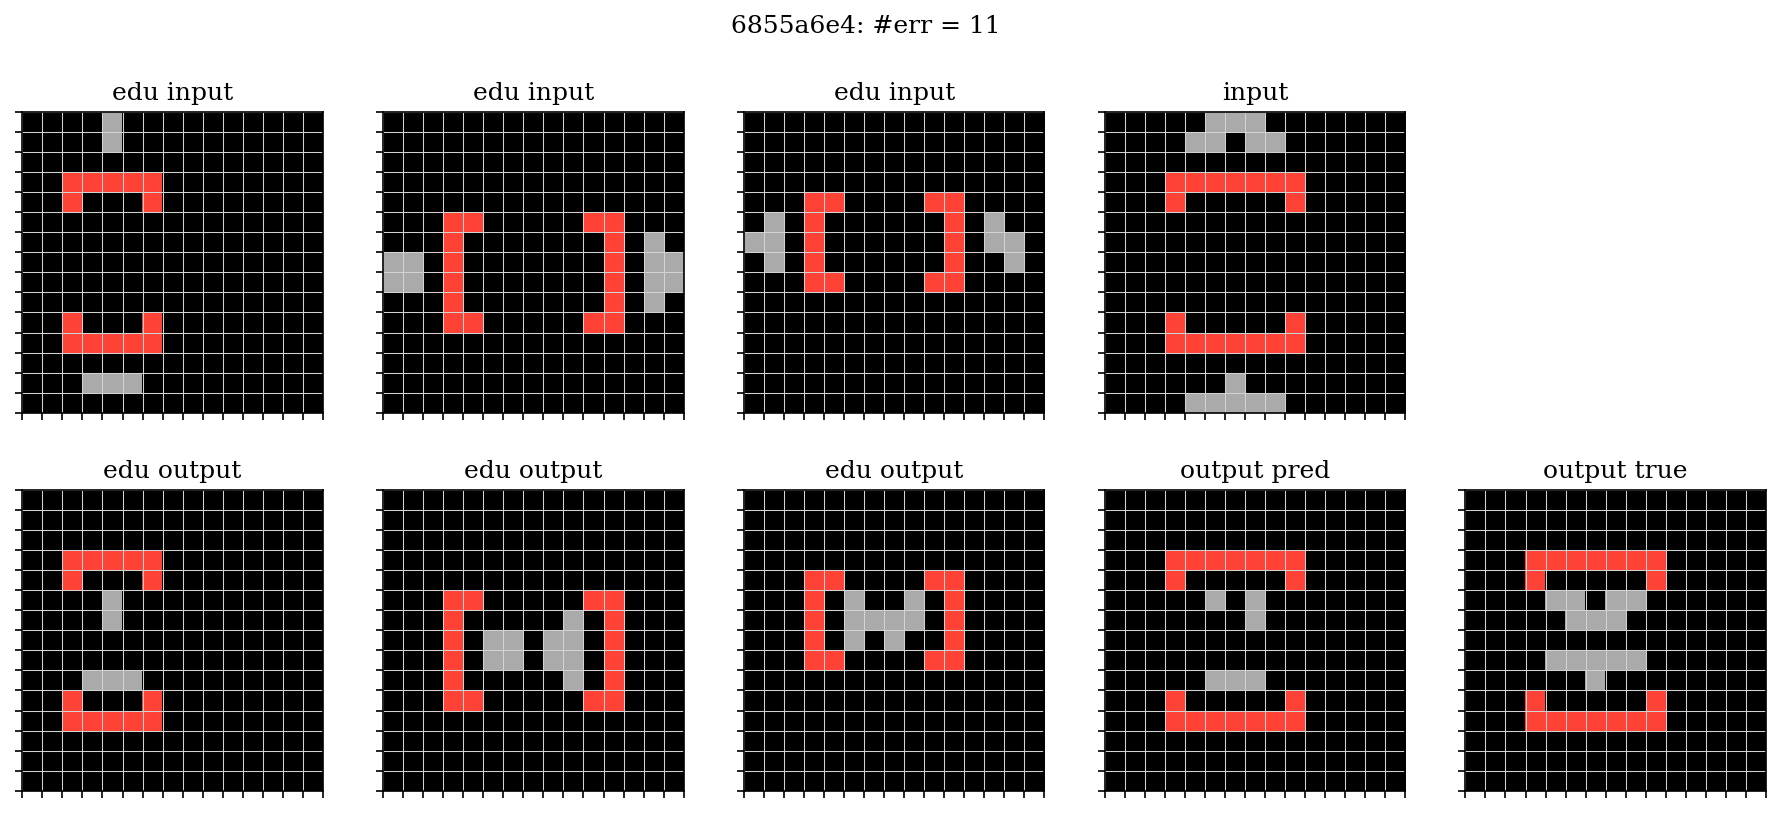

In [56]:
show_task_prediction(train_ids_train[98])

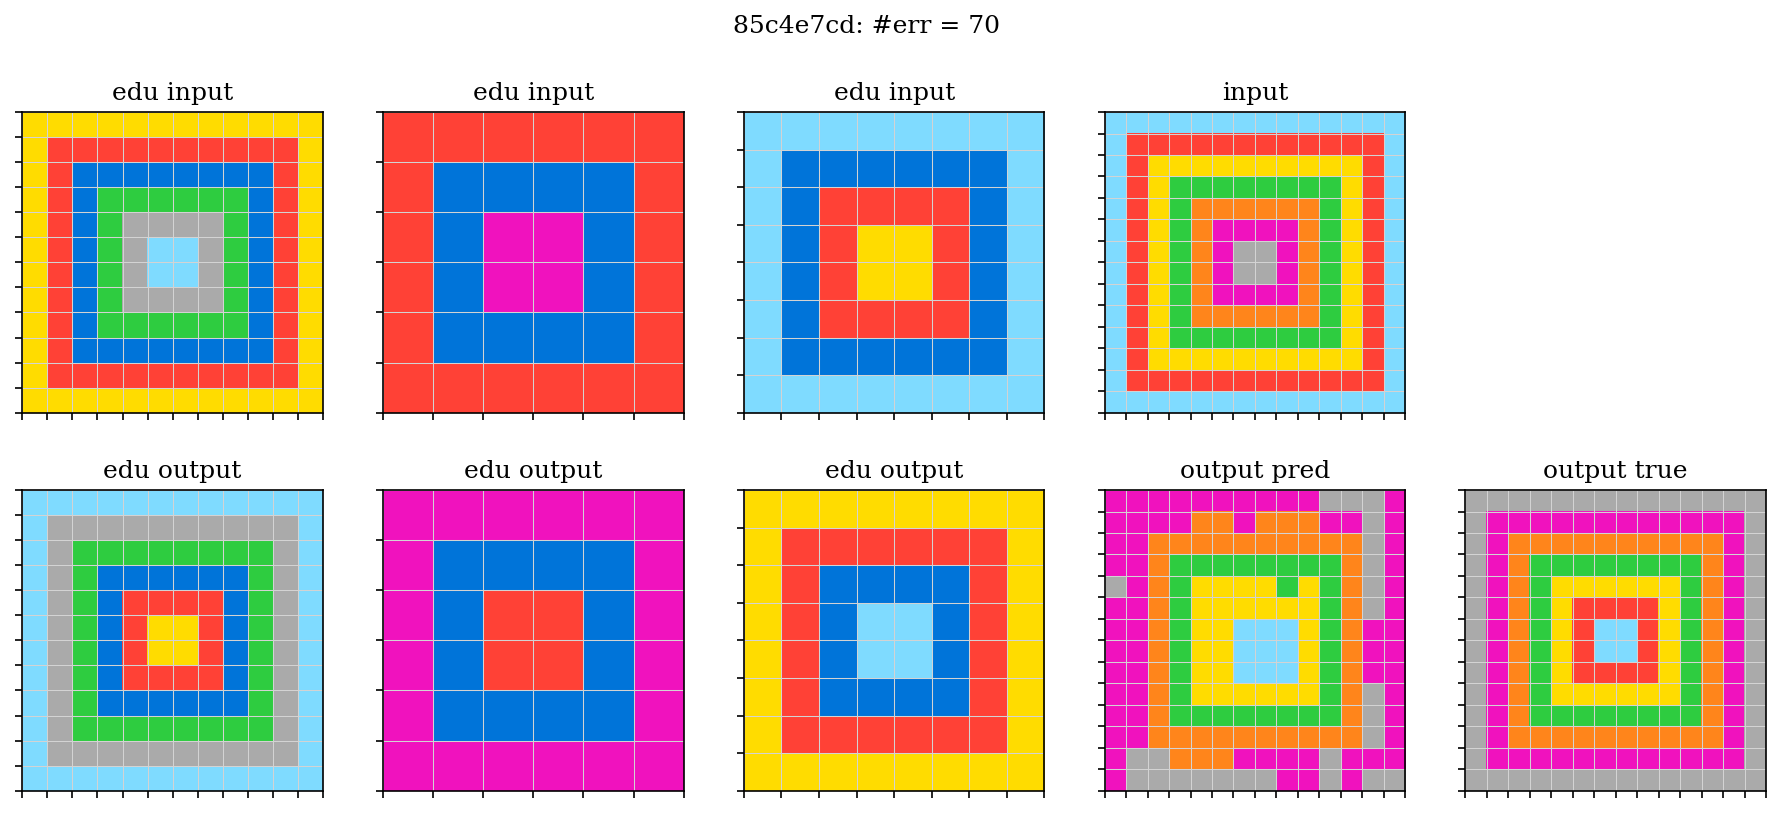

In [57]:
show_task_prediction(train_ids_train[101])

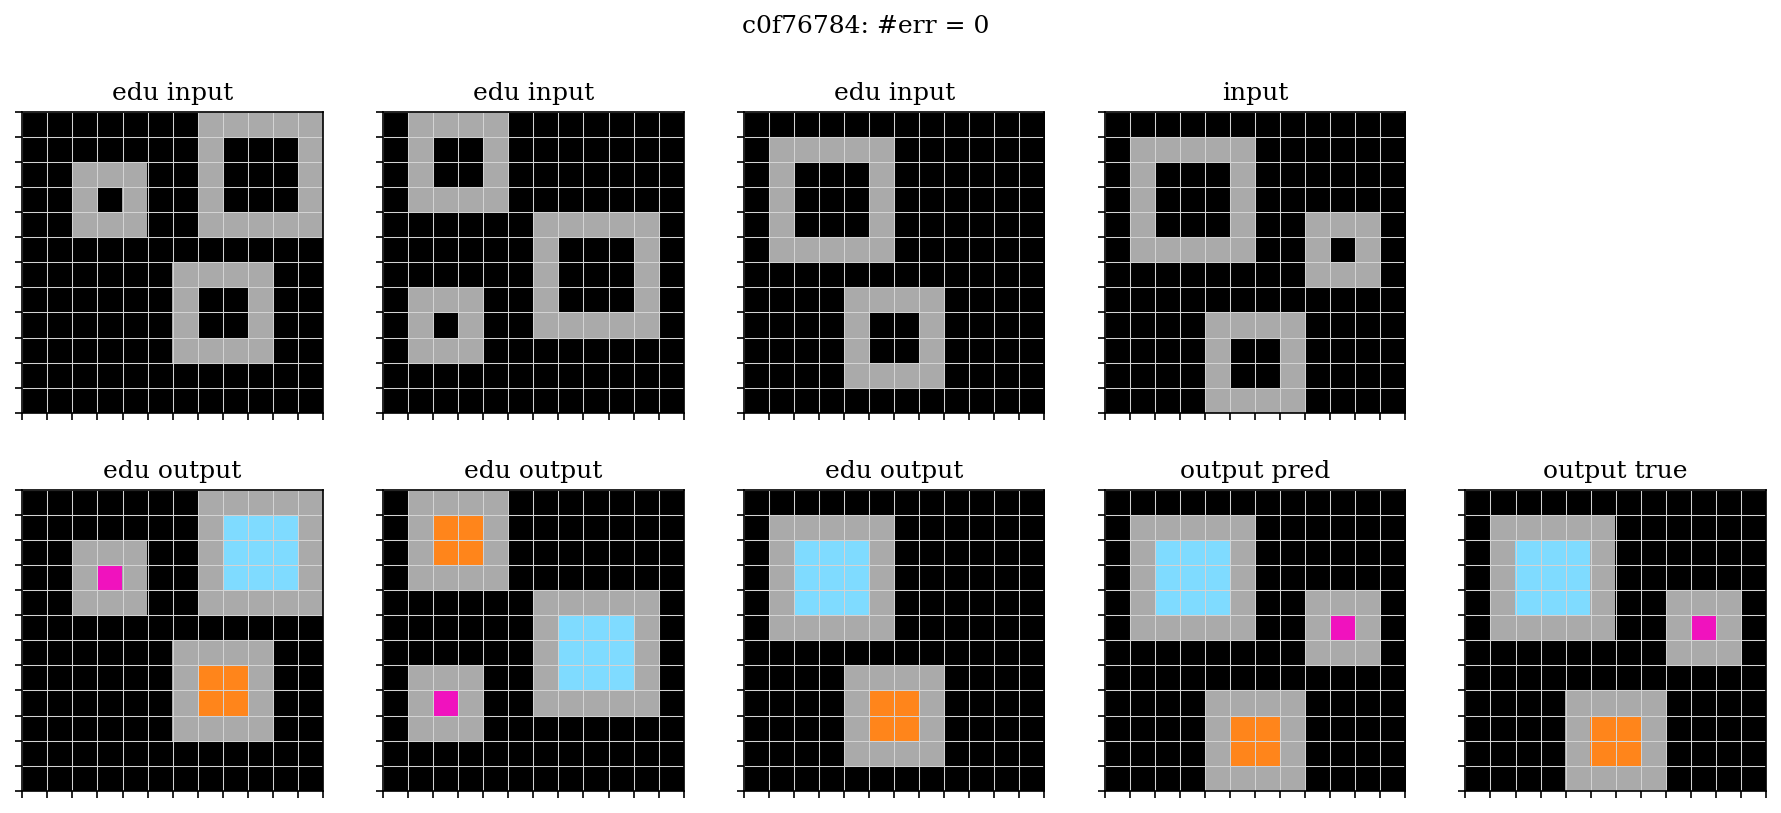

In [58]:
show_task_prediction(train_ids_train[105])

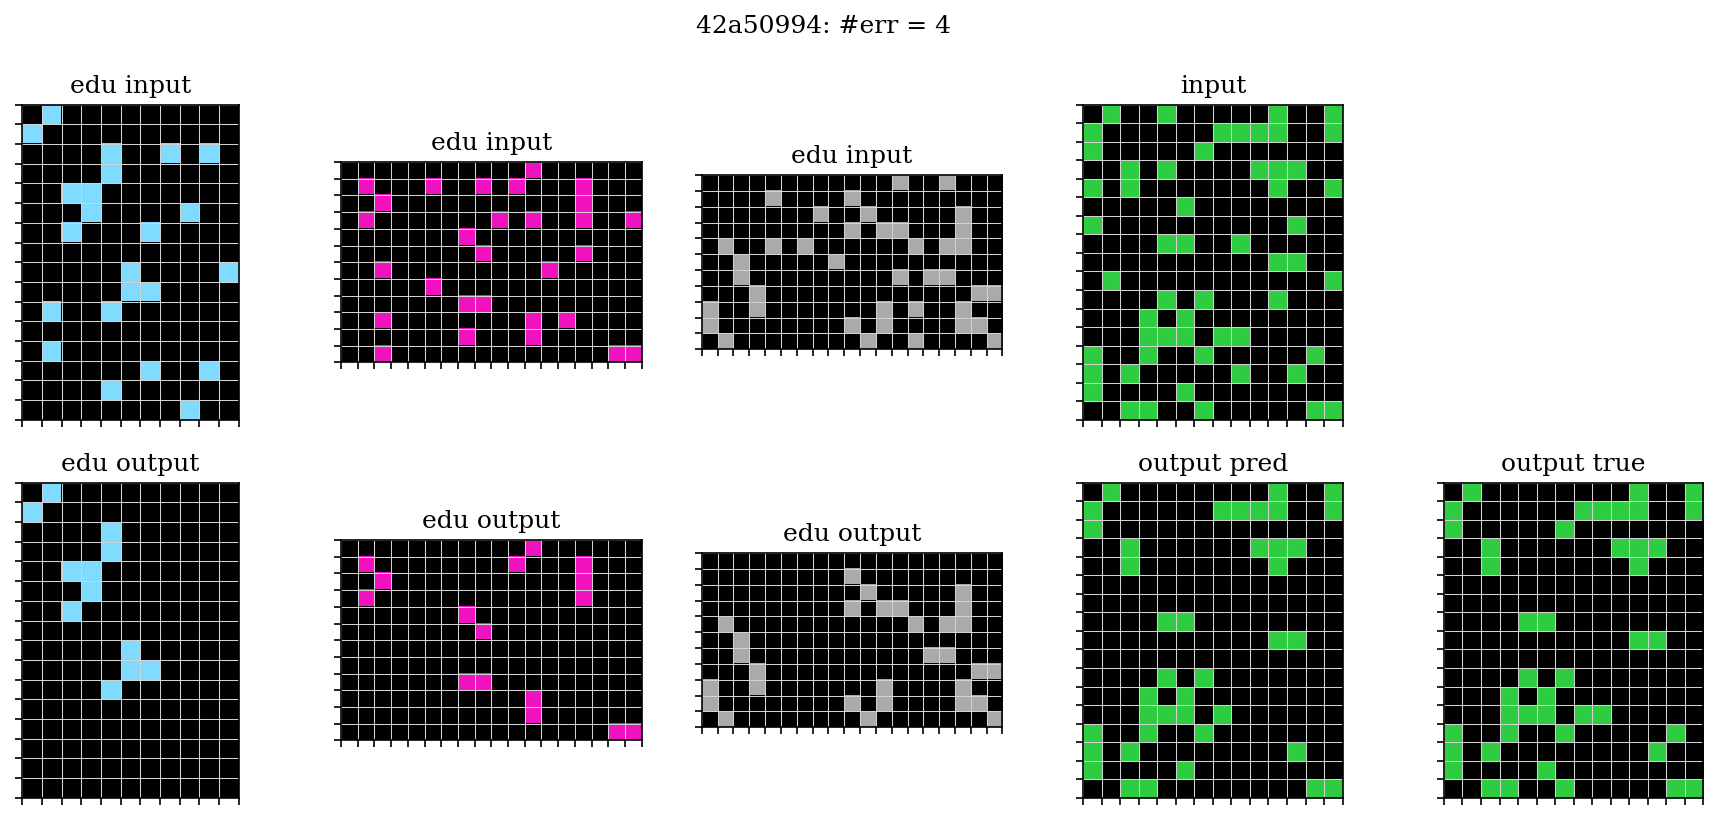

In [59]:
show_task_prediction(train_ids_train[106])

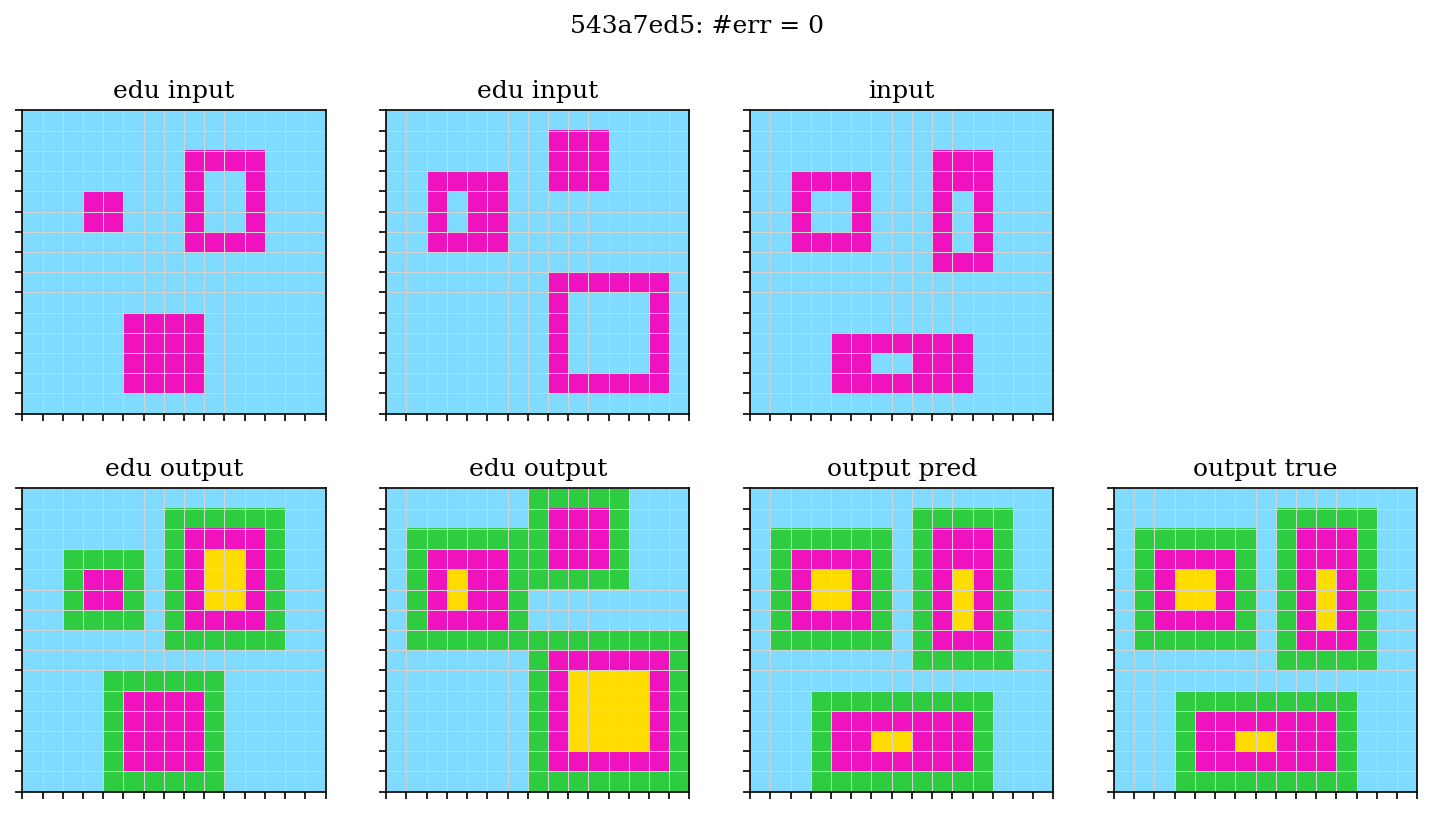

In [60]:
show_task_prediction(train_ids_train[109])

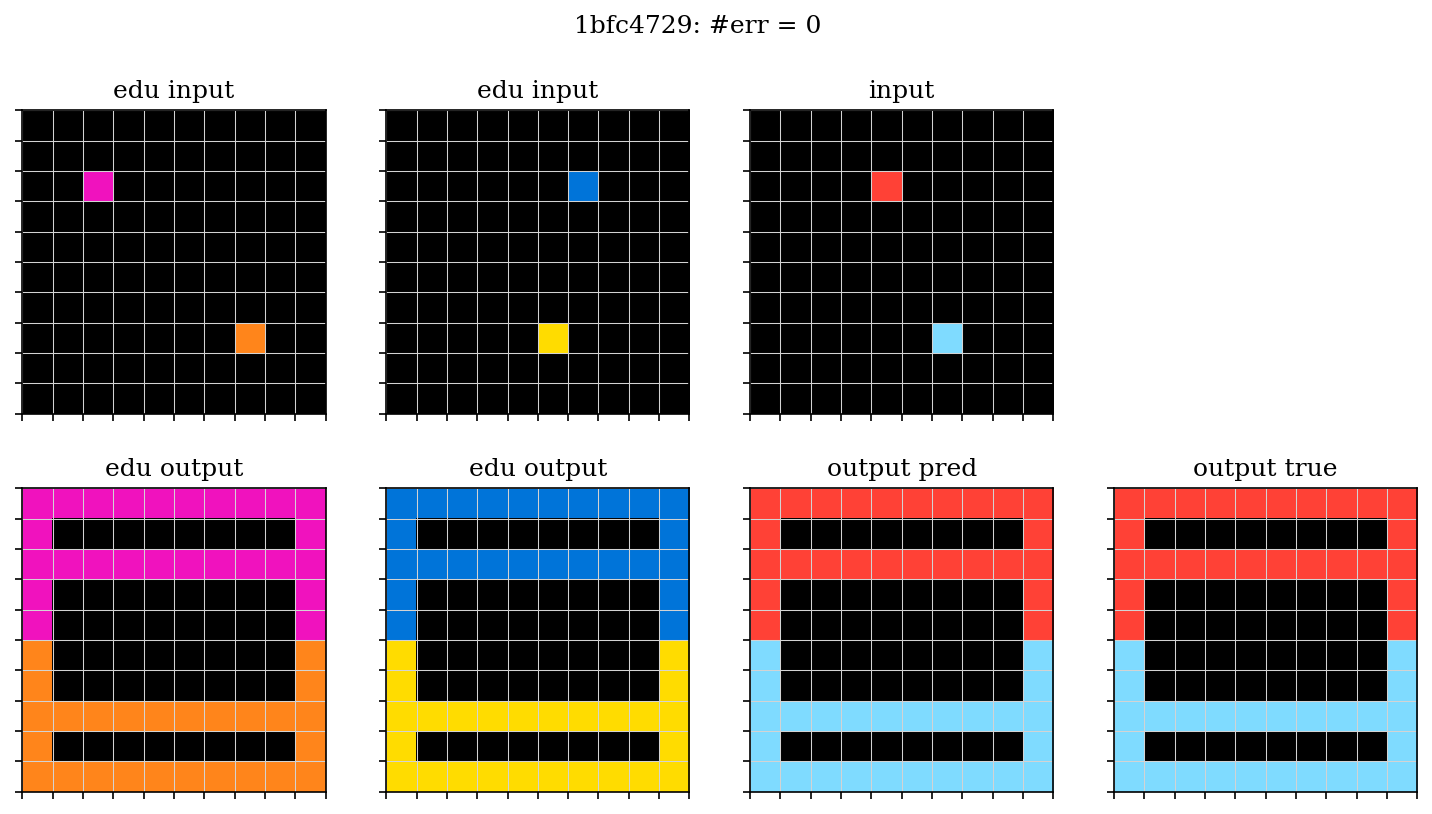

In [61]:
show_task_prediction(train_ids_train[118])

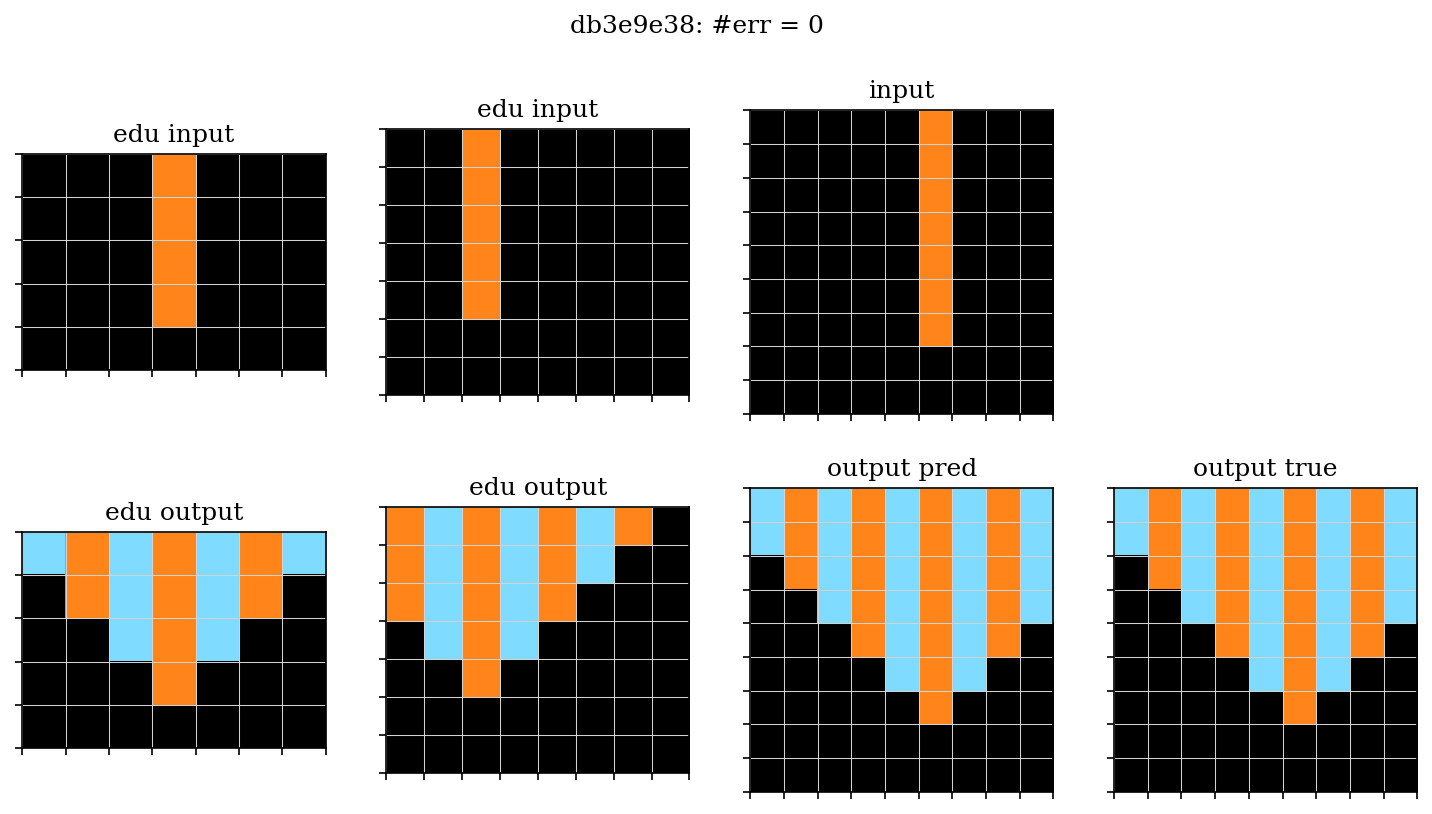

In [62]:
show_task_prediction(train_ids_train[123])